# Predictive Analysis & Early Detection of Brain stroke using Machine Learning Algorithm

## Imports and Settings

In [620]:
## import all the necessary libraries
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns

import shap

from prettytable import PrettyTable

from scipy.stats import f_oneway

In [621]:
# Import scikit-learn components
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import (
    RandomizedSearchCV,
    StratifiedKFold,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

In [622]:
# Import imbalanced-learn components
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, ClusterCentroids
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.metrics import classification_report_imbalanced

## Data Pre-processing

In [623]:
## Load the dataset
df = pd.read_csv("data.csv")

In [624]:
def display_pretty_table(df, rows, title):
    """Helper function to display DataFrame slices in PrettyTable with consistent formatting"""
    print(f"\n=== {title.upper()} ===\n")

    table = PrettyTable()
    numeric_cols = df.select_dtypes(include=["number"]).columns
    table.field_names = df.columns.tolist()

    for row in rows.itertuples(index=False):
        formatted_row = []
        for i, value in enumerate(row):
            col_name = df.columns[i]
            if col_name in numeric_cols and isinstance(value, (int, float)):
                formatted_row.append(
                    f"{value:.2f}" if isinstance(value, float) else str(value)
                )
            else:
                formatted_row.append(str(value))
        table.add_row(formatted_row)

    # Apply alignment - numbers right, first column left
    table.align = "r"  # Right-align all by default
    if len(table.field_names) > 0:
        table.align[table.field_names[0]] = "l"  # Left-align first column

    print(table)

In [625]:
# Display first 5 rows
display_pretty_table(df, df.head(5), "SAMPLE DATA (FIRST 5 ROWS)")


=== SAMPLE DATA (FIRST 5 ROWS) ===

+--------+-----+--------------+---------------+--------------+---------------+----------------+-------------------+-------+-----------------+--------+
| gender | age | hypertension | heart_disease | ever_married |     work_type | Residence_type | avg_glucose_level |   bmi |  smoking_status | stroke |
+--------+-----+--------------+---------------+--------------+---------------+----------------+-------------------+-------+-----------------+--------+
| Female |  32 |            0 |             0 |          Yes |       Private |          Rural |             76.13 | 29.90 |          smokes |      1 |
| Female |  38 |            0 |             0 |           No | Self-employed |          Urban |             82.28 | 24.00 | formerly smoked |      1 |
| Female |  38 |            0 |             0 |          Yes |       Private |          Rural |            101.45 | 29.90 | formerly smoked |      1 |
| Female |  39 |            1 |             0 |          

In [626]:
# Display last 5 rows
display_pretty_table(df, df.tail(5), "SAMPLE DATA (LAST 5 ROWS)")


=== SAMPLE DATA (LAST 5 ROWS) ===

+--------+-----+--------------+---------------+--------------+---------------+----------------+-------------------+-------+-----------------+--------+
| gender | age | hypertension | heart_disease | ever_married |     work_type | Residence_type | avg_glucose_level |   bmi |  smoking_status | stroke |
+--------+-----+--------------+---------------+--------------+---------------+----------------+-------------------+-------+-----------------+--------+
| Male   |  62 |            0 |             1 |          Yes | Self-employed |          Urban |             56.31 | 24.30 | formerly smoked |      0 |
| Female |  62 |            0 |             0 |          Yes |       Private |          Urban |             82.38 | 27.20 | formerly smoked |      0 |
| Female |  62 |            0 |             0 |          Yes |       Private |          Rural |             91.65 | 30.50 |    never smoked |      0 |
| Female |  62 |            0 |             0 |          Y

In [627]:
# Display random 5 rows
display_pretty_table(df, df.sample(5), "SAMPLE DATA (RANDOM 5 ROWS)")


=== SAMPLE DATA (RANDOM 5 ROWS) ===

+--------+-----+--------------+---------------+--------------+---------------+----------------+-------------------+-------+-----------------+--------+
| gender | age | hypertension | heart_disease | ever_married |     work_type | Residence_type | avg_glucose_level |   bmi |  smoking_status | stroke |
+--------+-----+--------------+---------------+--------------+---------------+----------------+-------------------+-------+-----------------+--------+
| Female |  50 |            0 |             0 |          Yes |       Private |          Rural |             93.47 | 28.70 |    never smoked |      0 |
| Female |  78 |            0 |             1 |          Yes |      Govt_job |          Urban |            212.62 | 26.50 |    never smoked |      1 |
| Male   |  77 |            0 |             0 |          Yes | Self-employed |          Rural |            162.14 | 32.60 | formerly smoked |      1 |
| Male   |  80 |            0 |             0 |         

In [628]:
print("=== EXPLORATORY DATA ANALYSIS ===")

overview_table = PrettyTable()
overview_table.field_names = ["EDA Metric", "Value"]
overview_table.align["EDA Metric"] = "l"
overview_table.align["Value"] = "r"

# Add dataset shape information
overview_table.add_row(["Number of Rows (Observations)", df.shape[0]])
overview_table.add_row(["Number of Columns (Features)", df.shape[1]])
overview_table.add_row(["Total Data Points", df.size])

# Add separator
overview_table.add_row(["─" * 30, "─" * 15])

# Add data type information
dtype_counts = df.dtypes.value_counts()
for dtype, count in dtype_counts.items():
    overview_table.add_row([f"Columns with {dtype}", count])

# Add separator
overview_table.add_row(["─" * 30, "─" * 15])

# Add missing values information
overview_table.add_row(["Total Missing Values", df.isnull().sum().sum()])
overview_table.add_row(
    ["% Missing Values", f"{(df.isnull().sum().sum() / df.size) * 100:.2f}%"]
)

print(overview_table)

=== EXPLORATORY DATA ANALYSIS ===
+--------------------------------+-----------------+
| EDA Metric                     |           Value |
+--------------------------------+-----------------+
| Number of Rows (Observations)  |            3199 |
| Number of Columns (Features)   |              11 |
| Total Data Points              |           35189 |
| ────────────────────────────── | ─────────────── |
| Columns with object            |               5 |
| Columns with int64             |               4 |
| Columns with float64           |               2 |
| ────────────────────────────── | ─────────────── |
| Total Missing Values           |             283 |
| % Missing Values               |           0.80% |
+--------------------------------+-----------------+


In [629]:
print("\n=== COLUMN DETAILS ===")
column_table = PrettyTable()
column_table.field_names = ["Feature", "Missing Values", "Unique Values"]

# Configure alignment
column_table.align["Feature"] = "l"
column_table.align["Missing Values"] = "r"
column_table.align["Unique Values"] = "r"

# Add data for each column
for col in df.columns:
    column_table.add_row([col, df[col].isnull().sum(), df[col].nunique()])

print(column_table)


=== COLUMN DETAILS ===
+-------------------+----------------+---------------+
| Feature           | Missing Values | Unique Values |
+-------------------+----------------+---------------+
| gender            |              0 |             2 |
| age               |              0 |            64 |
| hypertension      |              0 |             2 |
| heart_disease     |              0 |             2 |
| ever_married      |              0 |             2 |
| work_type         |              0 |             4 |
| Residence_type    |              0 |             2 |
| avg_glucose_level |              0 |          2597 |
| bmi               |            139 |           316 |
| smoking_status    |            144 |             3 |
| stroke            |              0 |             2 |
+-------------------+----------------+---------------+


In [630]:
print("\n=== DATA TYPES ===")

dtype_table = PrettyTable()
dtype_table.field_names = ["Feature", "Data Type"]

# Configure alignment
dtype_table.align["Feature"] = "l"
dtype_table.align["Data Type"] = "l"

# Add data types for each column
for col in df.columns:
    dtype_table.add_row([col, str(df[col].dtype)])

print(dtype_table)


=== DATA TYPES ===
+-------------------+-----------+
| Feature           | Data Type |
+-------------------+-----------+
| gender            | object    |
| age               | int64     |
| hypertension      | int64     |
| heart_disease     | int64     |
| ever_married      | object    |
| work_type         | object    |
| Residence_type    | object    |
| avg_glucose_level | float64   |
| bmi               | float64   |
| smoking_status    | object    |
| stroke            | int64     |
+-------------------+-----------+


In [631]:
# Summary statistics table with explanation
print("\n=== NUMERICAL FEATURE SUMMARY STATISTICS ===\n")
print(
    "This table shows key statistical measures for each numerical column in the dataset:"
)
print("- Count: Number of non-null values")
print("- Mean: Average value")
print("- Std: Standard deviation (measure of dispersion)")
print("- Min: Minimum value")
print("- 25%: First quartile (25th percentile)")
print("- 50%: Median (50th percentile)")
print("- 75%: Third quartile (75th percentile)")
print("- Max: Maximum value\n")

stats = df.describe()
table = PrettyTable()
table.field_names = ["Statistic"] + list(stats.columns)
for idx in stats.index:
    table.add_row([idx] + [f"{x:.2f}" for x in stats.loc[idx]])
print(table)


=== NUMERICAL FEATURE SUMMARY STATISTICS ===

This table shows key statistical measures for each numerical column in the dataset:
- Count: Number of non-null values
- Mean: Average value
- Std: Standard deviation (measure of dispersion)
- Min: Minimum value
- 25%: First quartile (25th percentile)
- 50%: Median (50th percentile)
- 75%: Third quartile (75th percentile)
- Max: Maximum value

+-----------+---------+--------------+---------------+-------------------+---------+---------+
| Statistic |   age   | hypertension | heart_disease | avg_glucose_level |   bmi   |  stroke |
+-----------+---------+--------------+---------------+-------------------+---------+---------+
|   count   | 3199.00 |   3199.00    |    3199.00    |      3199.00      | 3060.00 | 3199.00 |
|    mean   |  50.11  |     0.14     |      0.09     |       111.29      |  30.16  |   0.31  |
|    std    |  16.96  |     0.34     |      0.28     |       49.88       |   6.34  |   0.46  |
|    min    |  14.00  |     0.00     

In [632]:
# Missing values table with explanation
print("\n=== MISSING VALUE ANALYSIS ===\n")
print("This table shows data completeness for each column:")
print("- Missing Values: Count of null/empty entries")
print("- % Missing: Percentage of total rows that are null")
print("Note: Columns with high missing percentages (>30%) may need special handling\n")

table = PrettyTable()
table.field_names = ["Column", "Missing Values", "% Missing"]
for col in df.columns:
    missing = df[col].isnull().sum()
    table.add_row([col, missing, f"{(missing / len(df)) * 100:.2f}%"])
print(table)

print("\nRecommendations:")
print("- Consider imputation for columns with <30% missing values")
print("- Evaluate dropping columns with >50% missing values")
print("- Investigate columns with unexpected missing patterns")


=== MISSING VALUE ANALYSIS ===

This table shows data completeness for each column:
- Missing Values: Count of null/empty entries
- % Missing: Percentage of total rows that are null
Note: Columns with high missing percentages (>30%) may need special handling

+-------------------+----------------+-----------+
|       Column      | Missing Values | % Missing |
+-------------------+----------------+-----------+
|       gender      |       0        |   0.00%   |
|        age        |       0        |   0.00%   |
|    hypertension   |       0        |   0.00%   |
|   heart_disease   |       0        |   0.00%   |
|    ever_married   |       0        |   0.00%   |
|     work_type     |       0        |   0.00%   |
|   Residence_type  |       0        |   0.00%   |
| avg_glucose_level |       0        |   0.00%   |
|        bmi        |      139       |   4.35%   |
|   smoking_status  |      144       |   4.50%   |
|       stroke      |       0        |   0.00%   |
+-------------------+----

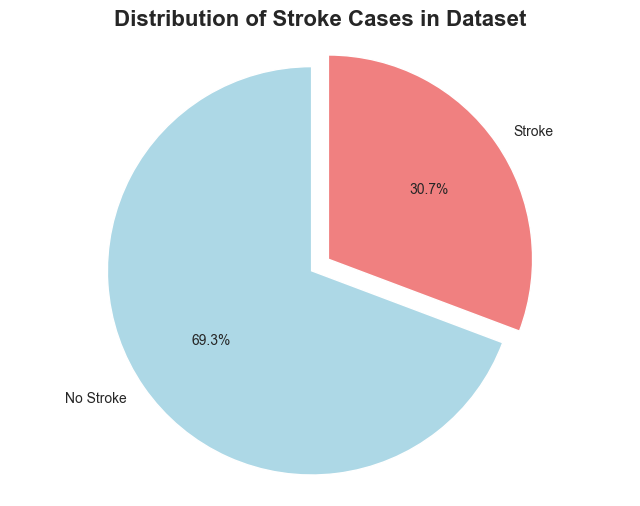

In [633]:
# Pie chart for stroke vs non-stroke cases
stroke_counts = df["stroke"].value_counts()
stroke_labels = ["No Stroke", "Stroke"]
colors = ["lightblue", "lightcoral"]

plt.figure(figsize=(8, 6))
plt.pie(
    stroke_counts.values,
    labels=stroke_labels,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    explode=(0, 0.1),
)
plt.title("Distribution of Stroke Cases in Dataset", fontsize=16, fontweight="bold")
plt.axis("equal")
plt.show()

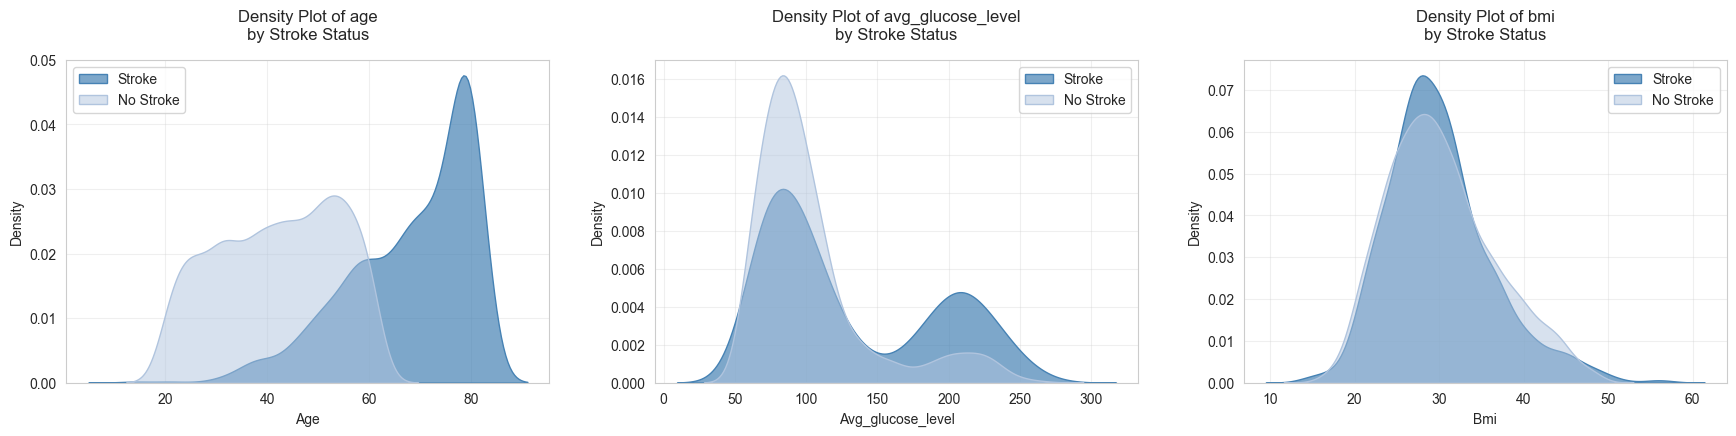

In [634]:
num_cols = ["age", "avg_glucose_level", "bmi"]

plt.figure(figsize=(18, 5))

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, 3, i)

    stroke_data = df[df["stroke"] == 1][col].dropna()
    no_stroke_data = df[df["stroke"] == 0][col].dropna()

    sns.kdeplot(stroke_data, label="Stroke", fill=True, alpha=0.7, color="steelblue")
    sns.kdeplot(
        no_stroke_data, label="No Stroke", fill=True, alpha=0.5, color="lightsteelblue"
    )

    plt.title(f"Density Plot of {col}\nby Stroke Status", pad=15)
    plt.xlabel(col.capitalize())
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True, alpha=0.3)

plt.tight_layout(pad=3.0)
plt.show()

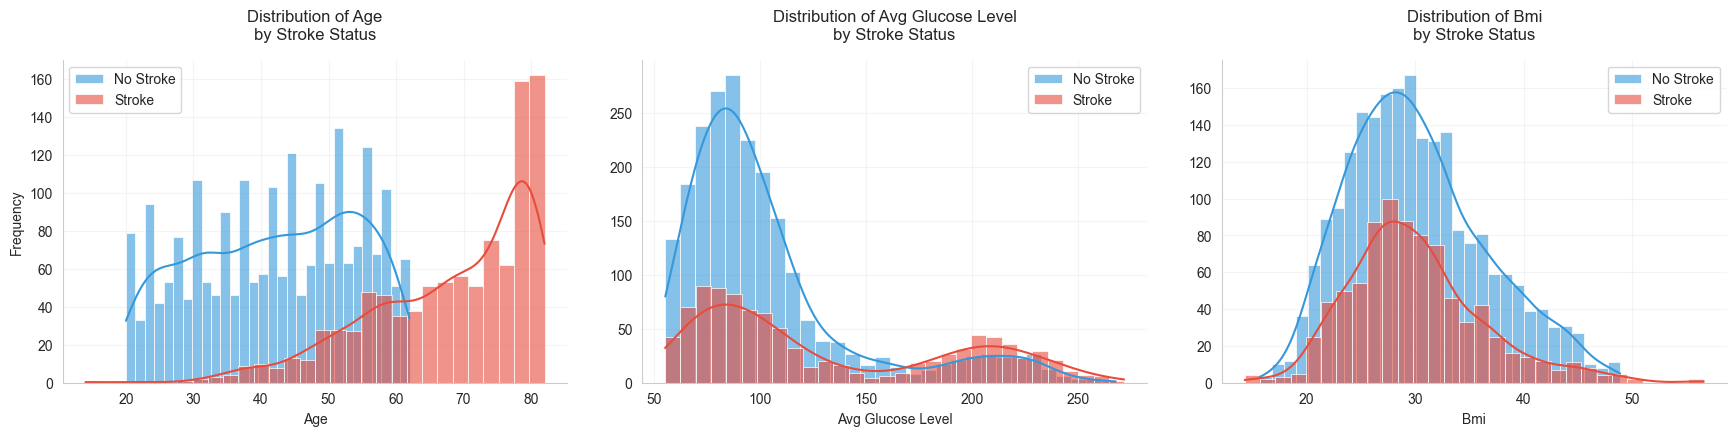

In [635]:
numerical_cols = ["age", "avg_glucose_level", "bmi"]

plt.figure(figsize=(18, 5))

for i, col in enumerate(numerical_cols, 1):
    ax = plt.subplot(1, 3, i)

    stroke_data = df[df["stroke"] == 1][col].dropna()
    no_stroke_data = df[df["stroke"] == 0][col].dropna()

    sns.histplot(
        no_stroke_data,
        bins=30,
        alpha=0.6,
        label="No Stroke",
        color="#3498db",
        kde=True,
        edgecolor="white",
        linewidth=0.5,
    )
    sns.histplot(
        stroke_data,
        bins=30,
        alpha=0.6,
        label="Stroke",
        color="#e74c3c",
        kde=True,
        edgecolor="white",
        linewidth=0.5,
    )

    plt.title(
        f"Distribution of {col.replace('_', ' ').title()}\nby Stroke Status", pad=15
    )
    plt.xlabel(col.replace("_", " ").title())
    if i == 1:
        plt.ylabel("Frequency")
    else:
        plt.ylabel("")

    plt.legend()
    plt.grid(True, alpha=0.2)

    sns.despine()

plt.tight_layout(pad=3.0)
plt.show()

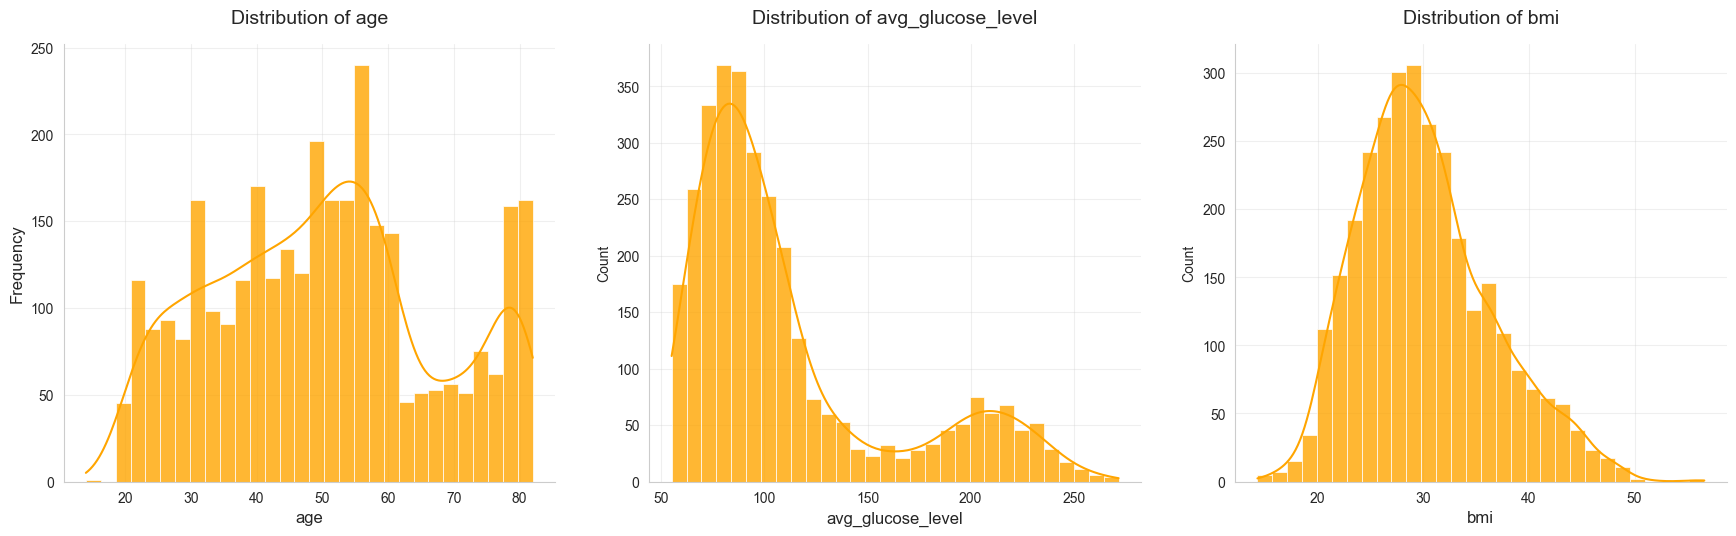

In [636]:
# Set style for better visuals
sns.set_style("whitegrid")
plt.rcParams["figure.facecolor"] = "white"

# Define columns and create plot
numerical_cols = ["age", "avg_glucose_level", "bmi"]
plt.figure(figsize=(18, 6))  # Wider figure for better display

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(1, 3, i)
    sns.histplot(
        df[col],
        kde=True,
        color="orange",
        bins=30,
        edgecolor="white",
        linewidth=0.5,
        alpha=0.8,
    )
    plt.title(f"Distribution of {col}", fontsize=14, pad=15)
    plt.xlabel(col, fontsize=12)
    if i == 1:
        plt.ylabel("Frequency", fontsize=12)

plt.tight_layout(pad=3)
for ax in plt.gcf().axes:
    ax.grid(True, alpha=0.3)
    sns.despine(ax=ax)
plt.show()

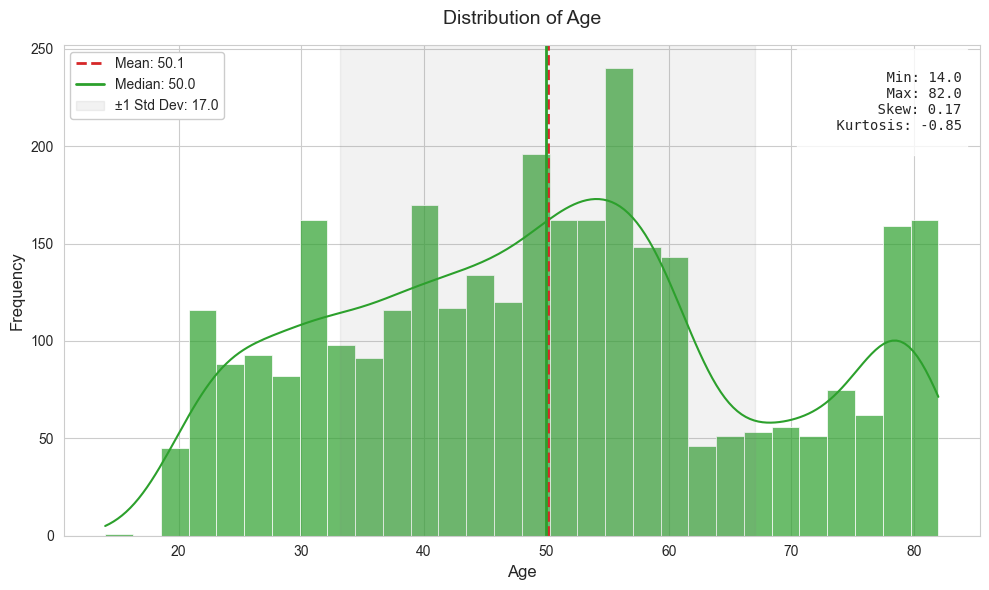

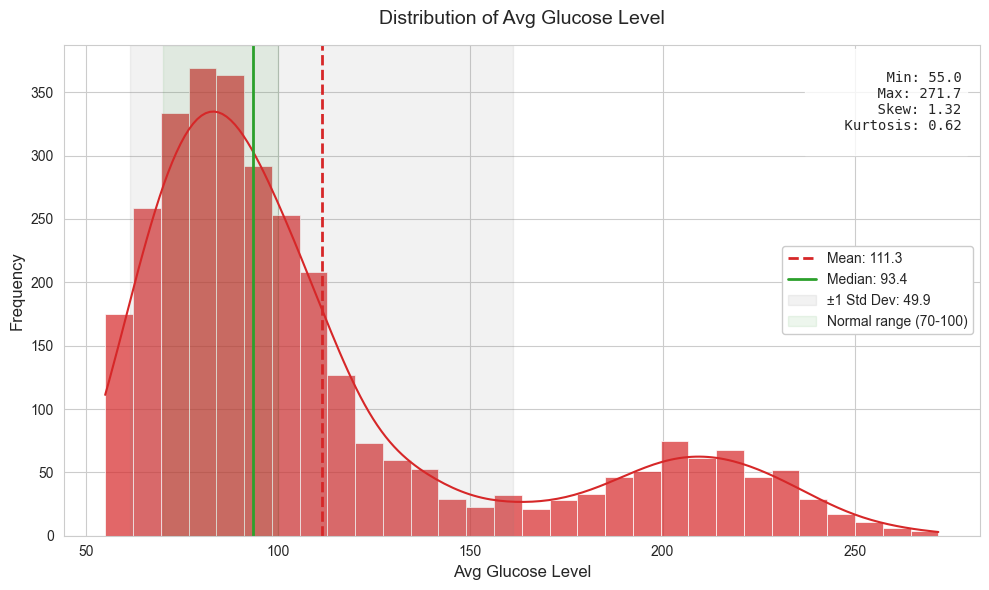

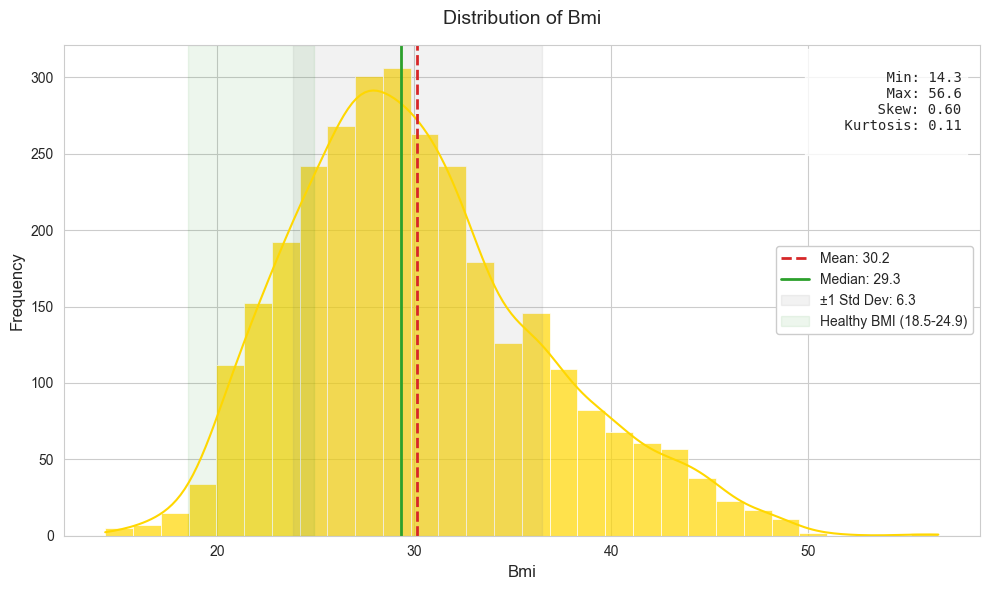

In [637]:
# Define a color palette for each feature
palette = {
    "age": "#2CA02C",  # Green
    "avg_glucose_level": "#D62728",  # Red
    "bmi": "#FFD700",  # Yellow
}

# Set style
sns.set_style("whitegrid")

for col in numerical_cols:
    plt.figure(figsize=(10, 6))

    # Create histogram with unique color
    sns.histplot(
        data=df,
        x=col,
        kde=True,
        bins=30,
        color=palette[col],  # Unique color for each feature
        alpha=0.7,
        edgecolor="white",
        linewidth=0.5,
    )

    # Add distribution metrics
    mean_val = df[col].mean()
    median_val = df[col].median()
    std_val = df[col].std()

    # Add reference lines
    plt.axvline(
        mean_val,
        color="#D62728",
        linestyle="--",
        linewidth=2,
        label=f"Mean: {mean_val:.1f}",
    )
    plt.axvline(
        median_val,
        color="#2CA02C",
        linestyle="-",
        linewidth=2,
        label=f"Median: {median_val:.1f}",
    )

    # Add shaded standard deviation
    plt.axvspan(
        mean_val - std_val,
        mean_val + std_val,
        color="gray",
        alpha=0.1,
        label=f"±1 Std Dev: {std_val:.1f}",
    )

    # Add clinical reference ranges if applicable
    if col == "avg_glucose_level":
        plt.axvspan(70, 100, color="green", alpha=0.07, label="Normal range (70-100)")
    elif col == "bmi":
        plt.axvspan(
            18.5, 24.9, color="green", alpha=0.07, label="Healthy BMI (18.5-24.9)"
        )

    # Customize appearance
    plt.title(f"Distribution of {col.replace('_', ' ').title()}", fontsize=14, pad=15)
    plt.xlabel(col.replace("_", " ").title(), fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.legend(fontsize=10, framealpha=1)

    # Add summary statistics box
    stats_text = f"""
    Min: {df[col].min():.1f}
    Max: {df[col].max():.1f}
    Skew: {df[col].skew():.2f}
    Kurtosis: {df[col].kurtosis():.2f}
    """
    plt.text(
        0.98,
        0.98,
        stats_text,
        transform=plt.gca().transAxes,
        verticalalignment="top",
        horizontalalignment="right",
        bbox=dict(facecolor="white", alpha=0.8),
        fontfamily="monospace",
    )

    plt.tight_layout()
    plt.show()

<Figure size 1200x1000 with 0 Axes>

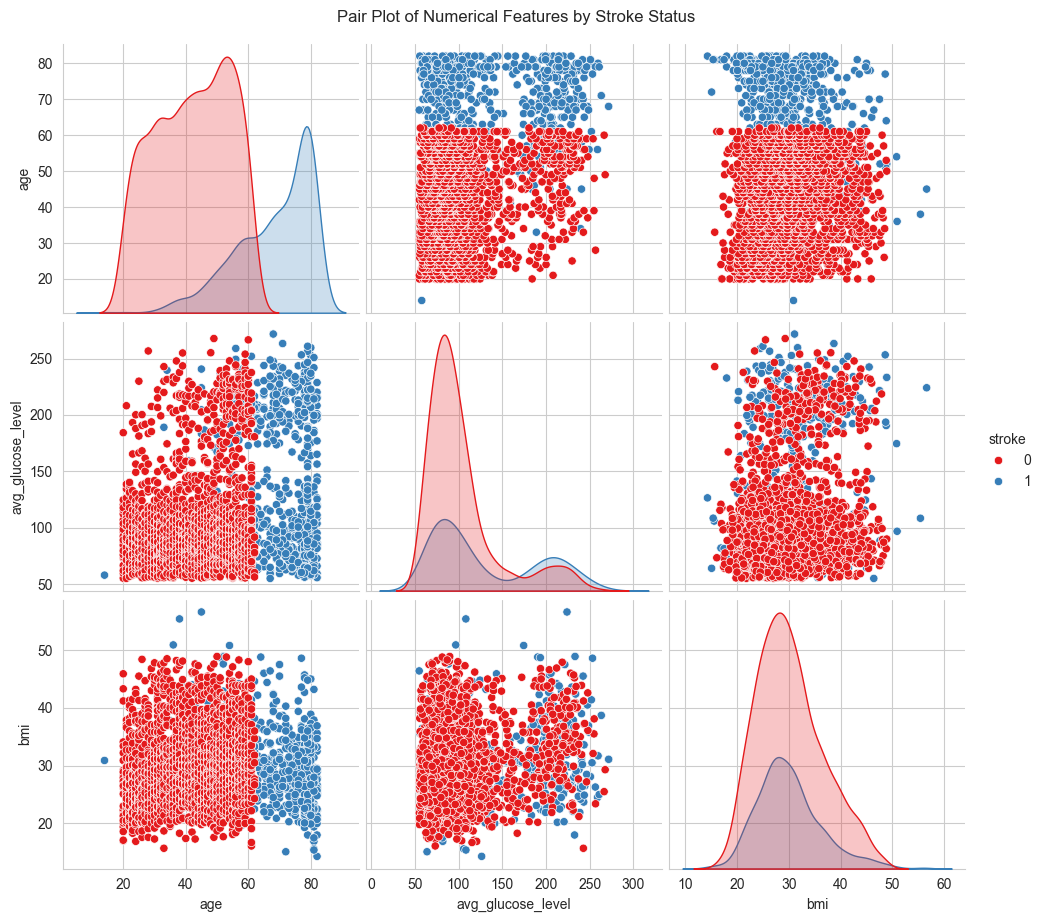

In [638]:
numerical_cols = ["age", "avg_glucose_level", "bmi"]
# pair plot
plt.figure(figsize=(12, 10))
sns.pairplot(
    df[numerical_cols + ["stroke"]], hue="stroke", palette="Set1", aspect=1.1, height=3
)
plt.suptitle("Pair Plot of Numerical Features by Stroke Status", y=1.02)
plt.show()

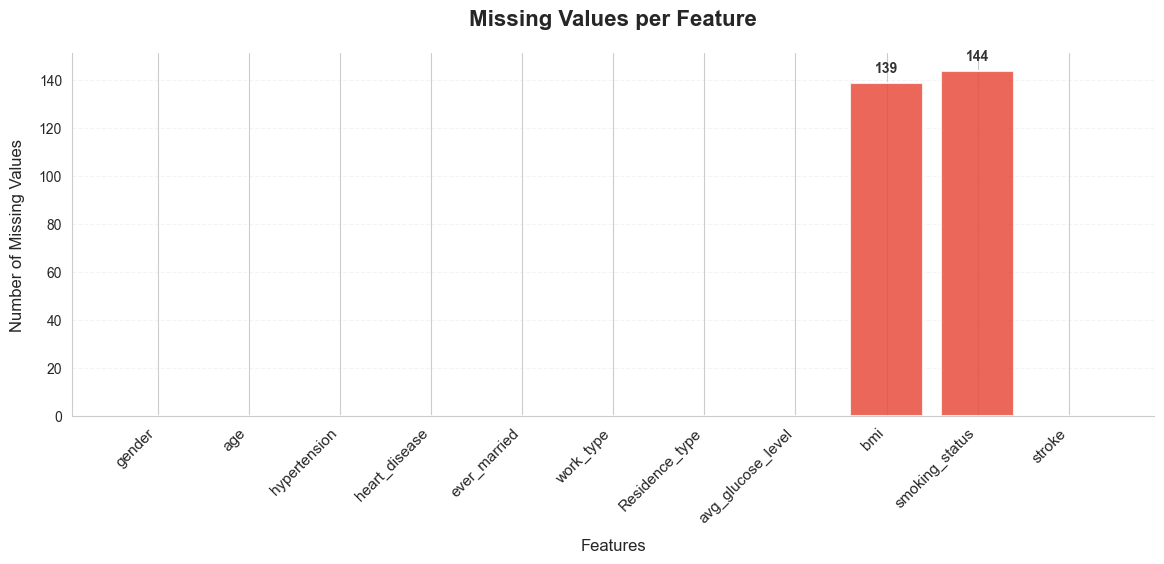


                   MISSING VALUES SUMMARY                   
+-------------------+----------------+------------+------------+
| Column            | Missing Values | Percentage | Status     |
+-------------------+----------------+------------+------------+
| gender            |              0 |       0.0% | ✓ Complete |
| age               |              0 |       0.0% | ✓ Complete |
| hypertension      |              0 |       0.0% | ✓ Complete |
| heart_disease     |              0 |       0.0% | ✓ Complete |
| ever_married      |              0 |       0.0% | ✓ Complete |
| work_type         |              0 |       0.0% | ✓ Complete |
| Residence_type    |              0 |       0.0% | ✓ Complete |
| avg_glucose_level |              0 |       0.0% | ✓ Complete |
| bmi               |            139 |       4.3% | ○ Review   |
| smoking_status    |            144 |       4.5% | ○ Review   |
| stroke            |              0 |       0.0% | ✓ Complete |
+-------------------+-------

In [639]:
# Calculate the number of missing values per column
missing_counts = df.isnull().sum()

# Create bar plot with improved styling
plt.figure(figsize=(12, 6))
bars = plt.bar(
    missing_counts.index,
    missing_counts.values,
    color="#e74c3c",  # More vibrant red
    alpha=0.85,
    edgecolor="white",
    linewidth=1.5,
)

# Title and labels with improved styling
plt.title("Missing Values per Feature", fontsize=16, fontweight="bold", pad=20)
plt.xlabel("Features", fontsize=12, labelpad=10)
plt.ylabel("Number of Missing Values", fontsize=12, labelpad=10)

# Rotated x-ticks with better spacing
plt.xticks(rotation=45, ha="right", fontsize=11)

# Add value labels with improved styling
for bar, value in zip(bars, missing_counts.values):
    if value > 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + max(missing_counts.values) * 0.02,  # Dynamic positioning
            f"{int(value)}",
            ha="center",
            va="bottom",
            fontweight="bold",
            fontsize=10,
            color="#333333",
        )

# Grid and layout improvements
plt.grid(axis="y", alpha=0.2, linestyle="--")
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout(pad=2)  # Slightly more padding
plt.show()

# Missing values summary table before handling
missing_table = PrettyTable()
missing_table.field_names = ["Column", "Missing Values", "Percentage", "Status"]
missing_table.align["Column"] = "l"
missing_table.align["Missing Values"] = "r"
missing_table.align["Percentage"] = "r"
missing_table.align["Status"] = "l"

# Add color formatting
GREEN = "\033[32m"
RED = "\033[31m"
YELLOW = "\033[33m"
RESET = "\033[0m"

# Add data to the table
for col, count in missing_counts.items():
    if count > 0:
        percentage = (count / len(df)) * 100
        status = (
            f"{RED}⚠ Needs attention{RESET}"
            if percentage > 5
            else f"{YELLOW}○ Review{RESET}"
        )
        missing_table.add_row(
            [col, f"{RED}{count}{RESET}", f"{RED}{percentage:.1f}%{RESET}", status]
        )
    else:
        missing_table.add_row(
            [
                col,
                f"{GREEN}0{RESET}",
                f"{GREEN}0.0%{RESET}",
                f"{GREEN}✓ Complete{RESET}",
            ]
        )

# Print the table
print("\n" + "=" * 64)
print(f"{' MISSING VALUES SUMMARY ':^60}")
print("=" * 64)
print(missing_table)
print(f"\nTotal rows in dataset: {len(df):,}")
print("=" * 64)

# Add legend
print("\nLEGEND:")
print(f"{GREEN}✓ Complete{RESET}: No missing values")
print(f"{YELLOW}○ Review{RESET}: <5% missing values")
print(f"{RED}⚠ Needs attention{RESET}: >5% missing values")

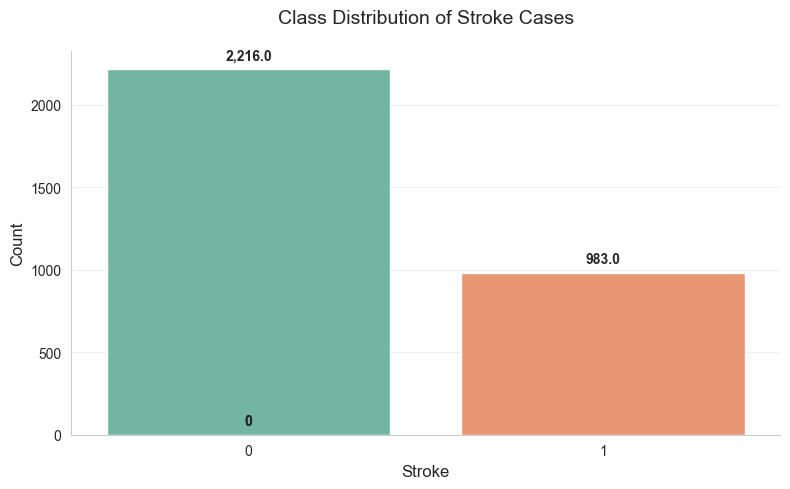

In [640]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x="stroke", data=df, hue="stroke", palette="Set2", dodge=False)

# Add counts on top of bars
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():,}",
        (p.get_x() + p.get_width() / 2.0, p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 10),
        textcoords="offset points",
        fontweight="bold",
    )

plt.title("Class Distribution of Stroke Cases", fontsize=14, pad=20)
plt.xlabel("Stroke", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend().remove()
plt.grid(axis="y", alpha=0.3)
sns.despine()
plt.tight_layout()
plt.show()

In [641]:
print(
    f"Imbalance ratio: 1:{df['stroke'].value_counts().iloc[0] / df['stroke'].value_counts().iloc[1]:.1f}"
)

Imbalance ratio: 1:2.3


In [642]:
# Check for non-numeric columns that might cause issues

unique_table = PrettyTable()
unique_table.field_names = ["Column Name", "Unique Values (First 5)"]
unique_table.align["Column Name"] = "l"
unique_table.align["Unique Values (First 5)"] = "l"

# Add data to the table
for col in df.columns:
    unique_values = df[col].unique()[:5]
    # Format the values for better display
    formatted_values = ", ".join([str(x) for x in unique_values])
    if len(df[col].unique()) > 5:
        formatted_values += ", ..."
    unique_table.add_row([col, formatted_values])

print("\n=== UNIQUE VALUES IN EACH COLUMN ===")
print(unique_table)
print(f"Total Columns: {len(df.columns)}")


=== UNIQUE VALUES IN EACH COLUMN ===
+-------------------+--------------------------------------------+
| Column Name       | Unique Values (First 5)                    |
+-------------------+--------------------------------------------+
| gender            | Female, Male                               |
| age               | 32, 38, 39, 45, 46, ...                    |
| hypertension      | 0, 1                                       |
| heart_disease     | 0, 1                                       |
| ever_married      | Yes, No                                    |
| work_type         | Private, Self-employed, Govt_job, children |
| Residence_type    | Rural, Urban                               |
| avg_glucose_level | 76.13, 82.28, 101.45, 58.09, 83.24, ...    |
| bmi               | 29.9, 24.0, 39.2, 26.3, 29.6, ...          |
| smoking_status    | smokes, formerly smoked, never smoked, nan |
| stroke            | 1, 0                                       |
+-------------------+---

#### Fill Missing Values

##### For numerical columns

In [643]:
numerical_cols = ["age", "avg_glucose_level", "bmi"]
df.fillna({col: df[col].median() for col in numerical_cols}, inplace=True)

In [644]:
categorical_cols = ["gender", "work_type", "Residence_type", "smoking_status", "stroke"]

for col in categorical_cols:
    # Group by 'stroke' and fill missing values with the mode of each group
    df[col] = df.groupby("stroke")[col].transform(lambda x: x.fillna(x.mode()[0]))

##### For Categorical Columns


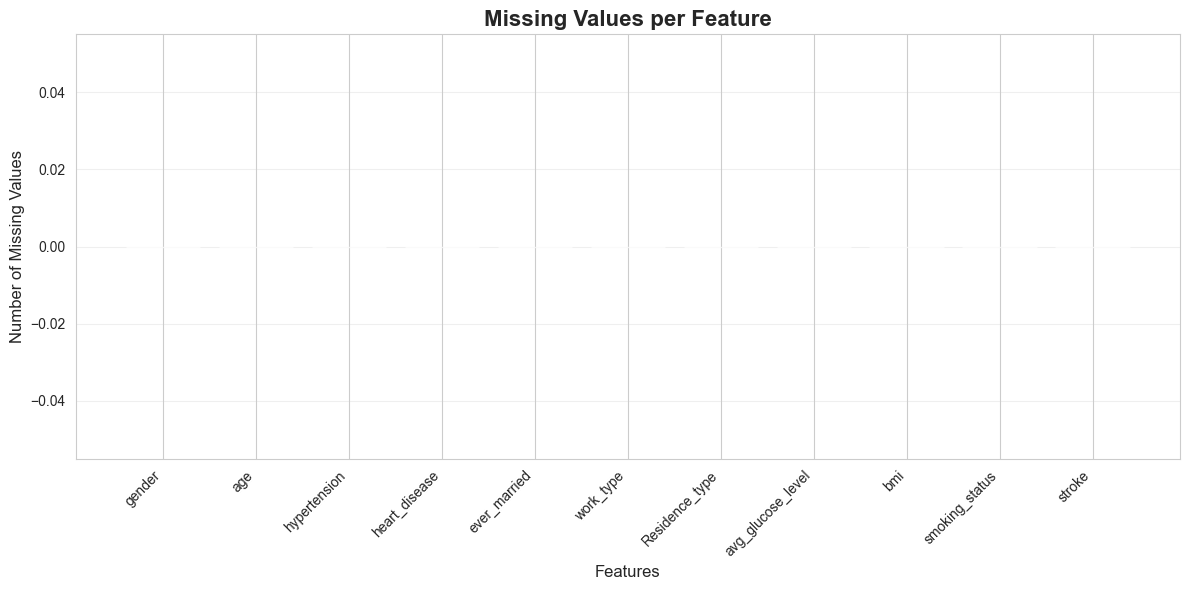


                   MISSING VALUES SUMMARY                   
+-------------------+----------------+------------+------------+
| Column            | Missing Values | Percentage | Status     |
+-------------------+----------------+------------+------------+
| gender            |              0 |       0.0% | ✓ Complete |
| age               |              0 |       0.0% | ✓ Complete |
| hypertension      |              0 |       0.0% | ✓ Complete |
| heart_disease     |              0 |       0.0% | ✓ Complete |
| ever_married      |              0 |       0.0% | ✓ Complete |
| work_type         |              0 |       0.0% | ✓ Complete |
| Residence_type    |              0 |       0.0% | ✓ Complete |
| avg_glucose_level |              0 |       0.0% | ✓ Complete |
| bmi               |              0 |       0.0% | ✓ Complete |
| smoking_status    |              0 |       0.0% | ✓ Complete |
| stroke            |              0 |       0.0% | ✓ Complete |
+-------------------+-------

In [645]:
# Create bar plot for missing values without using missingno
# Calculate the number of missing values per column
missing_counts = df.isnull().sum()

# Create bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(
    missing_counts.index, missing_counts.values, color="lightcoral", alpha=0.7
)
plt.title("Missing Values per Feature", fontsize=16, fontweight="bold")
plt.xlabel("Features", fontsize=12)
plt.ylabel("Number of Missing Values", fontsize=12)
plt.xticks(rotation=45, ha="right")

# Add value labels on top of bars
for bar, value in zip(bars, missing_counts.values):
    if value > 0:
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 5,
            str(int(value)),
            ha="center",
            va="bottom",
            fontweight="bold",
        )

plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# Summary of missing values after handling
missing_table = PrettyTable()
missing_table.field_names = ["Column", "Missing Values", "Percentage", "Status"]
missing_table.align["Column"] = "l"
missing_table.align["Missing Values"] = "r"
missing_table.align["Percentage"] = "r"
missing_table.align["Status"] = "l"

# Add color formatting
GREEN = "\033[32m"
RED = "\033[31m"
YELLOW = "\033[33m"
RESET = "\033[0m"

# Add data to the table
for col, count in missing_counts.items():
    if count > 0:
        percentage = (count / len(df)) * 100
        status = (
            f"{RED}⚠ Needs attention{RESET}"
            if percentage > 5
            else f"{YELLOW}○ Review{RESET}"
        )
        missing_table.add_row(
            [col, f"{RED}{count}{RESET}", f"{RED}{percentage:.1f}%{RESET}", status]
        )
    else:
        missing_table.add_row(
            [
                col,
                f"{GREEN}0{RESET}",
                f"{GREEN}0.0%{RESET}",
                f"{GREEN}✓ Complete{RESET}",
            ]
        )

# Print the table
print("\n" + "=" * 64)
print(f"{' MISSING VALUES SUMMARY ':^60}")
print("=" * 64)
print(missing_table)
print(f"\nTotal rows in dataset: {len(df):,}")
print("=" * 64)

# Add legend
print("\nLEGEND:")
print(f"{GREEN}✓ Complete{RESET}: No missing values")
print(f"{YELLOW}○ Review{RESET}: <5% missing values")
print(f"{RED}⚠ Needs attention{RESET}: >5% missing values")

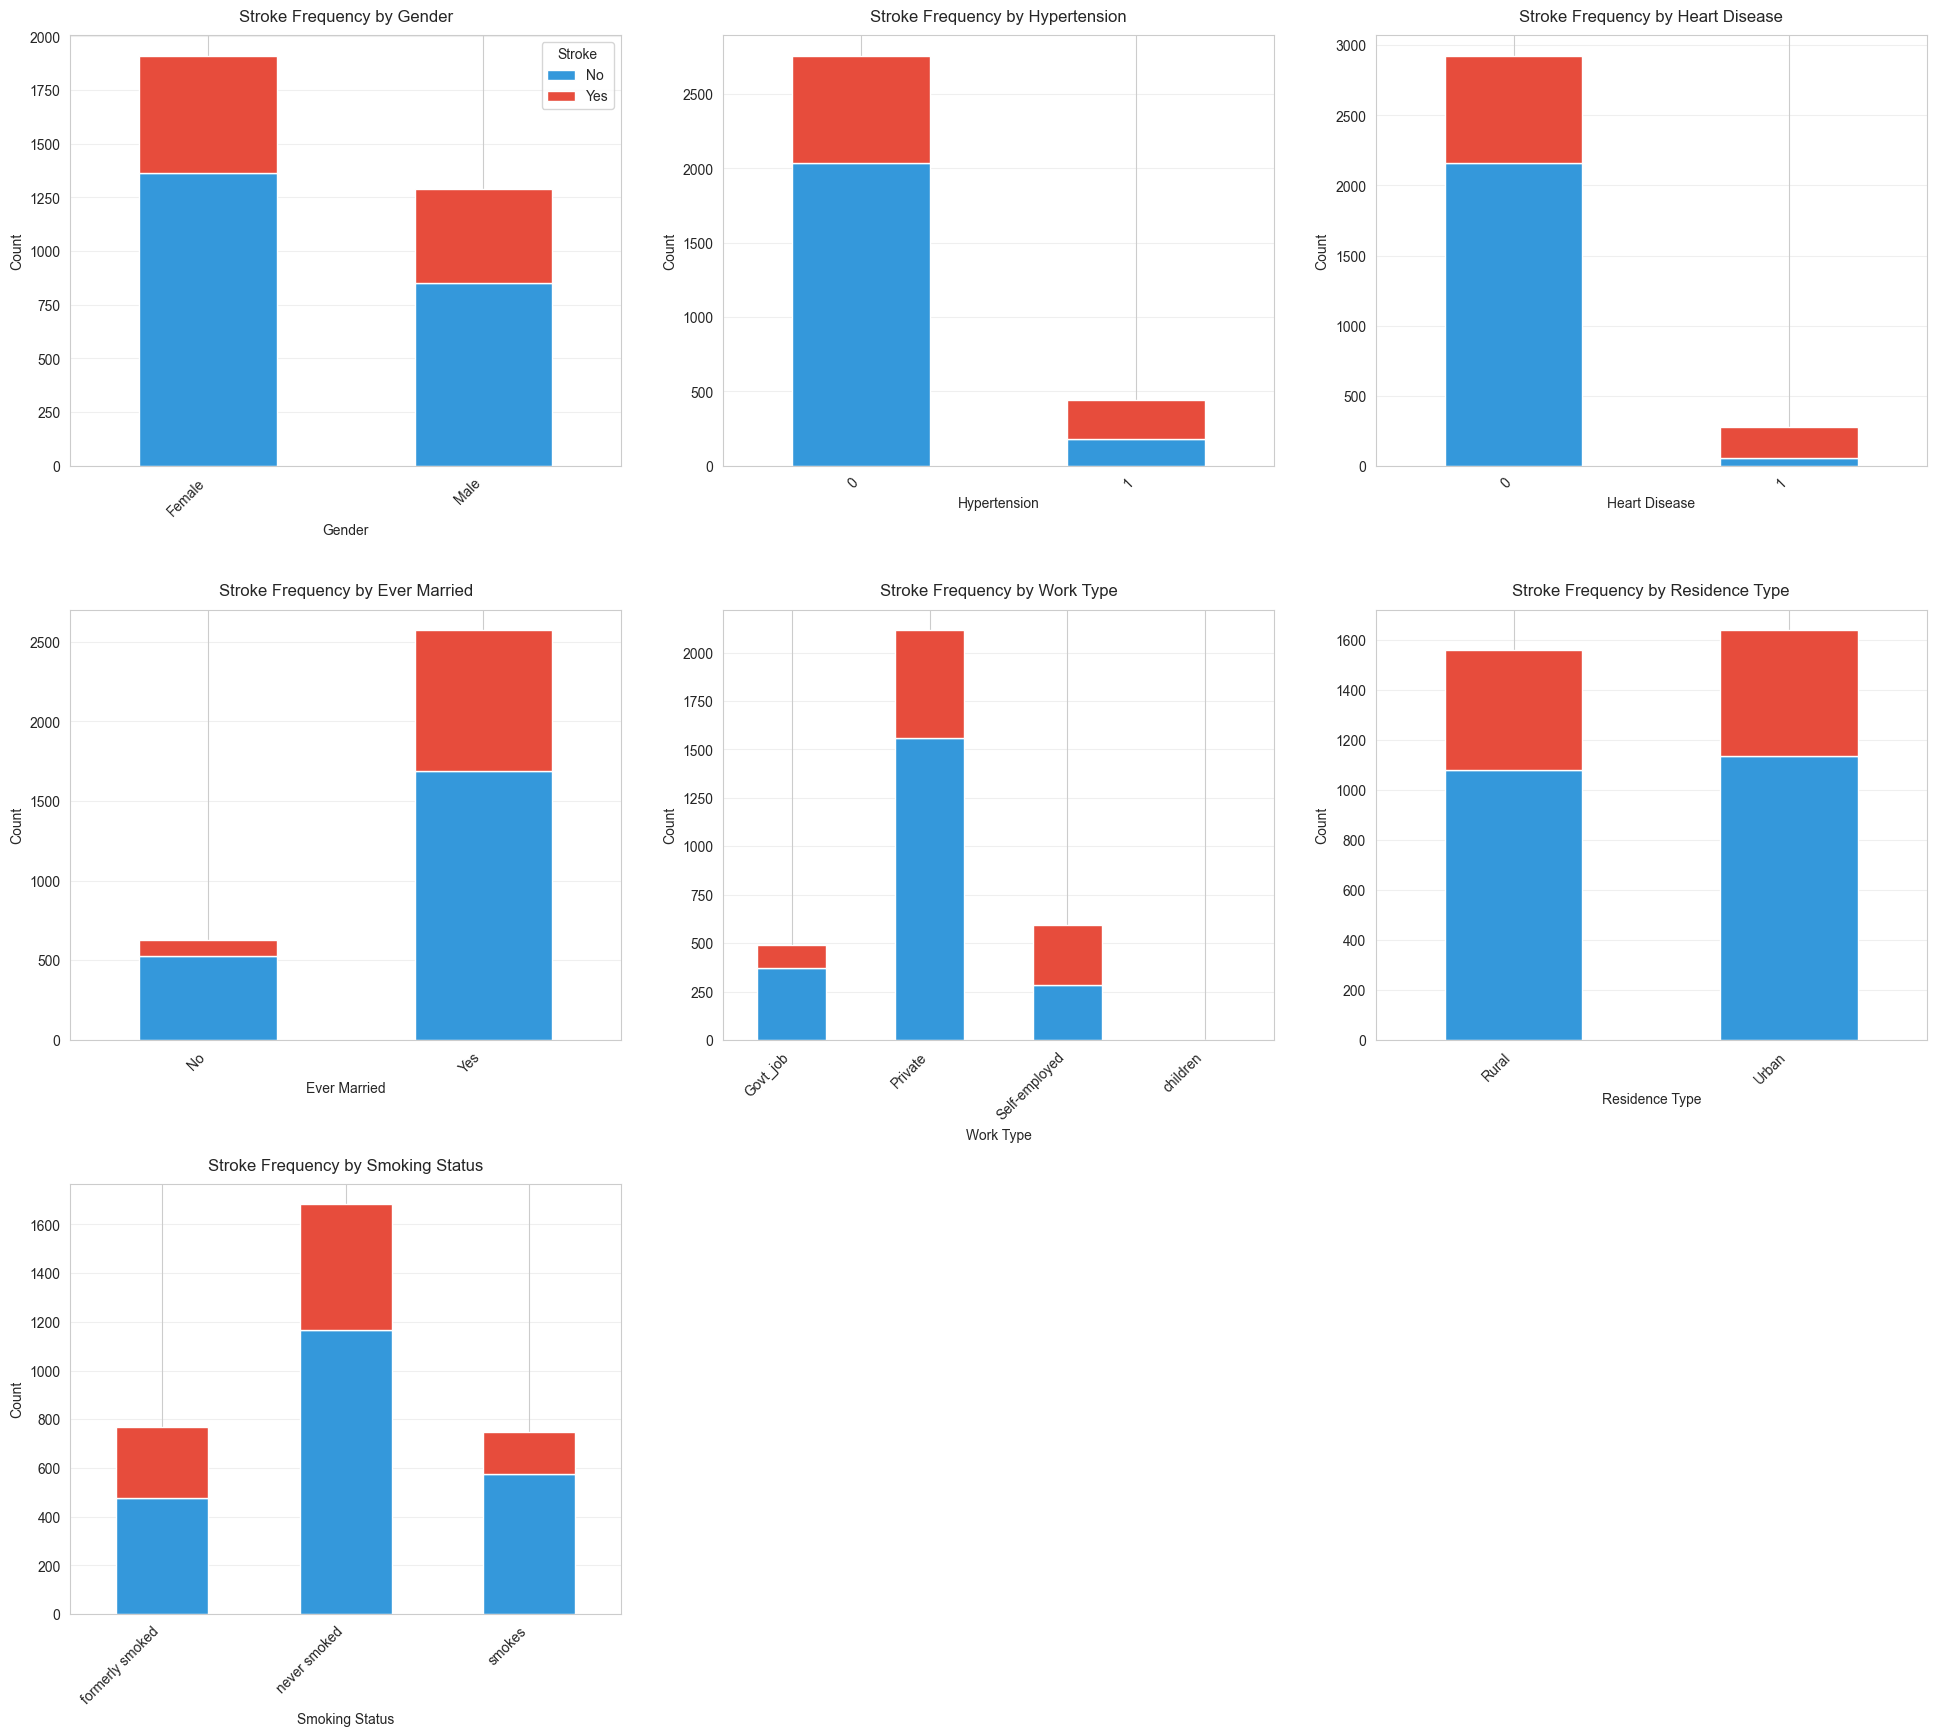

In [646]:
plt.figure(figsize=(20, 18))

categorical_features = [
    "gender",
    "hypertension",
    "heart_disease",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
]

for i, col in enumerate(categorical_features, 1):
    plt.subplot(3, 3, i)

    # Create stacked bar plot
    crosstab = pd.crosstab(df[col], df["stroke"])
    crosstab.plot(
        kind="bar", stacked=True, ax=plt.gca(), color=["#3498db", "#e74c3c"]
    )  # Blue for no stroke, red for stroke

    # Customize appearance
    plt.title(
        f"Stroke Frequency by {col.replace('_', ' ').title()}", fontsize=12, pad=10
    )
    plt.xlabel(col.replace("_", " ").title(), fontsize=10)
    plt.ylabel("Count", fontsize=10)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", alpha=0.3)

    # Add legend only for first plot to save space
    if i != 1:
        plt.legend().remove()
    else:
        plt.legend(title="Stroke", labels=["No", "Yes"], bbox_to_anchor=(1, 1))

# Adjust layout and remove empty subplots
plt.tight_layout(pad=3.0)
plt.show()

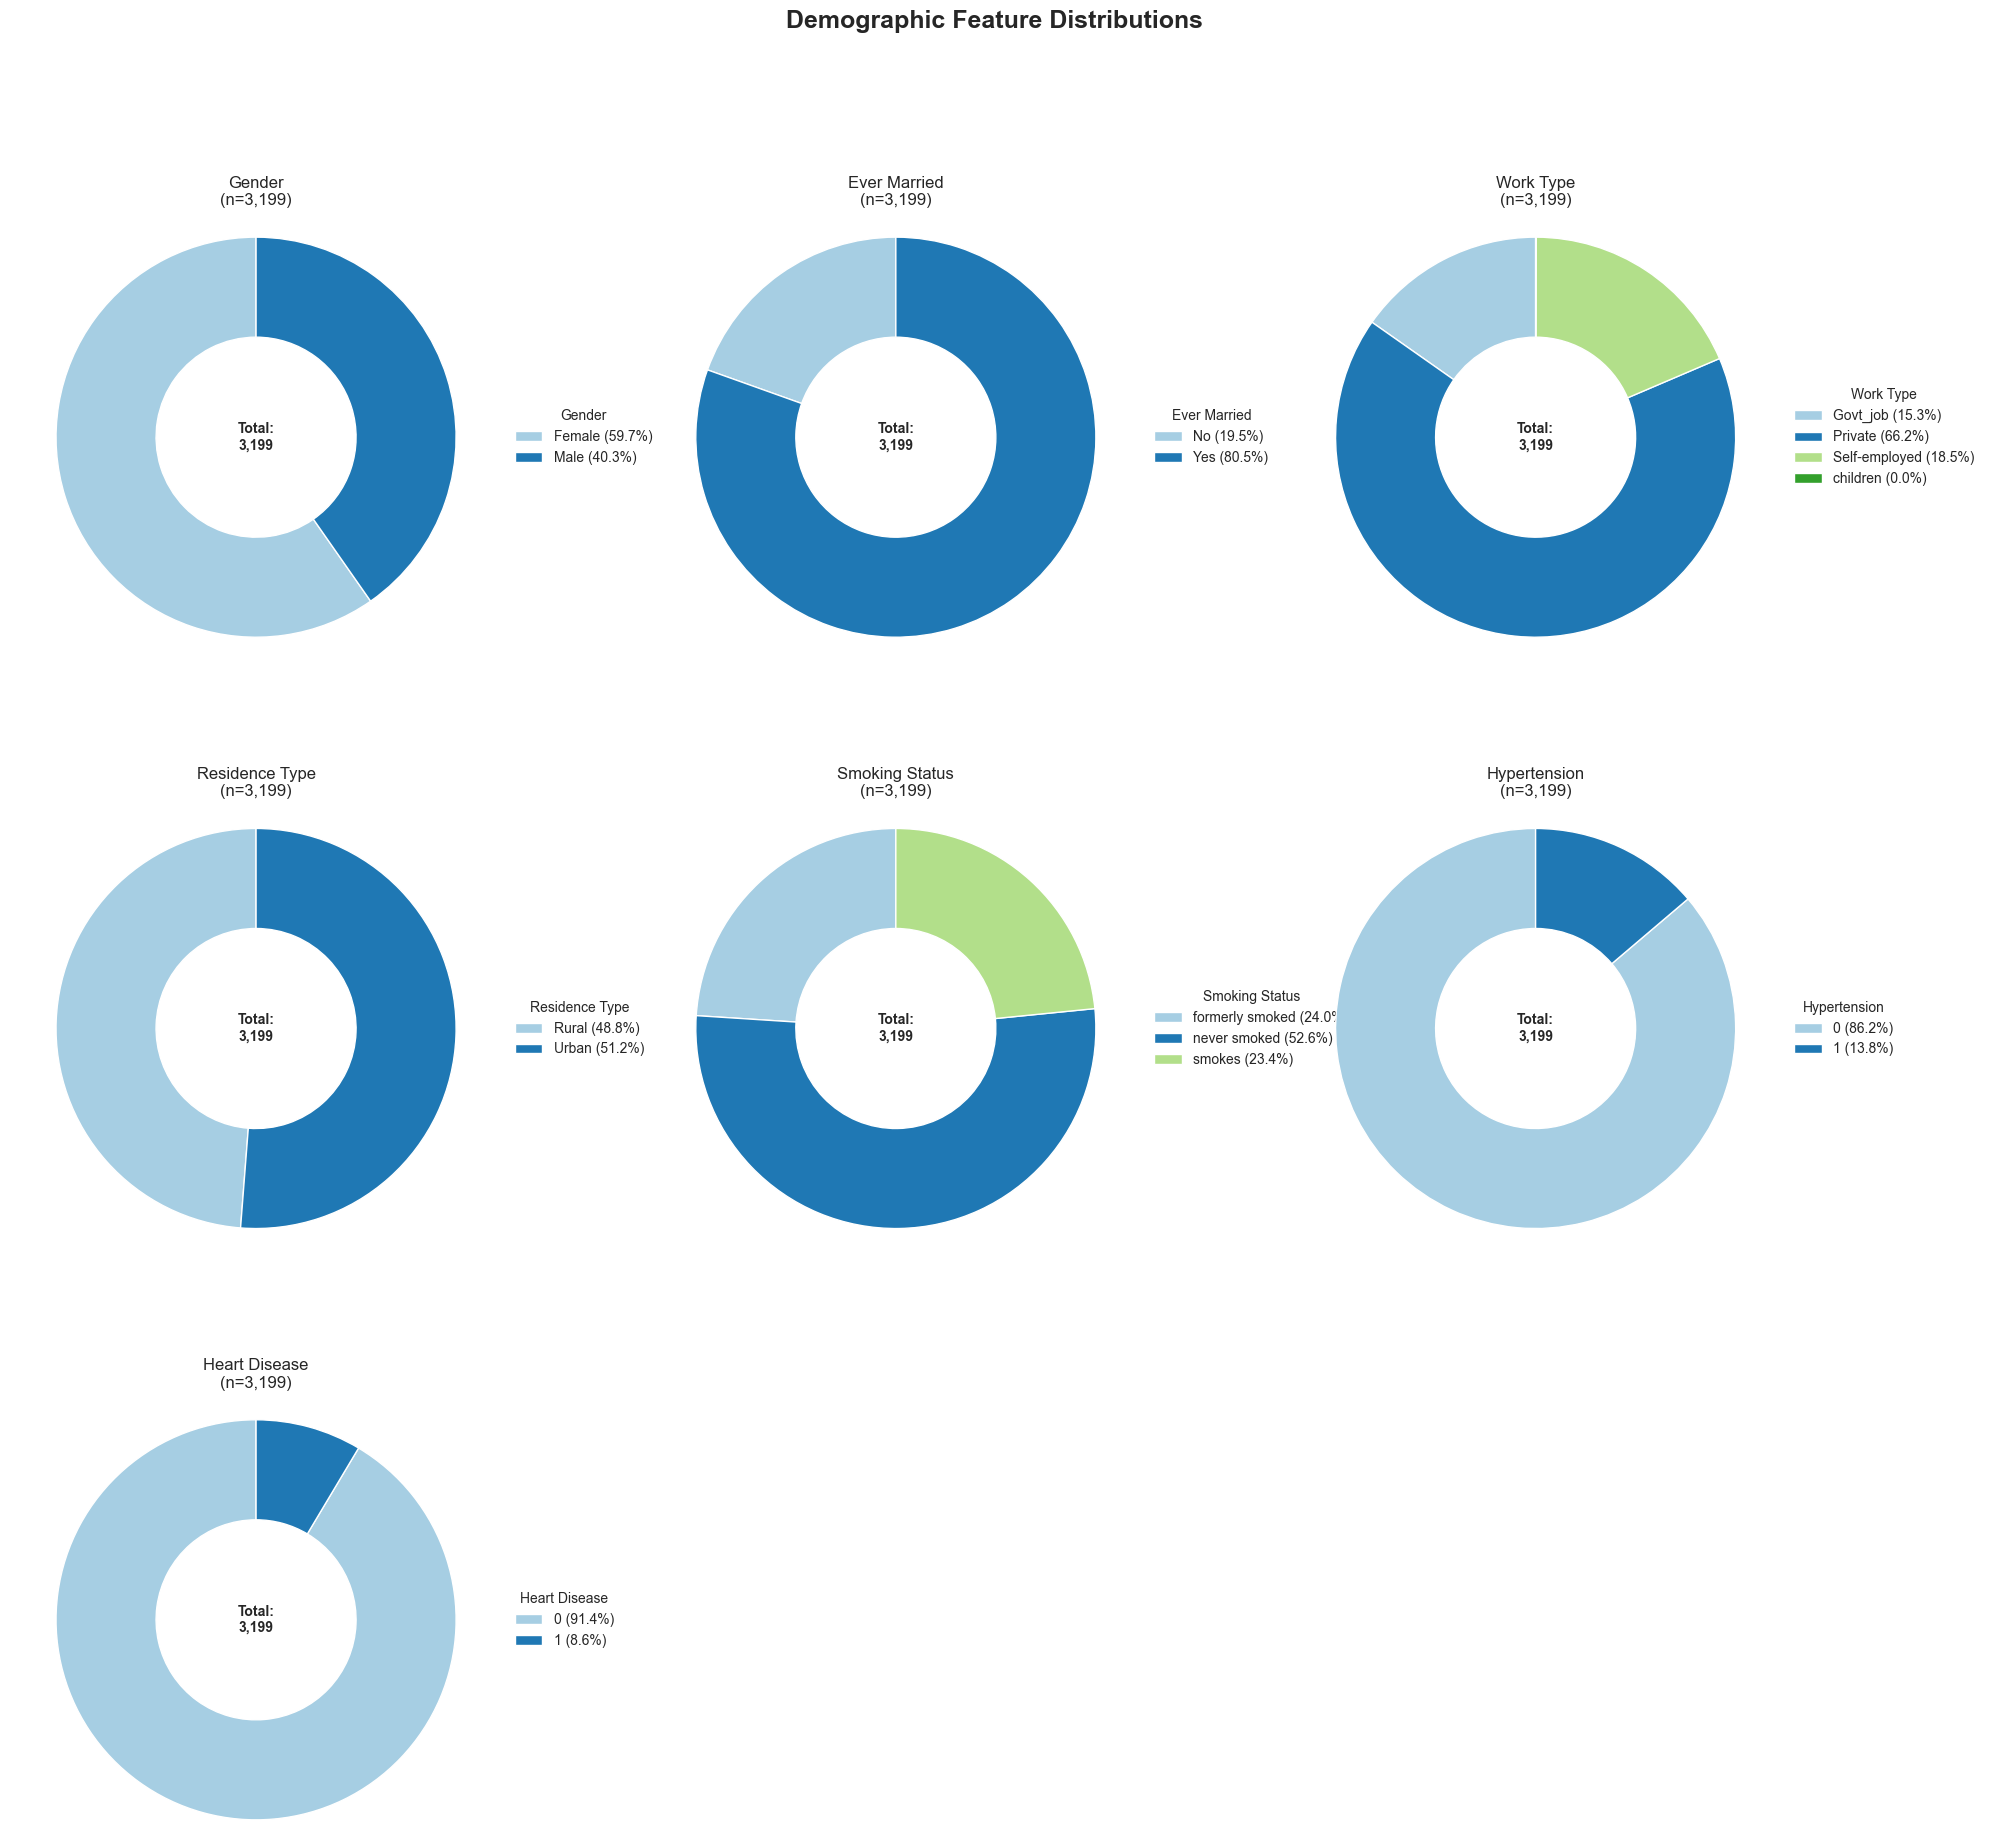

In [647]:
# Set up the figure and grid
plt.figure(figsize=(20, 18))
plt.suptitle(
    "Demographic Feature Distributions", y=1.02, fontsize=18, fontweight="bold"
)

demographic_cols = [
    "gender",
    "ever_married",
    "work_type",
    "Residence_type",
    "smoking_status",
    "hypertension",
    "heart_disease",
]

# Color palette
colors = plt.cm.Paired.colors

for i, col in enumerate(demographic_cols, 1):
    ax = plt.subplot(3, 3, i)

    # Get cross tabulation
    crosstab = pd.crosstab(df[col], df["stroke"])

    # Prepare data - handle zero counts
    data = crosstab.sum(axis=1).replace(0, 0.001).values
    labels = [f"{x}\n({val:,})" for x, val in zip(crosstab.index, data)]

    # Create donut chart
    wedges, _ = ax.pie(
        data, wedgeprops=dict(width=0.5), startangle=90, colors=colors[: len(data)]
    )

    # Add center text with total count
    center_circle = plt.Circle((0, 0), 0.3, fc="white")
    ax.add_artist(center_circle)
    ax.text(
        0,
        0,
        f"Total:\n{sum(data):,}",
        ha="center",
        va="center",
        fontsize=10,
        fontweight="bold",
    )

    # Equal aspect ratio ensures pie is drawn as a circle
    ax.axis("equal")

    # Add legend with percentages
    percents = 100.0 * data / data.sum()
    legend_labels = [f"{l} ({p:.1f}%)" for l, p in zip(crosstab.index, percents)]
    ax.legend(
        wedges,
        legend_labels,
        title=col.replace("_", " ").title(),
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        frameon=False,
    )

    # Title with sample size
    ax.set_title(
        f"{col.replace('_', ' ').title()}\n(n={sum(data):,})", pad=15, fontsize=12
    )

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9, wspace=0.3, hspace=0.4)
plt.show()

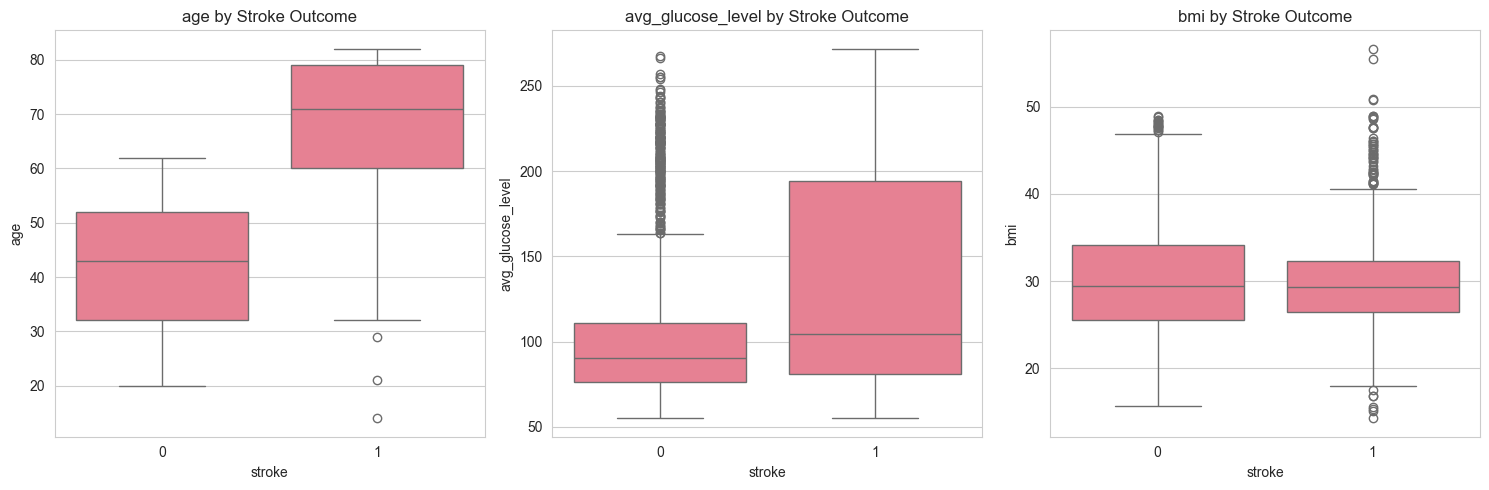

In [648]:
# Box Plots for Numerical Features
plt.figure(figsize=(15, 5))
for i, col in enumerate(["age", "avg_glucose_level", "bmi"]):
    plt.subplot(1, 3, i + 1)
    sns.boxplot(x="stroke", y=col, data=df)
    plt.title(f"{col} by Stroke Outcome")
plt.tight_layout()
plt.show()

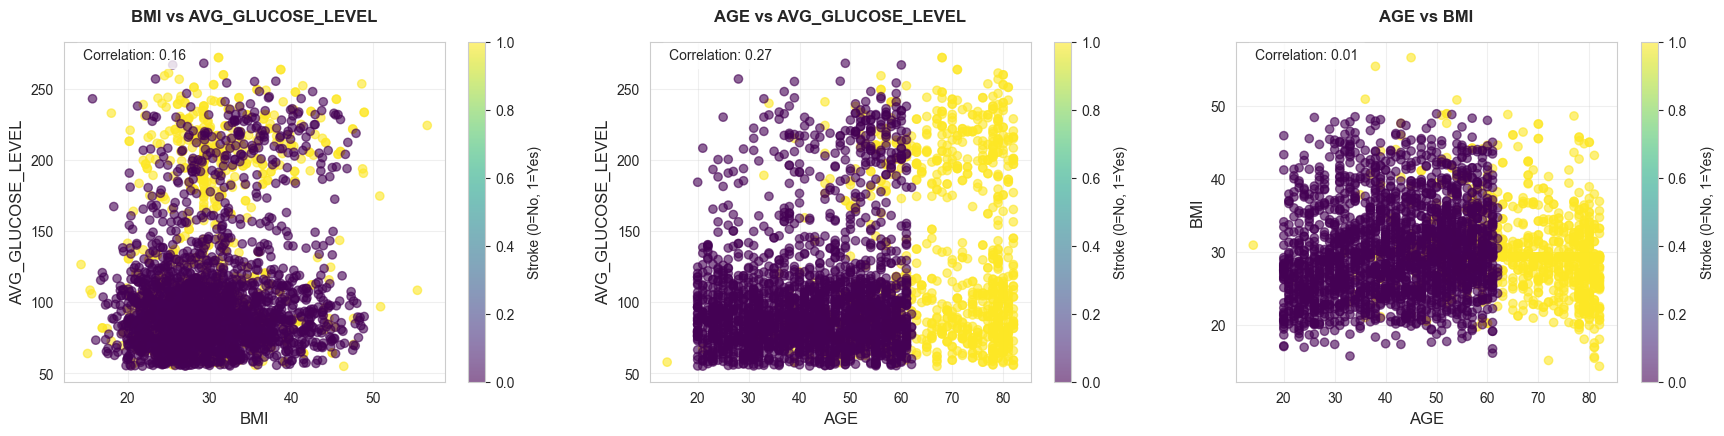

In [649]:
# Set up the figure with subplots
plt.figure(figsize=(18, 5))  # Wider figure to accommodate side-by-side plots

# Define the pairs to plot
pairs = [("bmi", "avg_glucose_level"), ("age", "avg_glucose_level"), ("age", "bmi")]

# Create subplots for each pair
for i, (col1, col2) in enumerate(pairs, 1):
    plt.subplot(1, 3, i)  # 1 row, 3 columns, current subplot position

    # Create scatter plot (keeping your original approach)
    scatter = plt.scatter(df[col1], df[col2], c=df["stroke"], cmap="viridis", alpha=0.6)

    # Add colorbar to the right of each plot
    cbar = plt.colorbar(scatter)
    cbar.set_label("Stroke (0=No, 1=Yes)", labelpad=10)

    # Customize appearance
    plt.xlabel(col1.upper(), fontsize=12)
    plt.ylabel(col2.upper(), fontsize=12)
    plt.title(f"{col1.upper()} vs {col2.upper()}", pad=15, fontweight="bold")
    plt.grid(True, alpha=0.3)

    # Add correlation coefficient
    corr = df[[col1, col2]].corr().iloc[0, 1]
    plt.text(
        0.05,
        0.95,
        f"Correlation: {corr:.2f}",
        transform=plt.gca().transAxes,
        bbox=dict(facecolor="white", alpha=0.8),
    )

plt.tight_layout(pad=3.0)  # Adjust spacing between subplots
plt.show()

#### Outlier Detection and Handling

In [650]:
def detect_and_handle_outliers(df, column):
    # Store original values for comparison
    original_values = df[column].copy()

    # Calculate bounds
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    print(f"Number of outliers in {column}: {len(outliers)}")

    # Cap outliers
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    # Compare before and after statistics
    print(f"\nStatistics for {column} before vs after handling outliers:")
    compare_stats = pd.DataFrame(
        {"Before": original_values.describe(), "After": df[column].describe()}
    )
    print(compare_stats)

    if column in ["avg_glucose_level", "bmi"]:
        # Create better-looking visualizations with side-by-side comparisons
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Only 2 subplots now

    # --- Box Plot (Before vs. After in one subplot) ---
    sns.boxplot(
        data=[original_values, df[column]],
        palette=["skyblue", "lightgreen"],
        ax=axes[0],
    )
    axes[0].set_xticklabels(["Before", "After"])
    axes[0].set_title(f"Box Plot Comparison: {column}", fontsize=12)
    axes[0].set_ylabel(f"{column} values")

    # --- Histogram (Before vs. After in one subplot) ---
    sns.histplot(original_values, kde=True, color="skyblue", label="Before", ax=axes[1])
    sns.histplot(df[column], kde=True, color="lightgreen", label="After", ax=axes[1])
    axes[1].set_title(f"Distribution Comparison: {column}", fontsize=12)
    axes[1].set_xlabel(f"{column} values")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    return df


                       CHI-SQUARE TEST RESULTS                        
+----------------+-----------+---------+---------------+--------------+
| Feature        | Chi2 Stat | p-value | Sig. (p<0.05) | Effect Size* |
+----------------+-----------+---------+---------------+--------------+
| Gender         |     10.47 |  0.0012 |     ✓ Yes     |        0.057 |
| Hypertension   |    196.13 |  0.0000 |     ✓ Yes     |        0.248 |
| Heart Disease  |    323.30 |  0.0000 |     ✓ Yes     |        0.318 |
| Ever Married   |     78.30 |  0.0000 |     ✓ Yes     |        0.156 |
| Work Type      |    158.22 |  0.0000 |     ✓ Yes     |        0.222 |
| Residence Type |      0.00 |  1.0000 |      ✗ No     |        0.000 |
| Smoking Status |     37.82 |  0.0000 |     ✓ Yes     |        0.109 |
+----------------+-----------+---------+---------------+--------------+

*Effect Size measured by Cramer's V (0.1=small, 0.3=medium, 0.5=large)
------------------------------ Legend: -------------------------

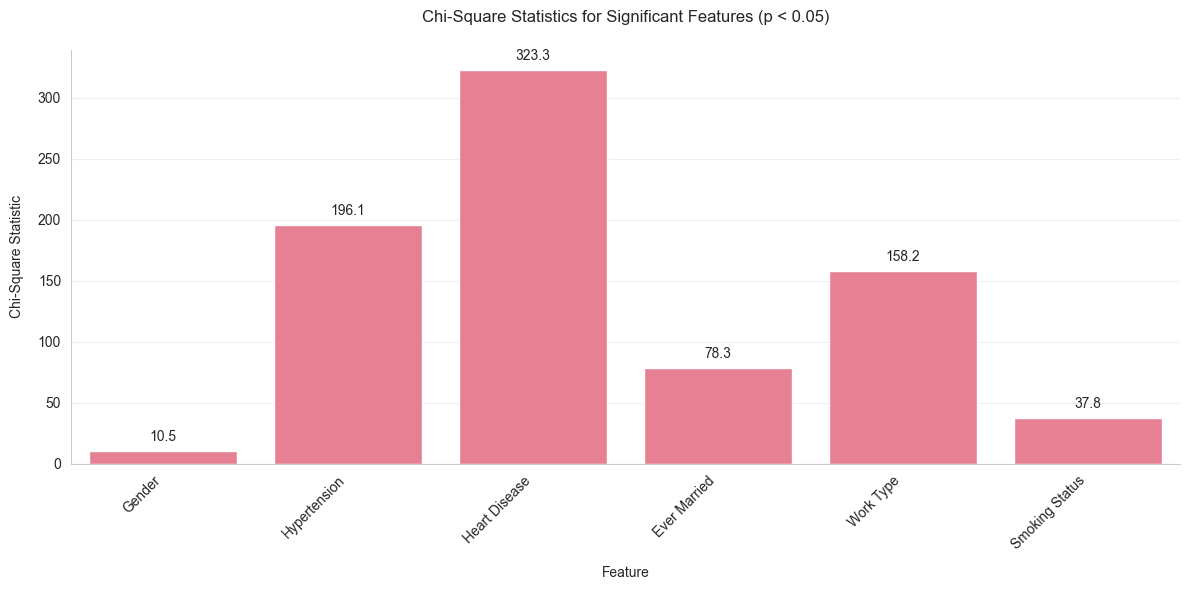

In [ ]:
from scipy.stats import chi2_contingency

# Initialize PrettyTable
chi2_table = PrettyTable()
chi2_table.field_names = [
    "Feature",
    "Chi2 Stat",
    "p-value",
    "Sig. (p<0.05)",
    "Effect Size*",
]

# Alignment settings
chi2_table.align["Feature"] = "l"
chi2_table.align["Chi2 Stat"] = "r"
chi2_table.align["p-value"] = "r"
chi2_table.align["Sig. (p<0.05)"] = "c"
chi2_table.align["Effect Size*"] = "r"

# Color formatting
RED = "\033[31m"
GREEN = "\033[32m"
YELLOW = "\033[33m"
RESET = "\033[0m"

print("\n" + "=" * 70)
print(f"{' CHI-SQUARE TEST RESULTS ':^70}")
print("=" * 70)

# Collect results for DataFrame
chi2_results = []

for feature in categorical_features:
    contingency_table = pd.crosstab(df[feature], df["stroke"])
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    # Calculate effect size (Cramer's V)
    n = contingency_table.sum().sum()
    effect_size = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

    # Formatting based on significance
    sig_indicator = f"{GREEN}✓ Yes{RESET}" if p < 0.05 else f"{RED}✗ No{RESET}"
    p_format = f"{YELLOW}{p:.4f}{RESET}" if p < 0.1 else f"{p:.4f}"

    chi2_table.add_row(
        [
            feature.replace("_", " ").title(),
            f"{chi2:.2f}",
            p_format,
            sig_indicator,
            f"{effect_size:.3f}",
        ]
    )

    # Store for DataFrame (without color codes for plotting)
    chi2_results.append(
        {
            "Feature": feature.replace("_", " ").title(),
            "Chi2 Statistic": chi2,
            "p-value": p,
            "Significant (p < 0.05)": p < 0.05,
            "Effect Size": effect_size,
        }
    )

# Create DataFrame for further analysis/plotting
chi2_df = pd.DataFrame(chi2_results)

# Print the table
print(chi2_table)
print("\n*Effect Size measured by Cramer's V (0.1=small, 0.3=medium, 0.5=large)")
print(f"{' Legend: ':-^70}")
print(
    f"{GREEN}✓ Yes{RESET} = Significant | {RED}✗ No{RESET} = Not Significant | {YELLOW}p-value{RESET} = Marginal significance"
)
print("=" * 70)

# Visualize significant features
significant_features = chi2_df[chi2_df["Significant (p < 0.05)"]]
if not significant_features.empty:
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        x="Feature", y="Chi2 Statistic", data=significant_features, legend=False
    )

    # Add value labels
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():.1f}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

    plt.title("Chi-Square Statistics for Significant Features (p < 0.05)", pad=20)
    plt.xlabel("Feature", labelpad=10)
    plt.ylabel("Chi-Square Statistic", labelpad=10)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", alpha=0.3)
    sns.despine()
    plt.tight_layout()
    plt.show()
else:
    print(
        f"\n{RED}No features showed statistically significant association with stroke (p < 0.05){RESET}"
    )


              ANOVA TEST RESULTS (STROKE vs NON-STROKE)               
+-------------------+-------------+---------+--------------+
| Feature           | F-statistic | P-value | Significance |
+-------------------+-------------+---------+--------------+
| AGE               |     3289.07 |  <0.001 |     YES      |
| AVG_GLUCOSE_LEVEL |      225.99 |  <0.001 |     YES      |
| BMI               |        1.83 |  0.1760 |      NO      |
+-------------------+-------------+---------+--------------+

----------------------------------------------------------------------
Significance level: p < 0.05


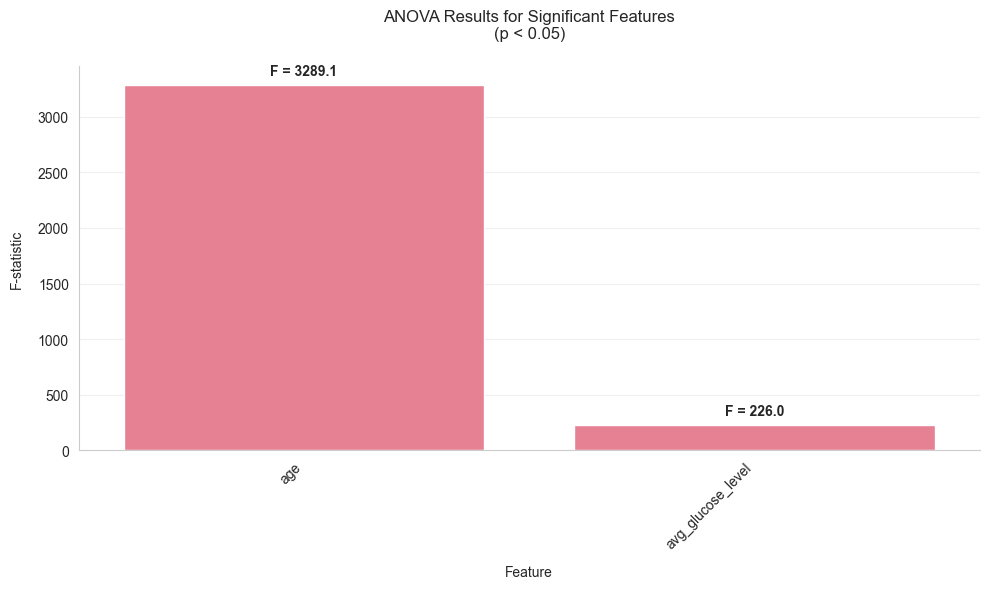

In [ ]:
numerical_features = ["age", "avg_glucose_level", "bmi"]

# Initialize PrettyTable
anova_table = PrettyTable()
anova_table.field_names = ["Feature", "F-statistic", "P-value", "Significance"]
anova_table.align["Feature"] = "l"
anova_table.align["F-statistic"] = "r"
anova_table.align["P-value"] = "r"
anova_table.align["Significance"] = "c"
anova_table.float_format = ".4"  # 4 decimal places for numbers

# Color formatting
GREEN = "\033[32m"
RED = "\033[31m"
YELLOW = "\033[33m"
RESET = "\033[0m"

print("\n" + "=" * 70)
print(f"{' ANOVA TEST RESULTS (STROKE vs NON-STROKE) ':^70}")
print("=" * 70)

anova_results = []

for feature in numerical_features:
    # Original analysis code remains the same
    group1 = df[df["stroke"] == 0][feature].dropna()
    group2 = df[df["stroke"] == 1][feature].dropna()

    f_stat, p_value = f_oneway(group1, group2)

    # Formatting based on significance
    if p_value < 0.001:
        p_format = f"{RED}<0.001{RESET}"
    else:
        p_format = f"{p_value:.4f}"

    significance = f"{GREEN}YES{RESET}" if p_value < 0.05 else f"{RED}NO{RESET}"

    anova_table.add_row([feature.upper(), f"{f_stat:.2f}", p_format, significance])

    # Store original results (unchanged)
    anova_results.append(
        {
            "Feature": feature,
            "F-statistic": f_stat,
            "P-value": p_value,
            "Significant (p < 0.05)": p_value < 0.05,
        }
    )

# Print the table
print(anova_table)
print("\n" + "-" * 70)
print("Significance level: p < 0.05")
print("=" * 70)

# Original visualization code remains the same
anova_df = pd.DataFrame(anova_results)
significant_num_features = anova_df[anova_df["Significant (p < 0.05)"]]

if not significant_num_features.empty:
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(
        x="Feature",
        y="F-statistic",
        data=significant_num_features,
    )

    # Add value labels
    for p in ax.patches:
        ax.annotate(
            f"F = {p.get_height():.1f}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
            fontweight="bold",
        )

    plt.title("ANOVA Results for Significant Features\n(p < 0.05)", pad=20)
    plt.xlabel("Feature", labelpad=10)
    plt.ylabel("F-statistic", labelpad=10)
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", alpha=0.3)
    sns.despine()
    plt.tight_layout()
    plt.show()
else:
    print(
        f"\n{RED}No features showed statistically significant differences (p < 0.05){RESET}"
    )

In [653]:
object_columns = df.select_dtypes(include=["object"]).columns.tolist()
print(f"\nColumns with object dtype: {object_columns}")


Columns with object dtype: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [654]:
binary_columns = []
for col in df.columns:
    if df[col].dtype == "object":
        unique_vals = df[col].unique()
        if len(unique_vals) == 2 and set(unique_vals) == {"Yes", "No"}:
            binary_columns.append(col)
            df[col] = df[col].map({"Yes": 1, "No": 0})

In [655]:
le_dict = {}
encoding_table = PrettyTable()
encoding_table.field_names = ["Feature", "Category", "Encoded Value"]
encoding_table.align["Feature"] = "l"
encoding_table.align["Category"] = "l"
encoding_table.align["Encoded Value"] = "r"

print("\n" + "=" * 60)
print(f"{' LABEL ENCODING SUMMARY ':^60}")
print("=" * 60)

for col in object_columns:
    if col not in binary_columns:  # Skip already converted binary columns
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le  # Save encoder for future reference

        # Add encoding mapping to table
        for category, encoded_val in zip(le.classes_, le.transform(le.classes_)):
            encoding_table.add_row([col, str(category), encoded_val])

        # Add separator between features
        if col != object_columns[-1]:
            encoding_table.add_row(["─" * 30, "─" * 30, "─" * 10])

print(encoding_table)
print("\nLegend:")
print(
    "- Each feature shows the mapping from original categories to encoded numerical values"
)
print("- Features with only two categories were already converted to binary (0/1)")
print("=" * 60)


                   LABEL ENCODING SUMMARY                   
+--------------------------------+--------------------------------+---------------+
| Feature                        | Category                       | Encoded Value |
+--------------------------------+--------------------------------+---------------+
| gender                         | Female                         |             0 |
| gender                         | Male                           |             1 |
| ────────────────────────────── | ────────────────────────────── |    ────────── |
| work_type                      | Govt_job                       |             0 |
| work_type                      | Private                        |             1 |
| work_type                      | Self-employed                  |             2 |
| work_type                      | children                       |             3 |
| ────────────────────────────── | ────────────────────────────── |    ────────── |
| Residence_ty

In [656]:
for col in binary_columns:
    if col not in categorical_cols and col != "stroke":
        categorical_cols.append(col)

In [657]:
# Convert categorical variables to numerical using Label Encoding
print("\n--- Converting Categorical Data to Numerical ---")
le_dict = {}



--- Converting Categorical Data to Numerical ---


In [658]:
for col in categorical_cols:
    if df[col].dtype == "object":  # Only encode columns that are still objects
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        le_dict[col] = le  # Save encoder for future reference
        print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")


In [659]:
remaining_objects = df.select_dtypes(include=["object"]).columns.tolist()
if remaining_objects:
    print(
        f"\nWARNING: Still have object columns that need conversion: {remaining_objects}"
    )
    for col in remaining_objects:
        print(f"Values in {col}: {df[col].unique()}")
        if col != "stroke":  # Don't convert the target if it's already numeric
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            print(f"Encoded {col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

In [660]:
df = df.apply(pd.to_numeric, errors="coerce")

In [661]:
if df.isnull().sum().sum() > 0:
    print(
        "\nWARNING: NaN values found after conversion. Filling with appropriate values."
    )
    df = df.fillna(df.mean())

In [662]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(df.drop("stroke", axis=1), df["stroke"])
df_resampled = pd.DataFrame(X_resampled, columns=df.drop("stroke", axis=1).columns)
df_resampled["stroke"] = y_resampled

In [663]:
scaler = StandardScaler()  # Creates scaler with default range [0,1]
numerical_cols = ["age", "avg_glucose_level", "bmi"]
df_resampled[numerical_cols] = scaler.fit_transform(df_resampled[numerical_cols])


               CORRELATION MATRIX (AFTER RESAMPLING AND SCALING)                
+-------------------+--------+-------+--------------+---------------+--------------+-----------+----------------+-------------------+-------+----------------+--------+
|      Feature      | gender |  age  | hypertension | heart_disease | ever_married | work_type | Residence_type | avg_glucose_level |  bmi  | smoking_status | stroke |
+-------------------+--------+-------+--------------+---------------+--------------+-----------+----------------+-------------------+-------+----------------+--------+
|       gender      |  1.00  | -0.03 |     0.03     |      0.13     |     0.04     |    0.03   |      0.03      |        0.03       |  0.05 |     -0.00      | -0.06  |
|        age        | -0.03  |  1.00 |     0.19     |      0.22     |     0.28     |    0.13   |     -0.10      |        0.26       | -0.06 |     -0.24      |  0.74  |
|    hypertension   |  0.03  |  0.19 |     1.00     |      0.11     |     0.05

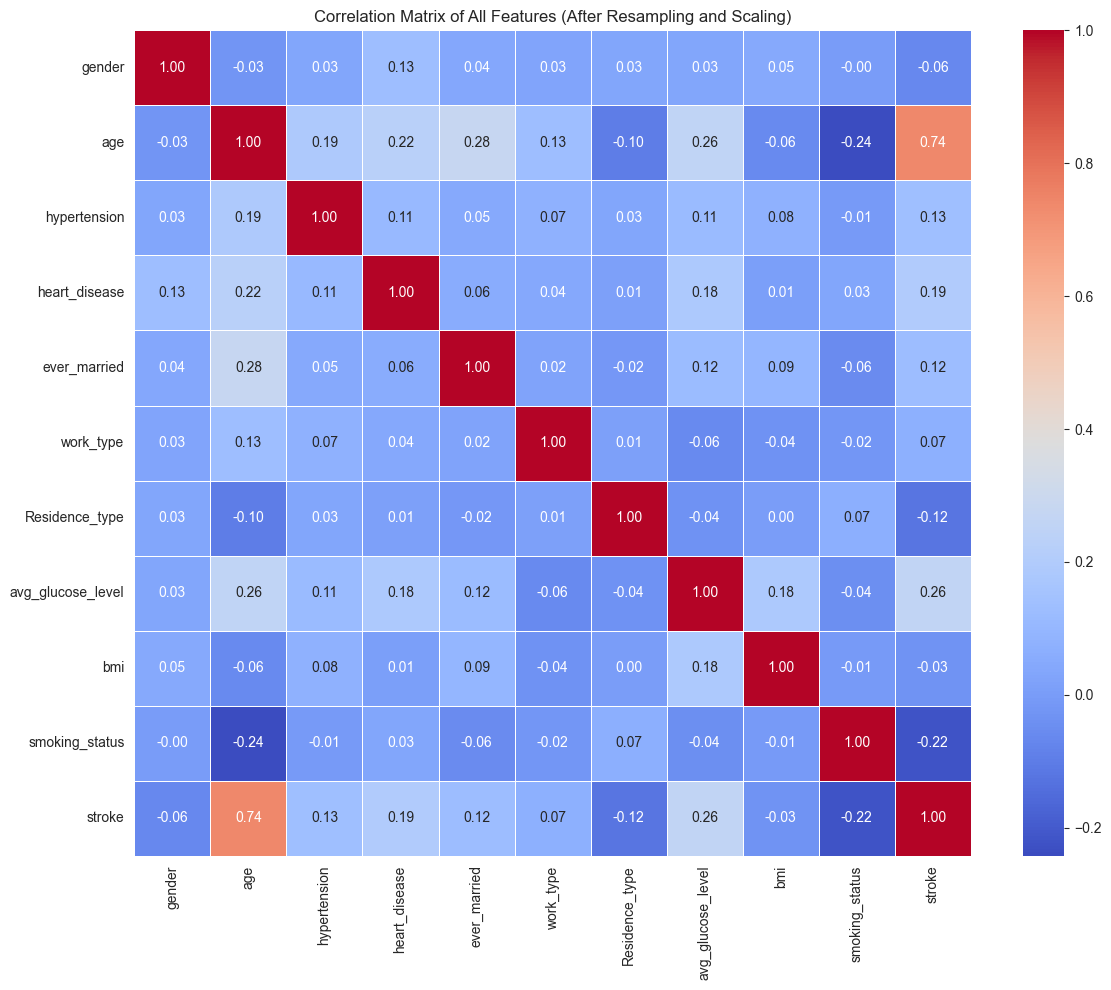


                    FEATURE CORRELATION WITH TARGET (STROKE)                    
+-------------------+-------------------------+
| Feature           | Correlation with Stroke |
+-------------------+-------------------------+
| stroke            |                   1.000 |
| age               |                   0.738 |
| avg_glucose_level |                   0.260 |
| heart_disease     |                   0.195 |
| hypertension      |                   0.134 |
| ever_married      |                   0.122 |
| work_type         |                   0.073 |
| bmi               |                  -0.033 |
| gender            |                  -0.063 |
| Residence_type    |                  -0.124 |
| smoking_status    |                  -0.222 |
+-------------------+-------------------------+

Correlation Strength Guide:
|r| ≥ 0.5: Strong | 0.3 ≤ |r| < 0.5: Moderate | |r| < 0.3: Weak


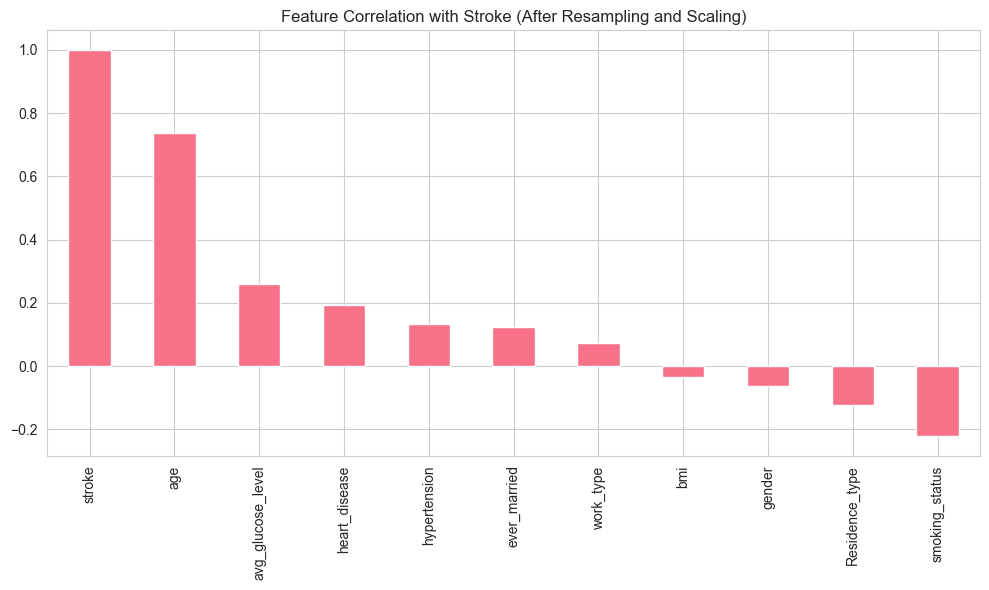

In [664]:
# Correlation matrix (keeping your original approach)
correlation_matrix = df_resampled.corr()

# 1. Print correlation matrix with PrettyTable
print("\n" + "=" * 80)
print(f"{' CORRELATION MATRIX (AFTER RESAMPLING AND SCALING) ':^80}")
print("=" * 80)

# Create PrettyTable for correlation matrix
corr_table = PrettyTable()
corr_table.field_names = ["Feature"] + list(correlation_matrix.columns)
corr_table.float_format = ".2"  # 2 decimal places for all numbers

# Add rows to the table
for feature in correlation_matrix.index:
    row = [feature] + [
        correlation_matrix.loc[feature, col] for col in correlation_matrix.columns
    ]
    corr_table.add_row(row)

print(corr_table)

# 2. Heatmap visualization (unchanged)
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of All Features (After Resampling and Scaling)")
plt.tight_layout()
plt.show()

# 3. Target correlation with PrettyTable
target_correlation = correlation_matrix["stroke"].sort_values(ascending=False)

print("\n" + "=" * 80)
print(f"{' FEATURE CORRELATION WITH TARGET (STROKE) ':^80}")
print("=" * 80)

# Create PrettyTable for target correlation
target_table = PrettyTable()
target_table.field_names = ["Feature", "Correlation with Stroke"]
target_table.align["Feature"] = "l"
target_table.align["Correlation with Stroke"] = "r"
target_table.float_format = ".3"  # 3 decimal places

# Add color coding based on correlation strength
for feature, corr in target_correlation.items():
    if abs(corr) >= 0.5:
        color = "\033[31m"  # Red for strong correlation
    elif abs(corr) >= 0.3:
        color = "\033[33m"  # Yellow for moderate correlation
    else:
        color = "\033[32m"  # Green for weak correlation

    target_table.add_row([feature, f"{color}{corr:.3f}\033[0m"])

print(target_table)
print("\nCorrelation Strength Guide:")
print(
    "\033[31m|r| ≥ 0.5: Strong\033[0m | \033[33m0.3 ≤ |r| < 0.5: Moderate\033[0m | \033[32m|r| < 0.3: Weak\033[0m"
)
print("=" * 80)

# 4. Bar plot visualization (unchanged)
plt.figure(figsize=(10, 6))
target_correlation.plot(kind="bar")
plt.title("Feature Correlation with Stroke (After Resampling and Scaling)")
plt.tight_layout()
plt.show()

In [665]:
print("\n" + "=" * 80)
print(f"{' CORRELATION MATRIX ':^80}")
print("=" * 80)

# Create PrettyTable
corr_table = PrettyTable()
corr_table.field_names = ["Feature"] + list(correlation_matrix.columns)
corr_table.float_format = ".2"  # Show 2 decimal places

# Add color formatting
RED = "\033[91m"
GREEN = "\033[92m"
BLUE = "\033[94m"
RESET = "\033[0m"

# Add rows to the table
for feature in correlation_matrix.index:
    row = [f"{BLUE}{feature}{RESET}"]  # Color feature names blue
    for col in correlation_matrix.columns:
        val = correlation_matrix.loc[feature, col]
        if abs(val) >= 0.7:
            color = RED  # Strong correlation
        elif abs(val) >= 0.4:
            color = GREEN  # Moderate correlation
        else:
            color = ""
        row.append(f"{color}{val:.2f}{RESET}")
    corr_table.add_row(row)

# Print the table
print(corr_table)

# Add legend
print("\n" + "-" * 80)
print(f"{' CORRELATION STRENGTH GUIDE ':^80}")
print("-" * 80)
print(
    f"{RED}|r| ≥ 0.7: Strong{RESET} | {GREEN}0.4 ≤ |r| < 0.7: Moderate{RESET} | |r| < 0.4: Weak"
)
print("=" * 80)


                               CORRELATION MATRIX                               
+-------------------+--------+-------+--------------+---------------+--------------+-----------+----------------+-------------------+-------+----------------+--------+
|      Feature      | gender |  age  | hypertension | heart_disease | ever_married | work_type | Residence_type | avg_glucose_level |  bmi  | smoking_status | stroke |
+-------------------+--------+-------+--------------+---------------+--------------+-----------+----------------+-------------------+-------+----------------+--------+
|       gender      |  1.00  | -0.03 |     0.03     |      0.13     |     0.04     |    0.03   |      0.03      |        0.03       |  0.05 |     -0.00      | -0.06  |
|        age        | -0.03  |  1.00 |     0.19     |      0.22     |     0.28     |    0.13   |     -0.10      |        0.26       | -0.06 |     -0.24      |  0.74  |
|    hypertension   |  0.03  |  0.19 |     1.00     |      0.11     |     0.05

In [666]:
print("\n--- Correlation After Feature Engineering ---")

correlation_after_fe = df.corr()["stroke"].sort_values(ascending=False)

# Create PrettyTable
corr_table = PrettyTable()
corr_table.field_names = ["Feature", "Correlation with Stroke"]
corr_table.align["Feature"] = "l"
corr_table.align["Correlation with Stroke"] = "r"
corr_table.float_format = ".3"  # 3 decimal places

# Add data
for feature, corr in correlation_after_fe.items():
    corr_table.add_row([feature, f"{corr:.3f}"])

print(corr_table)


--- Correlation After Feature Engineering ---
+-------------------+-------------------------+
| Feature           | Correlation with Stroke |
+-------------------+-------------------------+
| stroke            |                   1.000 |
| age               |                   0.712 |
| heart_disease     |                   0.319 |
| avg_glucose_level |                   0.257 |
| hypertension      |                   0.249 |
| work_type         |                   0.190 |
| ever_married      |                   0.157 |
| gender            |                   0.058 |
| Residence_type    |                   0.000 |
| bmi               |                  -0.024 |
| smoking_status    |                  -0.109 |
+-------------------+-------------------------+


In [667]:
# Find features with correlation greater than 0.8
columns_to_drop = ["work_type", "ever_married", "Residence_type", "bmi"]
# Drop highly correlated features
df.drop(columns_to_drop, axis=1, inplace=True)
print(f"\nDropped columns due to high correlation: {columns_to_drop}")


Dropped columns due to high correlation: ['work_type', 'ever_married', 'Residence_type', 'bmi']


In [668]:
X = df.drop("stroke", axis=1)
y = df["stroke"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42, stratify=y
)
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)
X_train.shape

(1599, 6)

#### Advanced Resampling with imbalanced-learn
##### Evaluate different resampling strategies
##### Define resampling methods to test

In [669]:
resampling_methods = {
    "No resampling": None,
    "SMOTE": SMOTE(random_state=42),
    "BorderlineSMOTE": BorderlineSMOTE(random_state=42),
    "ADASYN": ADASYN(random_state=42),
    "RandomUnderSampler": RandomUnderSampler(random_state=42),
    "ClusterCentroids": ClusterCentroids(random_state=42),
    "SMOTETomek": SMOTETomek(random_state=42),
    "SMOTEENN": SMOTEENN(random_state=42),
}

##### Test each resampling method with a baseline model

In [670]:
# Initialize PrettyTable
results_table = PrettyTable()
results_table.field_names = [
    "Method",
    "F1 Score",
    "Recall",
    "Accuracy",
    "Pos Count",
    "Neg Count",
    "Ratio",
]

# Set alignment
results_table.align["Method"] = "l"
results_table.align["F1 Score"] = "r"
results_table.align["Recall"] = "r"
results_table.align["Accuracy"] = "r"
results_table.align["Pos Count"] = "r"
results_table.align["Neg Count"] = "r"
results_table.align["Ratio"] = "r"
results_table.float_format = ".4"  # Format for float values

baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
resampling_results = []

for name, method in resampling_methods.items():
    print(f"\nEvaluating resampling method: {name}")

    # Create a resampling pipeline if method is not None
    if method is not None:
        pipeline = ImbPipeline([("resampler", method), ("classifier", baseline_model)])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        X_resampled, y_resampled = method.fit_resample(X_train, y_train)
        pos_count = sum(y_resampled == 1)
        neg_count = sum(y_resampled == 0)
    else:
        # No resampling
        baseline_model.fit(X_train, y_train)
        y_pred = baseline_model.predict(X_test)
        pos_count = sum(y_train == 1)
        neg_count = sum(y_train == 0)

    # Calculate metrics
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    # Add row to PrettyTable
    results_table.add_row(
        [
            name,
            f1,
            recall,
            accuracy,
            pos_count,
            neg_count,
            f"{neg_count / pos_count:.1f}" if pos_count > 0 else "N/A",
        ]
    )

    resampling_results.append(
        {
            "Method": name,
            "F1 Score": f1,
            "Recall": recall,
            "Accuracy": accuracy,
            "Pos Count": pos_count,
            "Neg Count": neg_count,
            "Ratio": neg_count / pos_count if pos_count > 0 else float("nan"),
        }
    )


Evaluating resampling method: No resampling

Evaluating resampling method: SMOTE

Evaluating resampling method: BorderlineSMOTE

Evaluating resampling method: ADASYN

Evaluating resampling method: RandomUnderSampler

Evaluating resampling method: ClusterCentroids

Evaluating resampling method: SMOTETomek

Evaluating resampling method: SMOTEENN


In [671]:
# Print the complete table after all evaluations
print("\n" + "=" * 90)
print(f"{' RESAMPLING METHOD COMPARISON ':^90}")
print("=" * 90)
print(results_table)
print("=" * 90)


                               RESAMPLING METHOD COMPARISON                               
+--------------------+----------+--------+----------+-----------+-----------+-------+
| Method             | F1 Score | Recall | Accuracy | Pos Count | Neg Count | Ratio |
+--------------------+----------+--------+----------+-----------+-----------+-------+
| No resampling      |   0.8608 | 0.8110 |   0.9194 |       491 |      1108 |   2.3 |
| SMOTE              |   0.8291 | 0.8333 |   0.8944 |      1108 |      1108 |   1.0 |
| BorderlineSMOTE    |   0.8015 | 0.8455 |   0.8712 |      1108 |      1108 |   1.0 |
| ADASYN             |   0.7728 | 0.8435 |   0.8475 |      1077 |      1108 |   1.0 |
| RandomUnderSampler |   0.8115 | 0.8577 |   0.8775 |       491 |       491 |   1.0 |
| ClusterCentroids   |   0.7903 | 0.8618 |   0.8594 |       491 |       491 |   1.0 |
| SMOTETomek         |   0.8321 | 0.8313 |   0.8969 |      1069 |      1069 |   1.0 |
| SMOTEENN           |   0.8167 | 0.8150 |   0.8


Best resampling method (based on Recall): ClusterCentroids


<Figure size 1200x600 with 0 Axes>

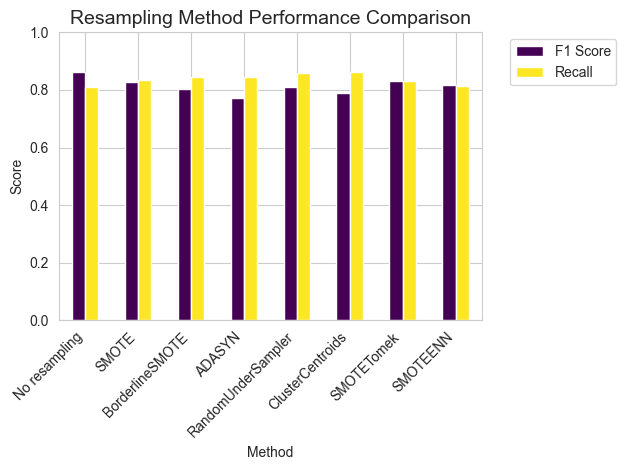

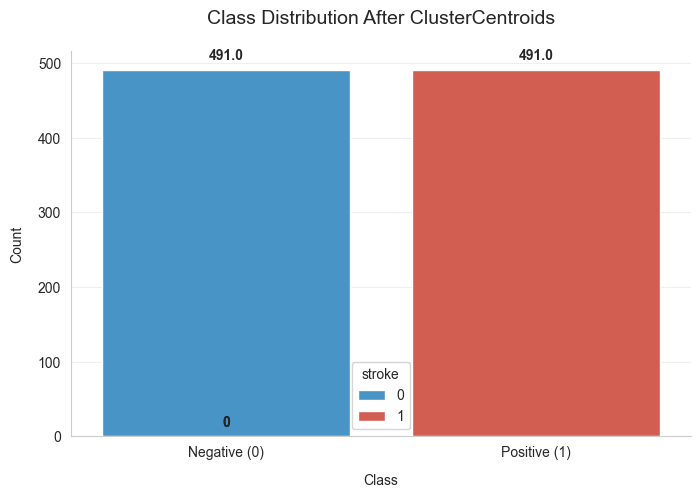


           RESAMPLED CLASS DISTRIBUTION           
+--------------+-------+------------+
|    Class     | Count | Percentage |
+--------------+-------+------------+
| Negative (0) |  491  |   50.0%    |
| Positive (1) |  491  |   50.0%    |
|    Total     |  982  |   100.0%   |
+--------------+-------+------------+
Class Ratio: 1.00:1


In [672]:
# Convert results to DataFrame and find best method
resampling_df = pd.DataFrame(resampling_results)

# Highlight the best method
best_idx = resampling_df["Recall"].idxmax()
best_method = resampling_df.loc[best_idx, "Method"]
print(f"\n{GREEN}Best resampling method (based on Recall): {best_method}{RESET}")
print("=" * 100)

# Visualizations (unchanged from your original code)
plt.figure(figsize=(12, 6))
metrics_to_plot = ["F1 Score", "Recall"]
resampling_df.set_index("Method")[metrics_to_plot].plot(kind="bar", colormap="viridis")
plt.title("Resampling Method Performance Comparison", fontsize=14)
plt.ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Apply best method (unchanged from your original code)
best_resampling_method = resampling_methods[best_method]
if best_resampling_method is not None:
    X_resampled, y_resampled = best_resampling_method.fit_resample(X_train, y_train)

    # Enhanced countplot visualization
    plt.figure(figsize=(8, 5))
    ax = sns.countplot(x=y_resampled, palette=["#3498db", "#e74c3c"], hue=y_resampled)
    plt.title(f"Class Distribution After {best_method}", fontsize=14, pad=20)
    plt.xlabel("Class", labelpad=10)
    plt.ylabel("Count", labelpad=10)
    plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])
    plt.grid(axis="y", alpha=0.3)

    # Add count labels with formatting
    for p in ax.patches:
        ax.annotate(
            f"{p.get_height():,}",
            (p.get_x() + p.get_width() / 2.0, p.get_height()),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
            fontweight="bold",
        )

    sns.despine()
    plt.show()

    # PrettyTable for class distribution
    dist_table = PrettyTable()
    dist_table.field_names = ["Class", "Count", "Percentage"]
    dist_table.add_row(
        [
            "Negative (0)",
            f"{sum(y_resampled == 0):,}",
            f"{(sum(y_resampled == 0) / len(y_resampled) * 100):.1f}%",
        ]
    )
    dist_table.add_row(
        [
            "Positive (1)",
            f"{sum(y_resampled == 1):,}",
            f"{(sum(y_resampled == 1) / len(y_resampled) * 100):.1f}%",
        ]
    )
    dist_table.add_row(["Total", f"{len(y_resampled):,}", "100.0%"])

    print("\n" + "=" * 50)
    print(f"{' RESAMPLED CLASS DISTRIBUTION ':^50}")
    print("=" * 50)
    print(dist_table)
    print(
        f"Class Ratio: {GREEN}{sum(y_resampled == 1) / sum(y_resampled == 0):.2f}:1{RESET}"
    )
    print("=" * 50)
else:
    X_resampled, y_resampled = X_train, y_train
    print(f"\n{RED}Using original imbalanced data (no resampling applied){RESET}")

In [673]:
# 3.1 Define parameter grids for each model
param_grids = {
    "KNN": {
        "n_neighbors": list(range(3, 31, 2)),  # Wider range of neighbors
        "weights": ["uniform", "distance"],
        "metric": ["euclidean", "manhattan"],
        "p": [1, 2],  # Power parameter for Minkowski
    },
    "RandomForest": {
        "n_estimators": [50, 100, 200, 500],
        "max_depth": [None, 10, 20, 30, 50],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2", 0.5, 0.8],
        "class_weight": ["balanced", "balanced_subsample", None],
        "bootstrap": [True, False],
    },
    "DecisionTree": {
        "max_depth": [None, 5, 10, 20, 30],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 4, 8],
        "criterion": ["gini", "entropy"],
        "max_features": ["sqrt", "log2", None],
        "splitter": ["best", "random"],
        "class_weight": ["balanced", None],
    },
    "LogisticRegression": {
        "C": np.logspace(-3, 2, 6),  # [0.001, 0.01, 0.1, 1, 10, 100]
        "solver": ["liblinear", "saga", "newton-cg", "lbfgs"],
        "penalty": ["l1", "l2", "elasticnet"],
        "class_weight": ["balanced", None],
        "max_iter": [1000],
        "tol": [1e-4, 1e-5],
        "l1_ratio": [0, 0.5, 1],  # For elasticnet
    },
}

In [674]:
models = {
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42),
}

best_models = {}
best_scores = {}

In [ ]:
import time

# Initialize PrettyTable
training_table = PrettyTable()
training_table.field_names = [
    "Model",
    "Best CV F1 Score",
    "Best Parameters",
    "Training Time",
]

# Set alignment
training_table.align["Model"] = "l"
training_table.align["Best CV F1 Score"] = "r"
training_table.align["Best Parameters"] = "l"
training_table.align["Training Time"] = "r"

# Color formatting
GREEN = "\033[32m"
BLUE = "\033[34m"
RESET = "\033[0m"

print("\n" + "=" * 90)
print(f"{' MODEL TRAINING AND TUNING RESULTS ':^90}")
print("=" * 90)

for name, model in models.items():
    print(f"\n{GREEN}Training and tuning {name}...{RESET}")

    start_time = time.time()

    # Original RandomizedSearchCV code
    search = RandomizedSearchCV(
        model,
        param_grids[name],
        n_iter=25,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring="f1",
        n_jobs=-1,
        random_state=42,
    )
    search.fit(X_resampled, y_resampled)

    training_time = time.time() - start_time

    # Store best model and score
    best_models[name] = search.best_estimator_
    best_scores[name] = search.best_score_

    # Format parameters for display
    params = "\n".join([f"{k}: {v}" for k, v in search.best_params_.items()])

    # Add row to table
    training_table.add_row(
        [
            name,
            f"{BLUE}{search.best_score_:.4f}{RESET}",
            params,
            f"{training_time:.2f}s",
        ]
    )

# Print the complete table after all models are trained
print(training_table)
print("\n" + "-" * 90)
print(f"Training completed for {len(models)} models")
print("=" * 90)


                            MODEL TRAINING AND TUNING RESULTS                             

Training and tuning KNN...

Training and tuning RandomForest...

Training and tuning DecisionTree...

Training and tuning LogisticRegression...
+--------------------+------------------+------------------------+---------------+
| Model              | Best CV F1 Score | Best Parameters        | Training Time |
+--------------------+------------------+------------------------+---------------+
| KNN                |           0.8683 | weights: distance      |         0.20s |
|                    |                  | p: 2                   |               |
|                    |                  | n_neighbors: 19        |               |
|                    |                  | metric: manhattan      |               |
| RandomForest       |           0.8772 | n_estimators: 200      |         4.86s |
|                    |                  | min_samples_split: 5   |               |
|               

c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
50 fits failed out of a total of 125.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Dev v1.0\Early-Stage-Brain


                                      MODEL EVALUATION RESULTS                                      


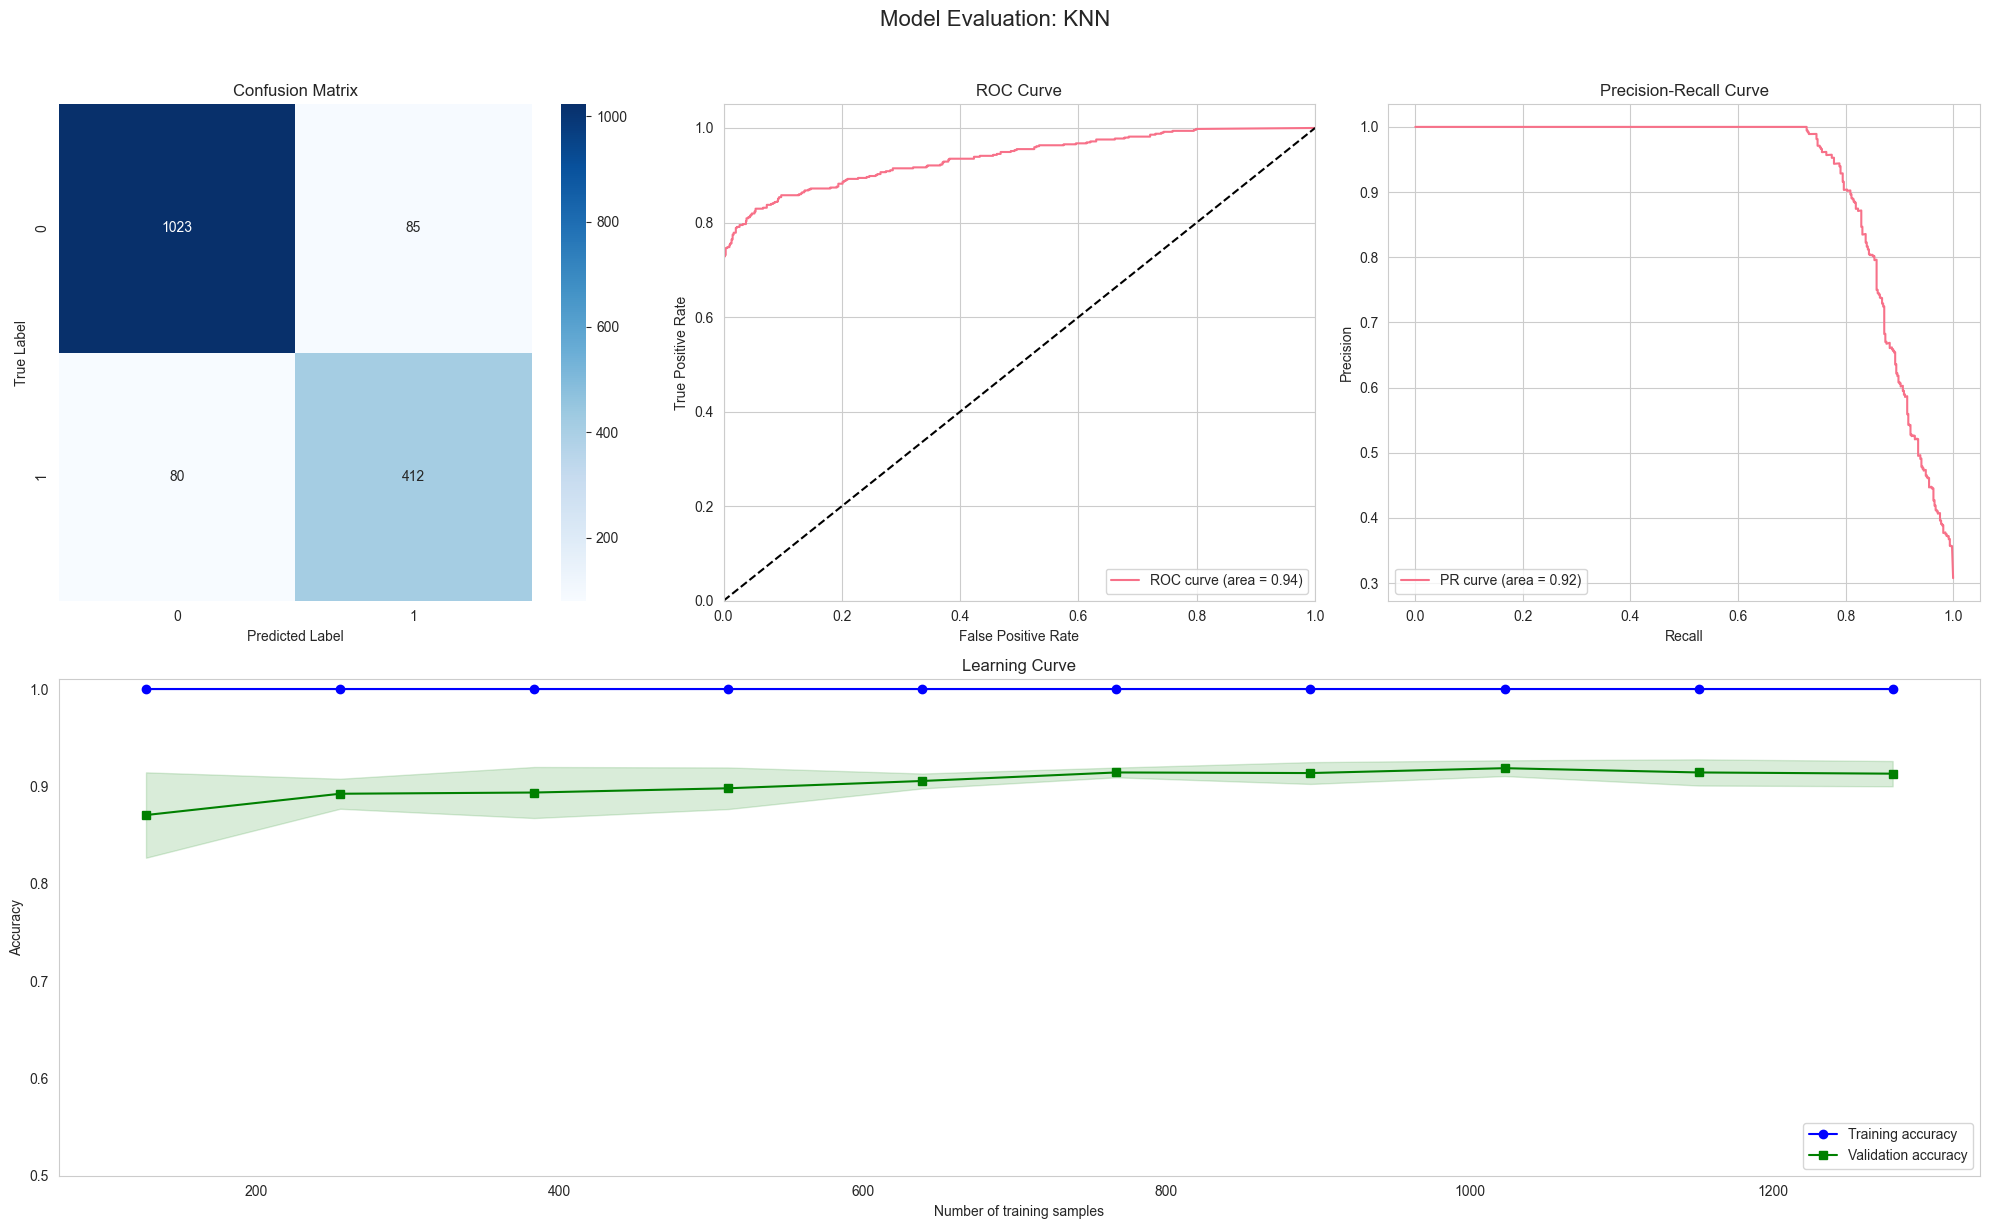


KNN Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      1108
           1       0.83      0.84      0.83       492

    accuracy                           0.90      1600
   macro avg       0.88      0.88      0.88      1600
weighted avg       0.90      0.90      0.90      1600


KNN Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.92      0.84      0.93      0.88      0.78      1108
          1       0.83      0.84      0.92      0.83      0.88      0.77       492

avg / total       0.90      0.90      0.86      0.90      0.88      0.78      1600



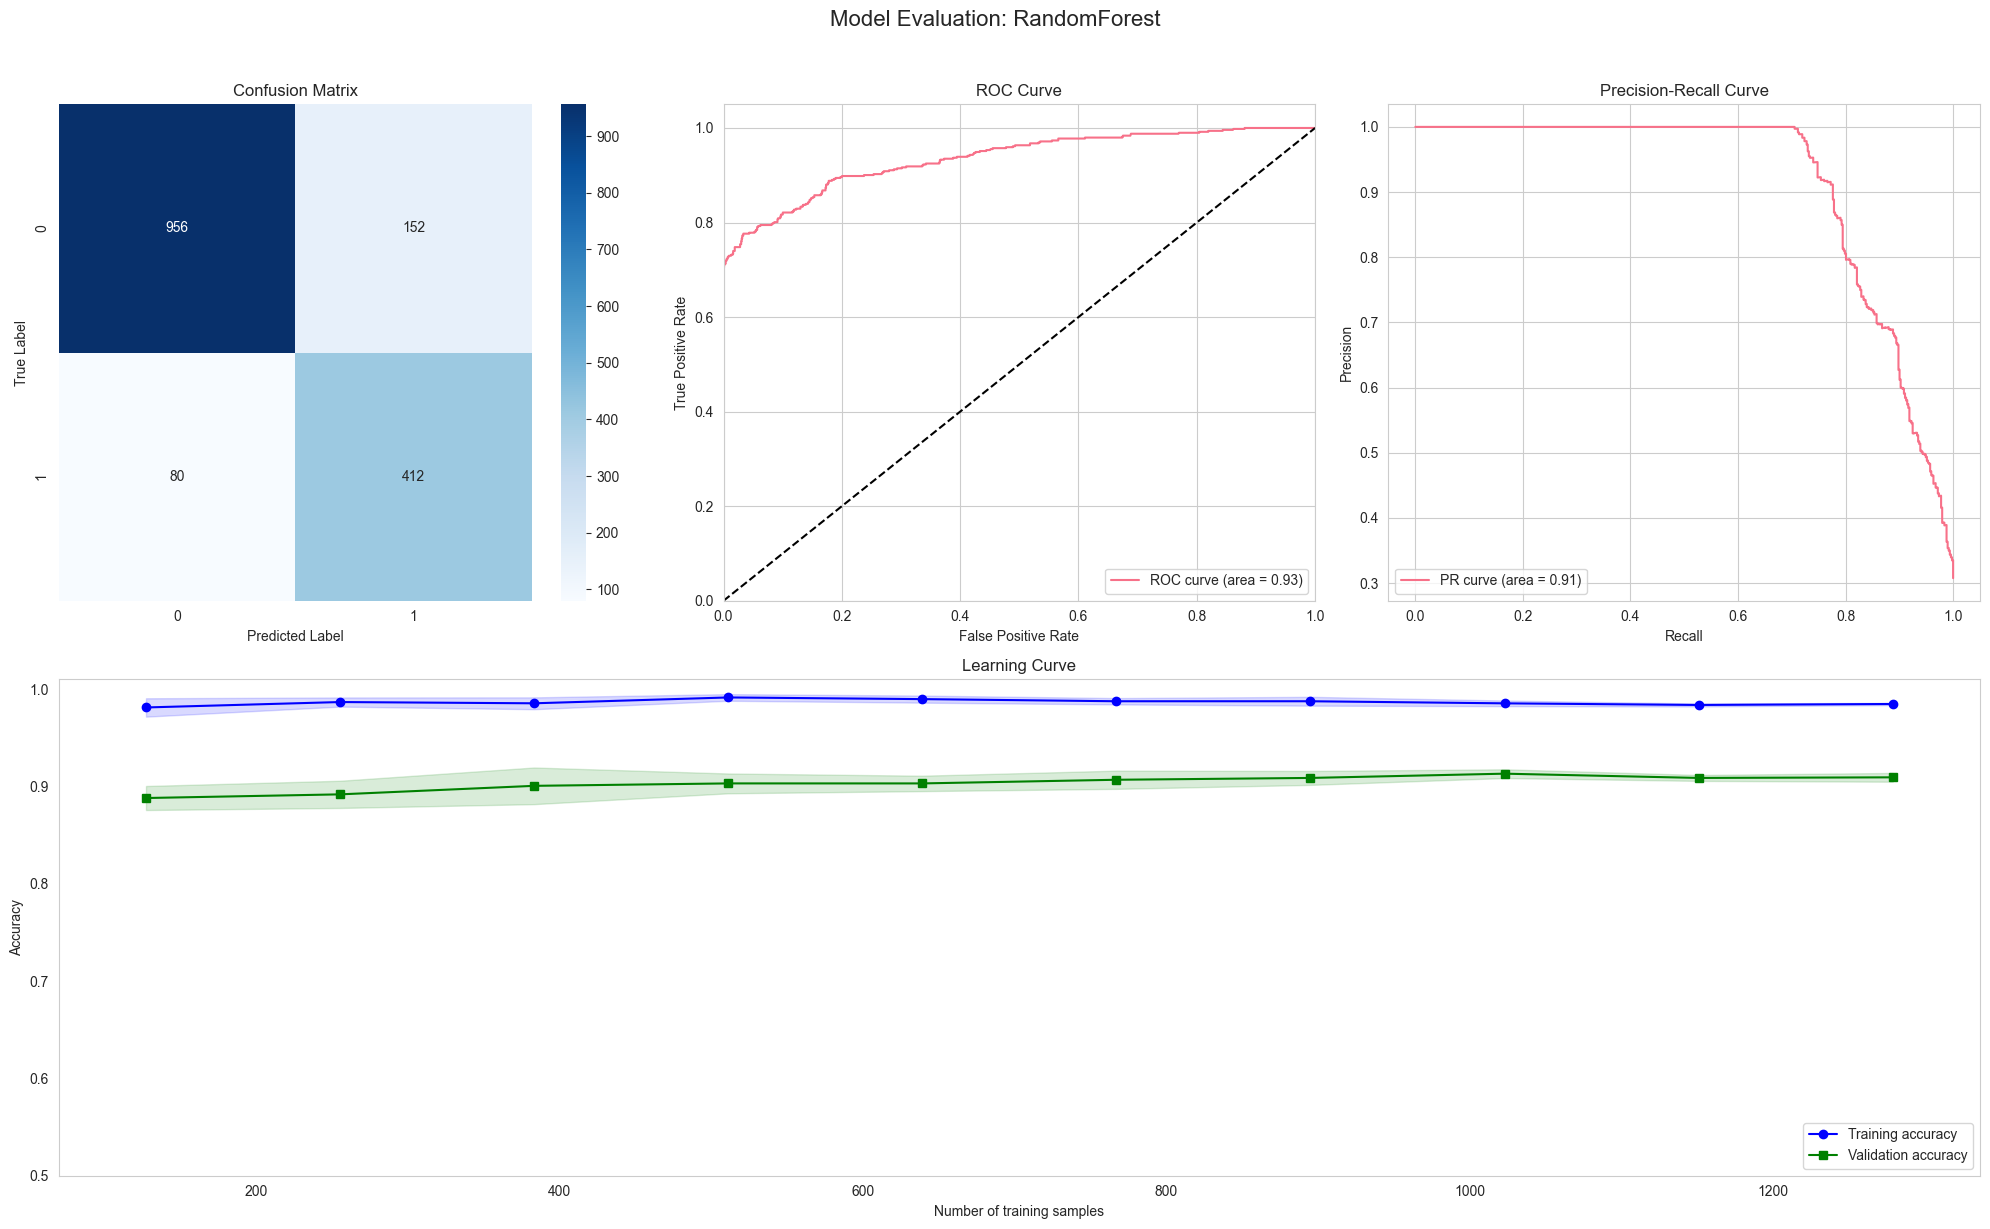


RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      1108
           1       0.73      0.84      0.78       492

    accuracy                           0.85      1600
   macro avg       0.83      0.85      0.84      1600
weighted avg       0.86      0.85      0.86      1600


RandomForest Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.86      0.84      0.89      0.85      0.72      1108
          1       0.73      0.84      0.86      0.78      0.85      0.72       492

avg / total       0.86      0.85      0.85      0.86      0.85      0.72      1600



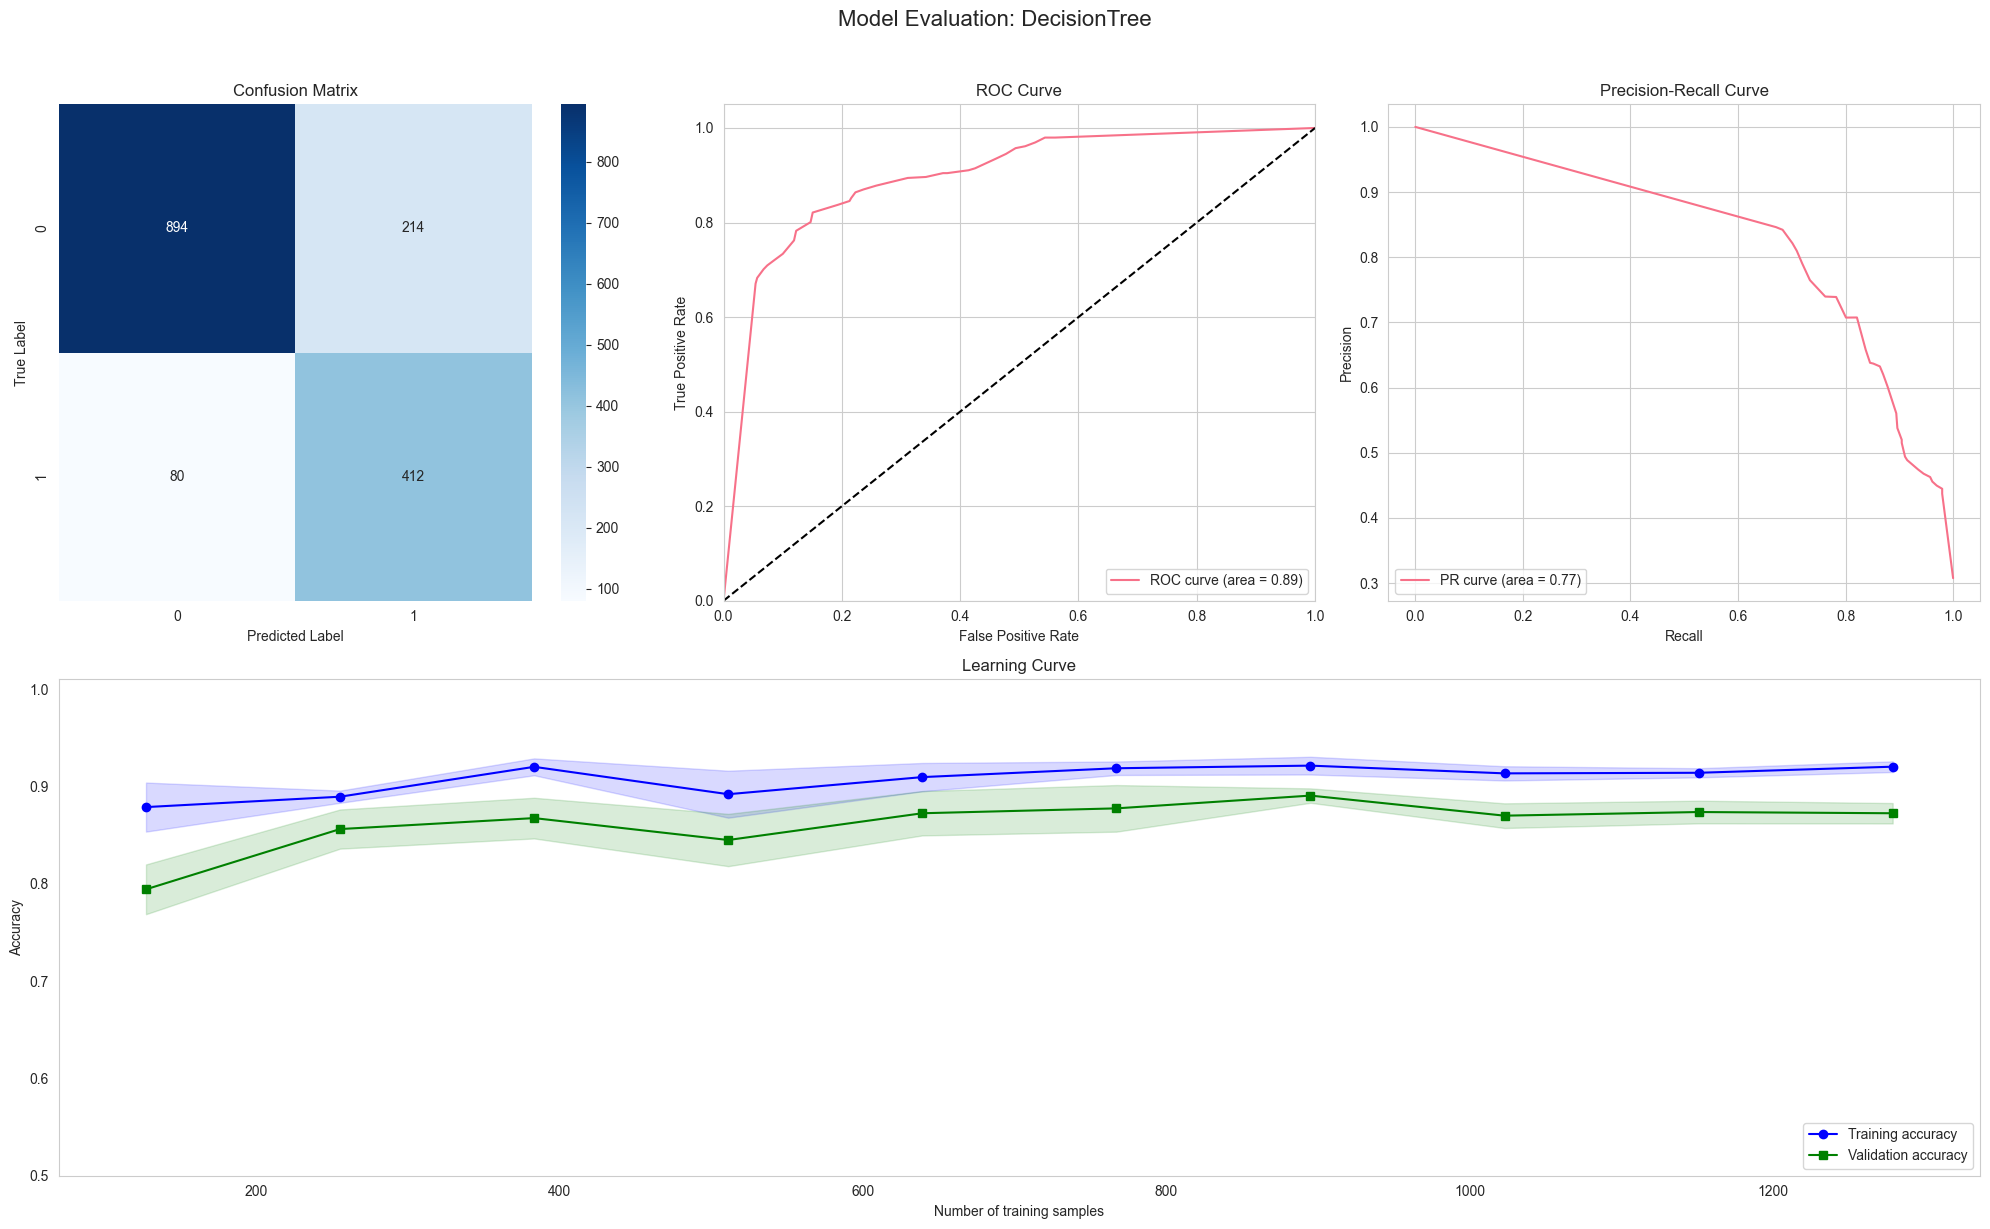


DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1108
           1       0.66      0.84      0.74       492

    accuracy                           0.82      1600
   macro avg       0.79      0.82      0.80      1600
weighted avg       0.84      0.82      0.82      1600


DecisionTree Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.81      0.84      0.86      0.82      0.67      1108
          1       0.66      0.84      0.81      0.74      0.82      0.68       492

avg / total       0.84      0.82      0.83      0.82      0.82      0.67      1600



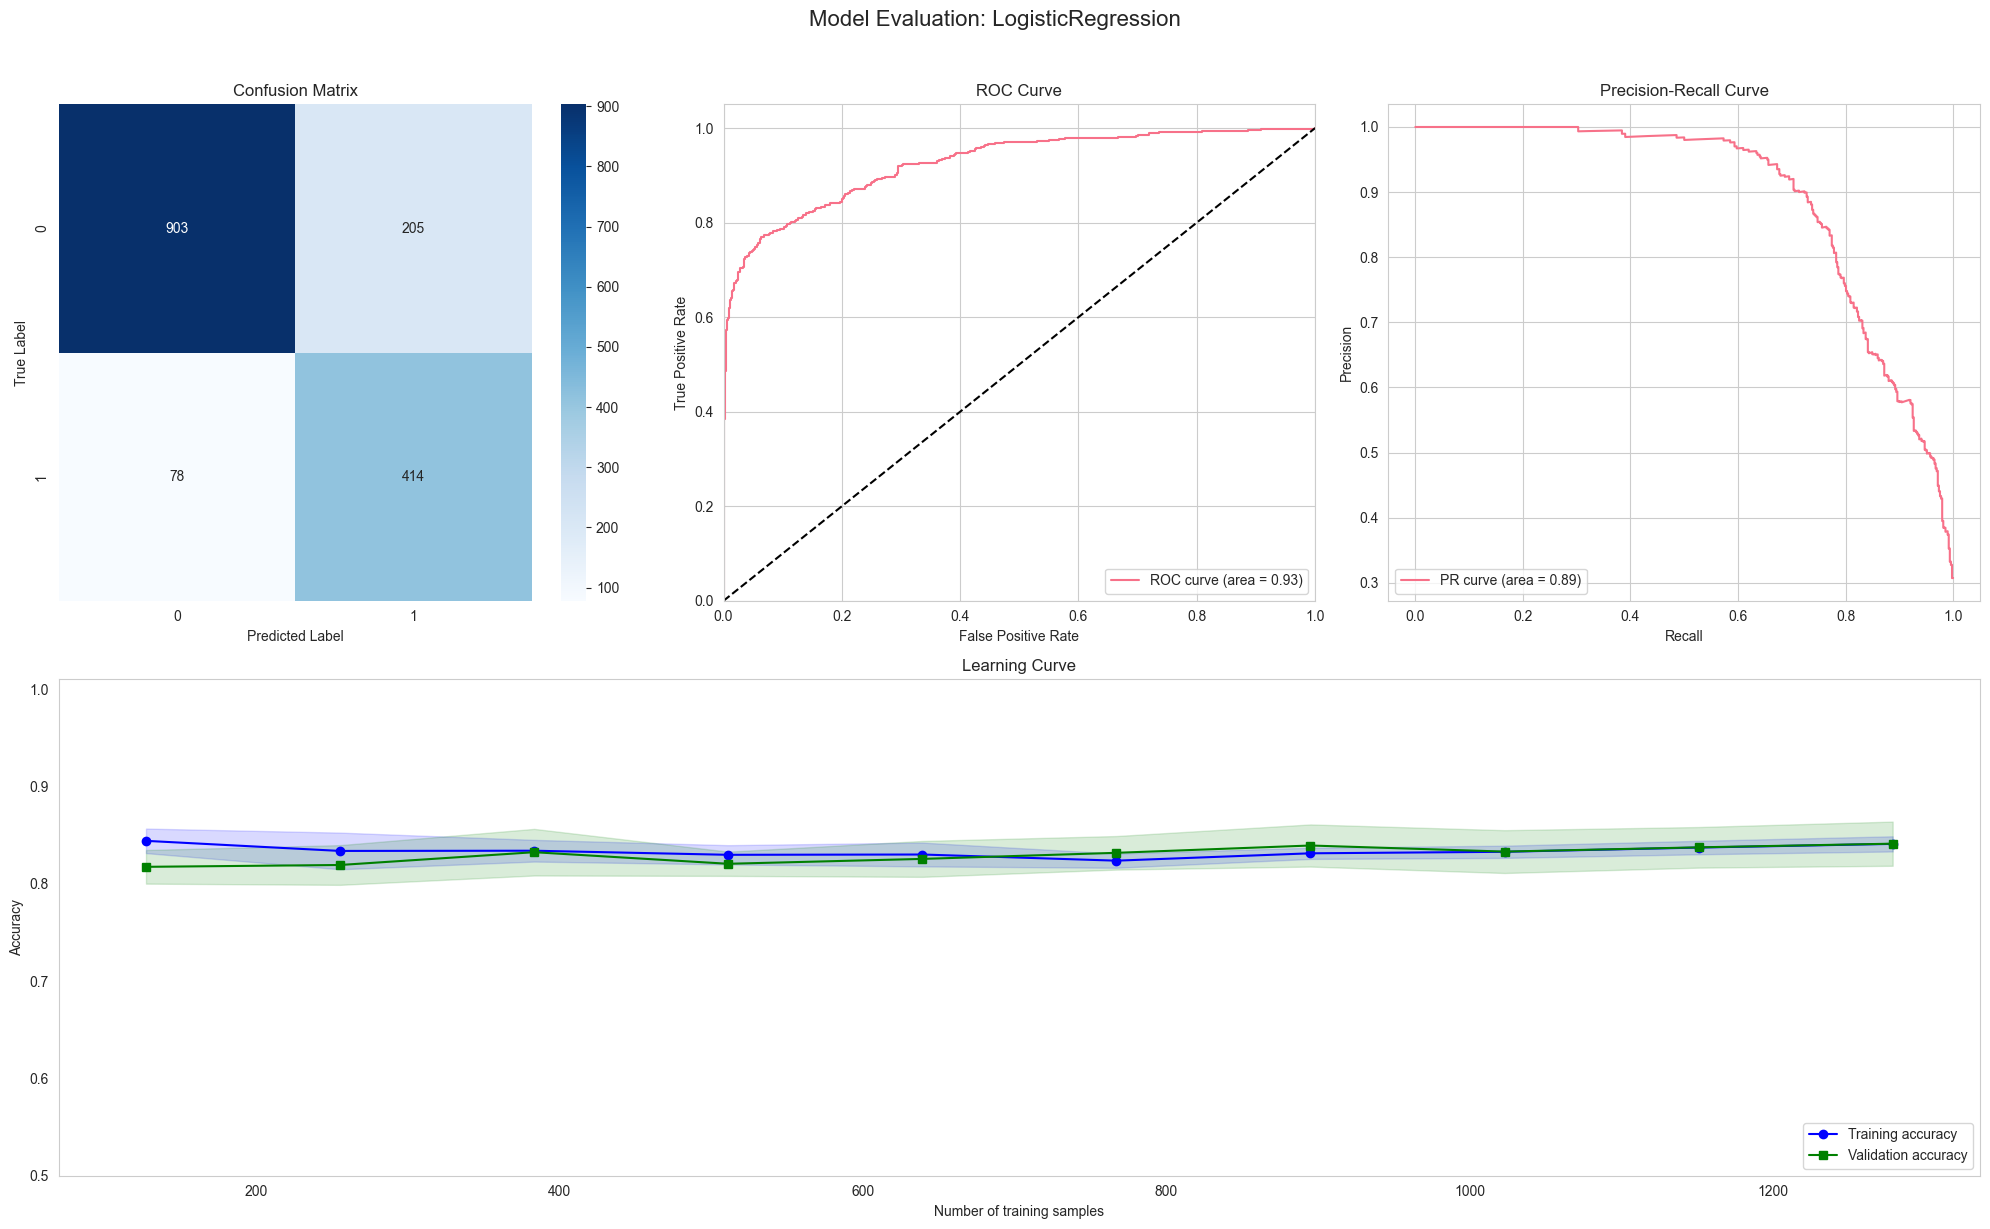


LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1108
           1       0.67      0.84      0.75       492

    accuracy                           0.82      1600
   macro avg       0.79      0.83      0.80      1600
weighted avg       0.84      0.82      0.83      1600


LogisticRegression Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.81      0.84      0.86      0.83      0.68      1108
          1       0.67      0.84      0.81      0.75      0.83      0.69       492

avg / total       0.84      0.82      0.83      0.83      0.83      0.69      1600



In [ ]:
from matplotlib.gridspec import GridSpec
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    recall_score,
    accuracy_score,
    average_precision_score,
)

model_results = []

# Initialize PrettyTable for metrics
metrics_table = PrettyTable()
metrics_table.field_names = [
    "Model",
    "Accuracy",
    "F1 Score",
    "Precision",
    "Recall",
    "ROC-AUC",
    "PR-AUC",
]

# Set alignment and formatting
metrics_table.align = "r"
metrics_table.align["Model"] = "l"
metrics_table.float_format = ".3"

# Color formatting
GREEN = "\033[32m"
BLUE = "\033[34m"
RESET = "\033[0m"

print("\n" + "=" * 100)
print(f"{' MODEL EVALUATION RESULTS ':^100}")
print("=" * 100)

for name, model in best_models.items():
    # Make predictions and calculate metrics (original code)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = average_precision_score(y_test, y_prob)

    model_results.append(
        {
            "Model": name,
            "Accuracy": accuracy,
            "F1 Score": f1,
            "Precision": precision,
            "Recall": recall,
            "ROC-AUC": roc_auc,
            "PR-AUC": pr_auc,
            "Model_Object": model,  # Store the actual model object
        }
    )

    # Add to metrics table
    metrics_table.add_row(
        [
            f"{BLUE}{name}{RESET}",
            f"{accuracy:.3f}",
            f"{GREEN}{f1:.3f}{RESET}",
            f"{precision:.3f}",
            f"{recall:.3f}",
            f"{roc_auc:.3f}",
            f"{pr_auc:.3f}",
        ]
    )

    # Create figure with subplots for visualizations
    fig = plt.figure(figsize=(20, 12))
    fig.suptitle(f"Model Evaluation: {name}", fontsize=16, y=1.02)
    gs = GridSpec(2, 3, figure=fig)

    # Confusion Matrix
    ax1 = fig.add_subplot(gs[0, 0])
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax1)
    ax1.set_title("Confusion Matrix")
    ax1.set_ylabel("True Label")
    ax1.set_xlabel("Predicted Label")

    # ROC Curve
    ax2 = fig.add_subplot(gs[0, 1])
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    ax2.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
    ax2.plot([0, 1], [0, 1], "k--")
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel("False Positive Rate")
    ax2.set_ylabel("True Positive Rate")
    ax2.set_title("ROC Curve")
    ax2.legend(loc="lower right")

    # Precision-Recall Curve
    ax3 = fig.add_subplot(gs[0, 2])
    precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
    ax3.plot(recall_curve, precision_curve, label=f"PR curve (area = {pr_auc:.2f})")
    ax3.set_xlabel("Recall")
    ax3.set_ylabel("Precision")
    ax3.set_title("Precision-Recall Curve")
    ax3.legend(loc="lower left")

    # Learning Curve
    ax4 = fig.add_subplot(gs[1, :])
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model,
        X=X_train,
        y=y_train,
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        random_state=42,
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    ax4.plot(train_sizes, train_mean, "o-", color="blue", label="Training accuracy")
    ax4.fill_between(
        train_sizes,
        train_mean + train_std,
        train_mean - train_std,
        alpha=0.15,
        color="blue",
    )
    ax4.plot(train_sizes, test_mean, "s-", color="green", label="Validation accuracy")
    ax4.fill_between(
        train_sizes,
        test_mean + test_std,
        test_mean - test_std,
        alpha=0.15,
        color="green",
    )

    ax4.grid()
    ax4.set_xlabel("Number of training samples")
    ax4.set_ylabel("Accuracy")
    ax4.legend(loc="lower right")
    ax4.set_ylim([0.5, 1.01])
    ax4.set_title("Learning Curve")

    plt.tight_layout()
    plt.show()

    # Print classification reports
    print(f"\n{BLUE}{name} Classification Report:{RESET}")
    print(classification_report(y_test, y_pred))

    print(f"\n{BLUE}{name} Imbalanced Classification Report:{RESET}")
    print(classification_report_imbalanced(y_test, y_pred))


=== Training Ensemble Model ===

Voting Classifier Results:
              precision    recall  f1-score   support

           0       0.93      0.87      0.90      1108
           1       0.75      0.86      0.80       492

    accuracy                           0.87      1600
   macro avg       0.84      0.87      0.85      1600
weighted avg       0.88      0.87      0.87      1600

Imbalanced Classification Report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.93      0.87      0.86      0.90      0.87      0.75      1108
          1       0.75      0.86      0.87      0.80      0.87      0.75       492

avg / total       0.88      0.87      0.86      0.87      0.87      0.75      1600



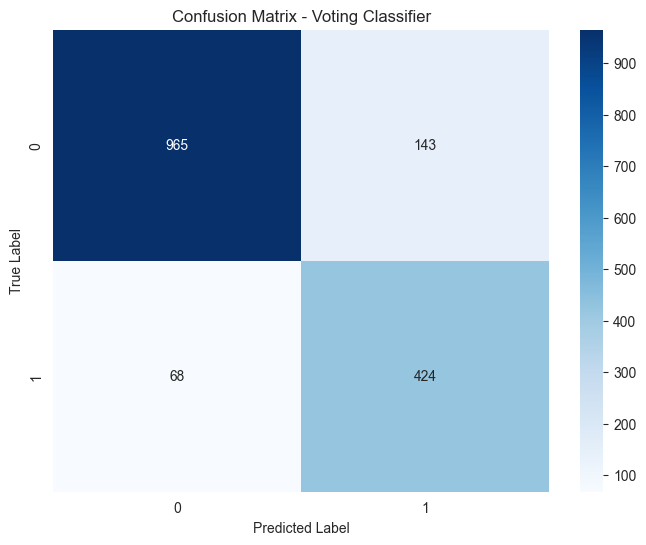

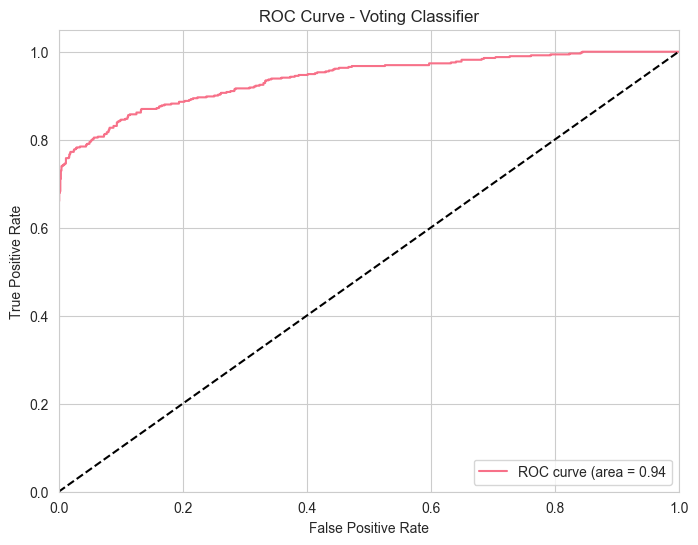

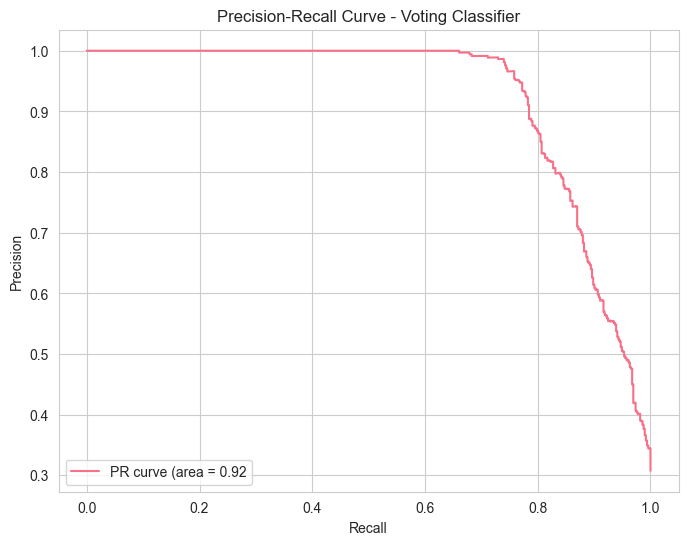

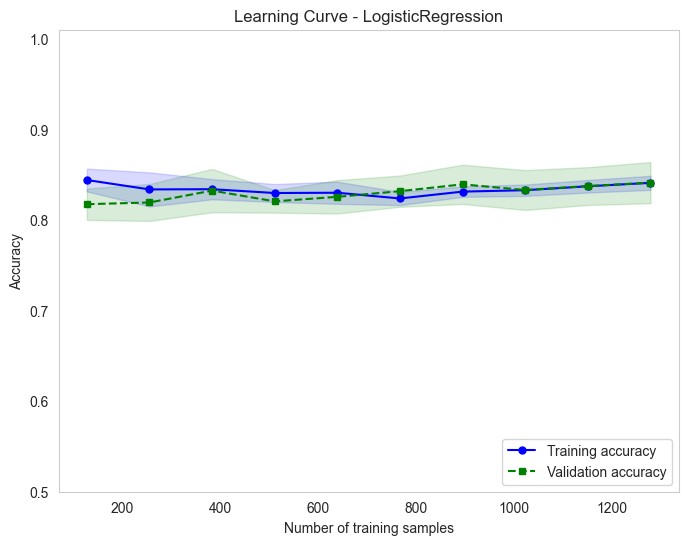

In [677]:
# =============================================
# Ensemble Model (Voting Classifier)
# =============================================
print("\n=== Training Ensemble Model ===")

# Create the voting classifier using the best models from previous steps
voting_clf = VotingClassifier(
    estimators=[
        ("rf", best_models["RandomForest"]),
        ("dt", best_models["DecisionTree"]),
        ("knn", best_models["KNN"]),
    ],
    voting="soft",  # Use soft voting for probability estimates
)

# Train the voting classifier
voting_clf.fit(X_resampled, y_resampled)

# Add to best_models dictionary for consistent evaluation
best_models["Voting"] = voting_clf

# Evaluate the ensemble model
y_pred = voting_clf.predict(X_test)
y_prob = voting_clf.predict_proba(X_test)[:, 1]

# Calculate metrics
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

# Calculate ROC-AUC
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Calculate PR-AUC
precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall_curve, precision_curve)

# Add to model results
model_results.append(
    {
        "Model": "Voting",
        "Accuracy": accuracy,
        "F1 Score": f1,
        "Precision": precision,
        "Recall": recall,
        "ROC-AUC": roc_auc,
        "PR-AUC": pr_auc,
    }
)

# Print classification report
print("\nVoting Classifier Results:")
print(classification_report(y_test, y_pred))

# Print imbalanced classification report
print("Imbalanced Classification Report:")
print(classification_report_imbalanced(y_test, y_pred))

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Voting Classifier")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Voting Classifier")
plt.legend(loc="lower right")
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_curve, precision_curve, label=f"PR curve (area = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Voting Classifier")
plt.legend(loc="lower left")
plt.show()

# Plot Learning Curve
plt.figure(figsize=(8, 6))
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X_train,
    y=y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    random_state=42,
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(
    train_sizes,
    train_mean,
    color="blue",
    marker="o",
    markersize=5,
    label="Training accuracy",
)
plt.fill_between(
    train_sizes,
    train_mean + train_std,
    train_mean - train_std,
    alpha=0.15,
    color="blue",
)

plt.plot(
    train_sizes,
    test_mean,
    color="green",
    linestyle="--",
    marker="s",
    markersize=5,
    label="Validation accuracy",
)
plt.fill_between(
    train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color="green"
)

plt.grid()
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.ylim([0.5, 1.01])  # Adjust based on your expected accuracy range
plt.title(f"Learning Curve - {name}")
plt.savefig(f"learning_curve_{name}.png")
plt.show()

In [ ]:
# Print metrics table after all models
print("\n" + "=" * 100)
print(f"{' COMPARATIVE MODEL PERFORMANCE ':^100}")
print("=" * 100)
print(metrics_table)
print("\n" + "-" * 100)
print("Key:")
print(f"{GREEN}F1 Score{RESET} - Primary evaluation metric")
print(f"{BLUE}Model names{RESET} - Color coded for visibility")
print("=" * 100)


                                   COMPARATIVE MODEL PERFORMANCE                                    
+--------------------+----------+----------+-----------+--------+---------+--------+
| Model              | Accuracy | F1 Score | Precision | Recall | ROC-AUC | PR-AUC |
+--------------------+----------+----------+-----------+--------+---------+--------+
| KNN                |    0.897 |    0.833 |     0.829 |  0.837 |   0.937 |  0.922 |
| RandomForest       |    0.855 |    0.780 |     0.730 |  0.837 |   0.935 |  0.914 |
| DecisionTree       |    0.816 |    0.737 |     0.658 |  0.837 |   0.895 |  0.774 |
| LogisticRegression |    0.823 |    0.745 |     0.669 |  0.841 |   0.925 |  0.891 |
+--------------------+----------+----------+-----------+--------+---------+--------+

----------------------------------------------------------------------------------------------------
Key:
F1 Score - Primary evaluation metric
Model names - Color coded for visibility


c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Dev v1.0\Early-Stage-Brain-

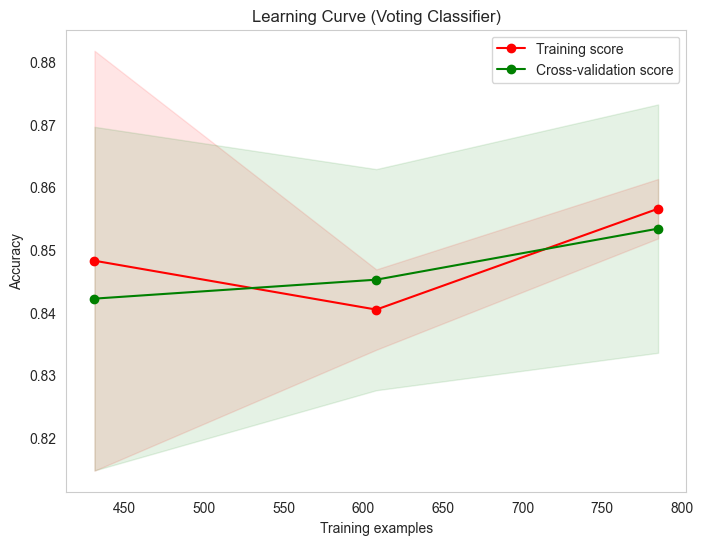

In [679]:
from sklearn.model_selection import learning_curve


# Create a function to plot learning curve
def plot_learning_curve(
    estimator, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)
):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Accuracy")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        scoring="accuracy",
        random_state=42,
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    plt.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    plt.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )

    plt.legend(loc="best")
    plt.show()


# Plot learning curve for the voting classifier
plot_learning_curve(
    model, "Learning Curve (Voting Classifier)", X_resampled, y_resampled, cv=5
)

In [680]:
print("Prercision Score:", precision_score(y_test, y_pred))

Prercision Score: 0.7477954144620811


In [ ]:
# Create PrettyTable
model_table = PrettyTable()
model_table.field_names = [
    "Model",
    "F1 Score",
    "Recall",
    "Accuracy",
    "Precision",
    "ROC-AUC",
    "PR-AUC",
]

# Set alignment
model_table.align["Model"] = "l"
model_table.align["F1 Score"] = "r"
model_table.align["Recall"] = "r"
model_table.align["Accuracy"] = "r"
model_table.align["Precision"] = "r"
model_table.align["ROC-AUC"] = "r"
model_table.align["PR-AUC"] = "r"
model_table.float_format = ".4"  # 4 decimal places

model_results_df = pd.DataFrame(model_results)
# Add data
for _, row in model_results_df.iterrows():
    model_table.add_row(
        [
            row["Model"],
            row["F1 Score"],
            row["Recall"],
            row["Accuracy"],
            row["Precision"],
            row["ROC-AUC"],
            row["PR-AUC"],
        ]
    )

# Print table
print("\n=== MODEL COMPARISON ===")
print(model_table)


=== MODEL COMPARISON ===
+--------------------+----------+--------+----------+-----------+---------+--------+
| Model              | F1 Score | Recall | Accuracy | Precision | ROC-AUC | PR-AUC |
+--------------------+----------+--------+----------+-----------+---------+--------+
| KNN                |   0.8332 | 0.8374 |   0.8969 |    0.8290 |  0.9367 | 0.9221 |
| RandomForest       |   0.7803 | 0.8374 |   0.8550 |    0.7305 |  0.9346 | 0.9138 |
| DecisionTree       |   0.7370 | 0.8374 |   0.8163 |    0.6581 |  0.8949 | 0.7736 |
| LogisticRegression |   0.7453 | 0.8415 |   0.8231 |    0.6688 |  0.9250 | 0.8914 |
| Voting             |   0.8008 | 0.8618 |   0.8681 |    0.7478 |  0.9392 | 0.9205 |
+--------------------+----------+--------+----------+-----------+---------+--------+



                                    MODEL PERFORMANCE COMPARISON                                    
+--------------------+----------+-----------+--------+----------+---------+--------+
| Model              | Accuracy | Precision | Recall | F1 Score | ROC-AUC | PR-AUC |
+--------------------+----------+-----------+--------+----------+---------+--------+
| KNN                |   0.8969 |    0.8290 | 0.8374 |   0.8332 |  0.9367 | 0.9221 |
| RandomForest       |   0.8550 |    0.7305 | 0.8374 |   0.7803 |  0.9346 | 0.9138 |
| DecisionTree       |   0.8163 |    0.6581 | 0.8374 |   0.7370 |  0.8949 | 0.7736 |
| LogisticRegression |   0.8231 |    0.6688 | 0.8415 |   0.7453 |  0.9250 | 0.8914 |
| Voting             |   0.8681 |    0.7478 | 0.8618 |   0.8008 |  0.9392 | 0.9205 |
+--------------------+----------+-----------+--------+----------+---------+--------+

----------------------------------------------------------------------------------------------------
F1 Score - Primary evaluation m

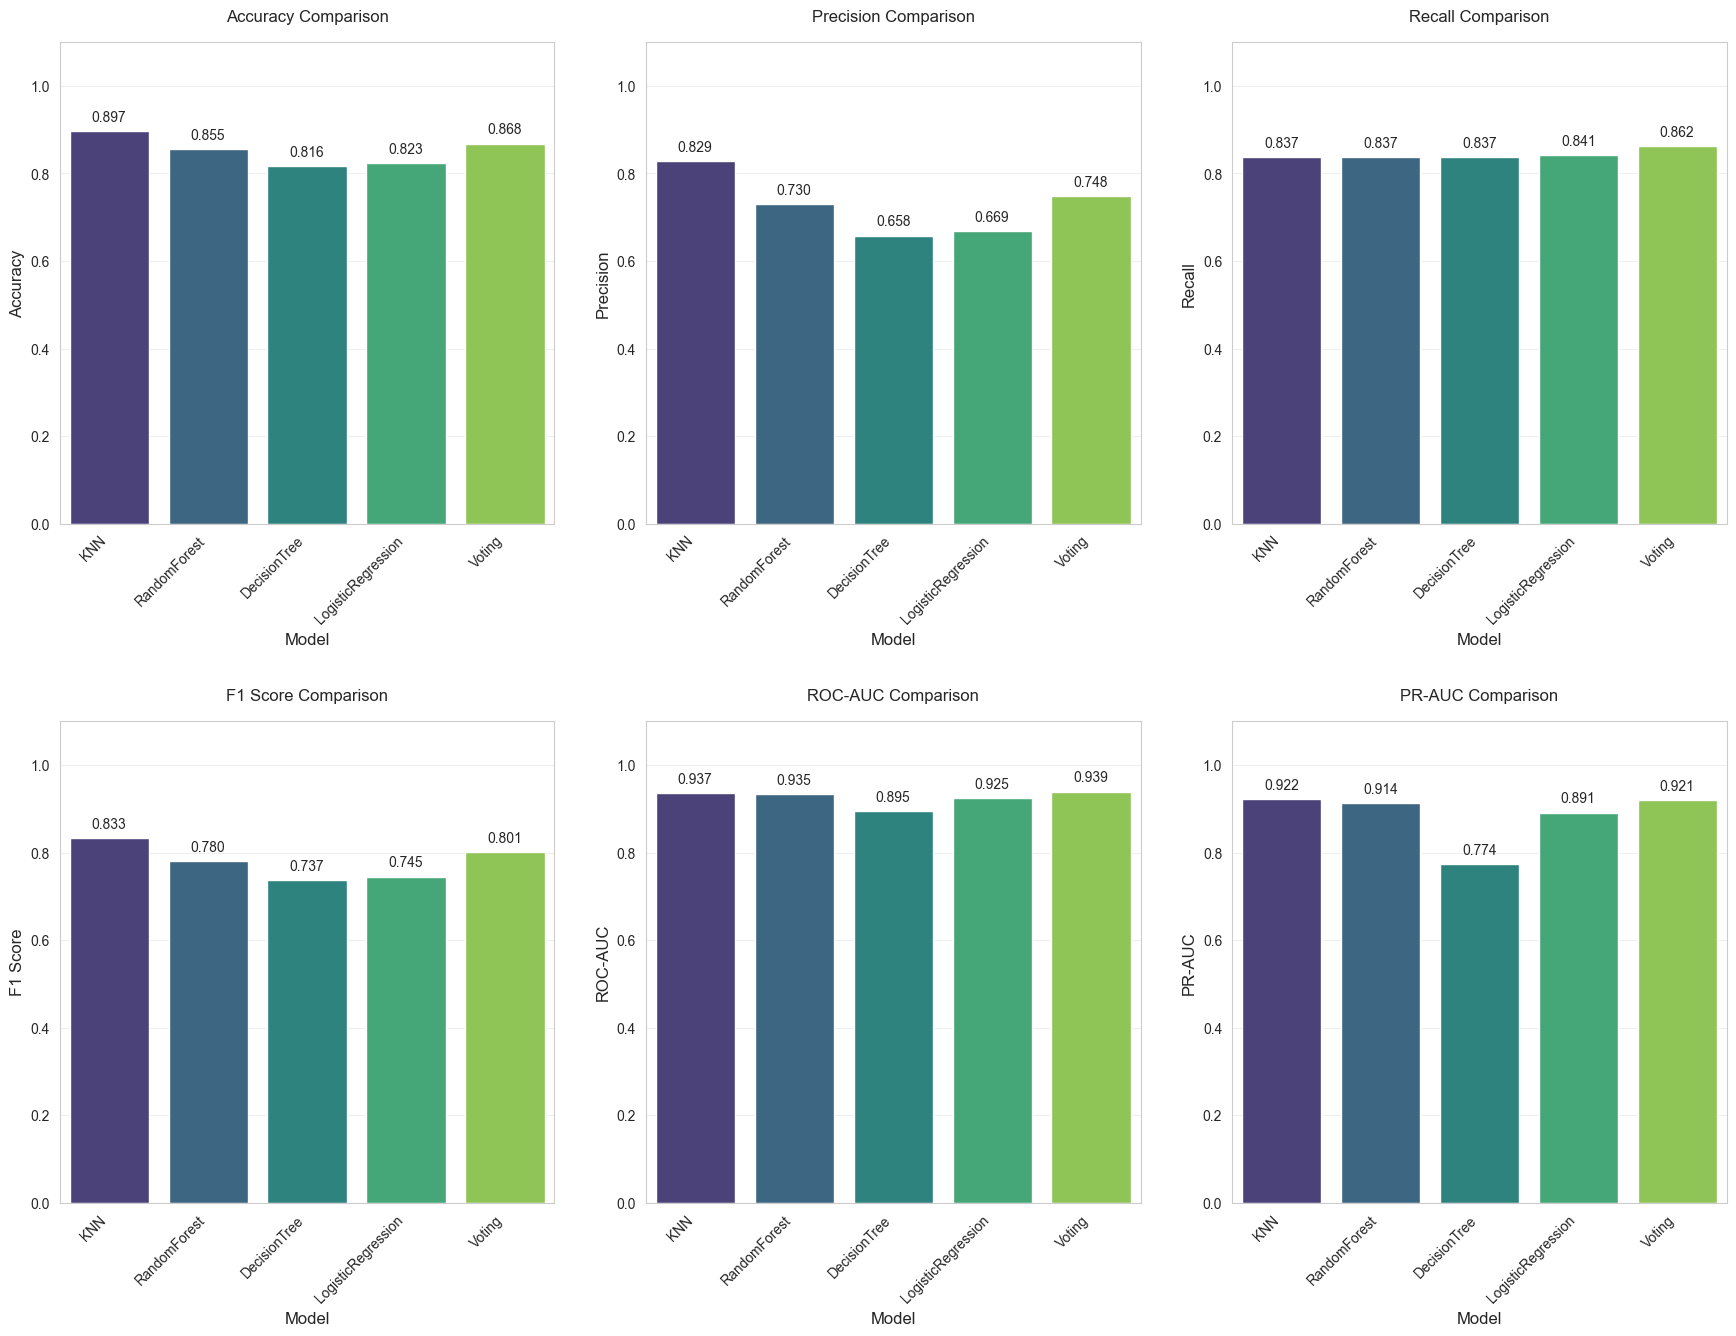

In [ ]:
# Convert results to DataFrame
model_results_df = pd.DataFrame(model_results)

# Create PrettyTable
model_table = PrettyTable()
model_table.field_names = [
    "Model",
    "Accuracy",
    "Precision",
    "Recall",
    "F1 Score",
    "ROC-AUC",
    "PR-AUC",
]

# Set alignment and formatting
model_table.align["Model"] = "l"
model_table.align["Accuracy"] = "r"
model_table.align["Precision"] = "r"
model_table.align["Recall"] = "r"
model_table.align["F1 Score"] = "r"
model_table.align["ROC-AUC"] = "r"
model_table.align["PR-AUC"] = "r"
model_table.float_format = ".4"  # 4 decimal places

# Color formatting
GREEN = "\033[32m"
BLUE = "\033[34m"
RESET = "\033[0m"

# Add data to table
for _, row in model_results_df.iterrows():
    model_table.add_row(
        [
            f"{BLUE}{row['Model']}{RESET}",
            f"{row['Accuracy']:.4f}",
            f"{row['Precision']:.4f}",
            f"{row['Recall']:.4f}",
            f"{GREEN}{row['F1 Score']:.4f}{RESET}",  # Highlight F1 score
            f"{row['ROC-AUC']:.4f}",
            f"{row['PR-AUC']:.4f}",
        ]
    )

# Print the table
print("\n" + "=" * 100)
print(f"{' MODEL PERFORMANCE COMPARISON ':^100}")
print("=" * 100)
print(model_table)
print("\n" + "-" * 100)
print(f"{GREEN}F1 Score{RESET} - Primary evaluation metric")
print("=" * 100)

# Keep your original visualization code exactly the same
metrics = ["Accuracy", "Precision", "Recall", "F1 Score", "ROC-AUC", "PR-AUC"]
plt.figure(figsize=(18, 14))  # Slightly larger figure for better readability

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 3, i)
    model_results_df[metric] = pd.to_numeric(model_results_df[metric], errors="coerce")

    # Create bar plot
    ax = sns.barplot(
        x="Model",
        y=metric,
        data=model_results_df,
        hue="Model",
        palette="viridis",
        legend=False,
    )

    # Add value labels on top of each bar
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(
            f"{height:.3f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
            fontsize=10,
        )

    plt.title(f"{metric} Comparison", pad=15)
    plt.ylim(0, 1.1)  # Added space for value labels
    plt.xticks(rotation=45, ha="right")
    plt.ylabel(metric, fontsize=12)
    plt.xlabel("Model", fontsize=12)
    plt.grid(axis="y", alpha=0.3)  # Add subtle grid for better readability

plt.tight_layout(pad=3.0)  # Add more padding between subplots
plt.show()


                                         WEIGHTED MODEL PERFORMANCE COMPARISON                                          
+--------------------+----------+-----------+--------+----------+---------+--------+----------------+
| Model              | Accuracy | Precision | Recall | F1 Score | ROC-AUC | PR-AUC | Weighted Score |
+--------------------+----------+-----------+--------+----------+---------+--------+----------------+
| KNN                |    0.897 |     0.829 |  0.837 |    0.833 |   0.937 |  0.922 |          0.862 |
| Voting             |    0.868 |     0.748 |  0.862 |    0.801 |   0.939 |  0.921 |          0.838 |
| RandomForest       |    0.855 |     0.730 |  0.837 |    0.780 |   0.935 |  0.914 |          0.822 |
| LogisticRegression |    0.823 |     0.669 |  0.841 |    0.745 |   0.925 |  0.891 |          0.793 |
| DecisionTree       |    0.816 |     0.658 |  0.837 |    0.737 |   0.895 |  0.774 |          0.773 |
+--------------------+----------+-----------+--------+--------

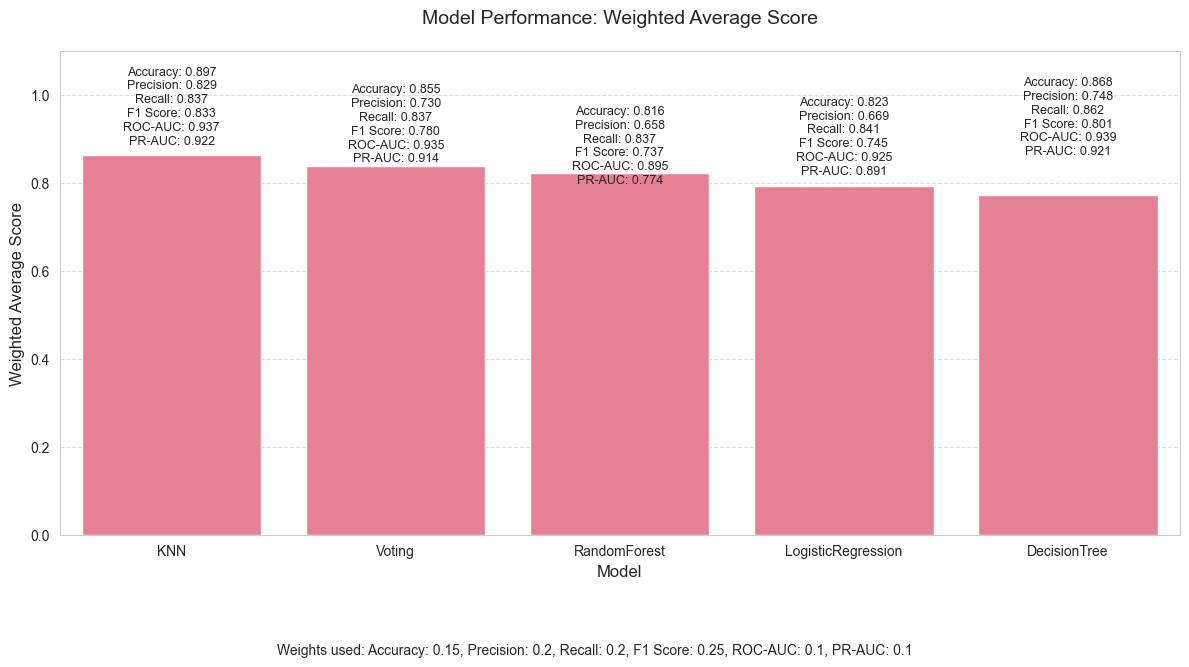

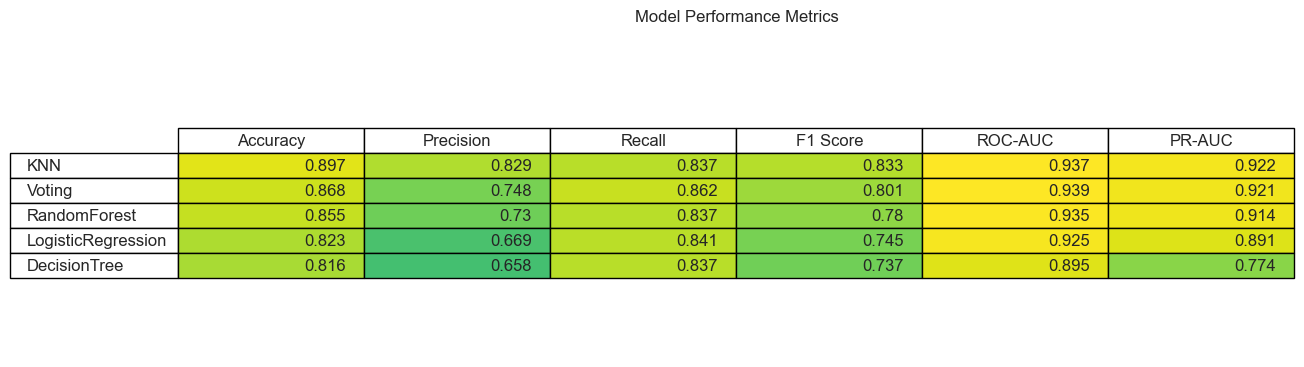

In [ ]:
# Convert results to DataFrame and calculate weighted score
model_results_df = pd.DataFrame(model_results)
weights = {
    "Accuracy": 0.15,
    "Precision": 0.20,
    "Recall": 0.20,
    "F1 Score": 0.25,
    "ROC-AUC": 0.10,
    "PR-AUC": 0.10,
}
model_results_df["Weighted_Score"] = sum(
    model_results_df[metric] * weight for metric, weight in weights.items()
)
model_results_df = model_results_df.sort_values("Weighted_Score", ascending=False)

# Create PrettyTable
weighted_table = PrettyTable()
weighted_table.field_names = ["Model"] + list(weights.keys()) + ["Weighted Score"]
weighted_table.align = "r"  # Right-align all numeric columns
weighted_table.align["Model"] = "l"  # Left-align model names
weighted_table.float_format = ".3"  # 3 decimal places

# Add color formatting
GREEN = "\033[32m"
BLUE = "\033[34m"
RESET = "\033[0m"

# Add data to table
for _, row in model_results_df.iterrows():
    weighted_table.add_row(
        [f"{BLUE}{row['Model']}{RESET}"]
        + [f"{row[metric]:.3f}" for metric in weights.keys()]
        + [f"{GREEN}{row['Weighted_Score']:.3f}{RESET}"]
    )

# Print the table
print("\n" + "=" * 120)
print(f"{' WEIGHTED MODEL PERFORMANCE COMPARISON ':^120}")
print("=" * 120)
print(weighted_table)
print("\n" + "-" * 120)
print(f"Weights used: {', '.join([f'{k}: {v}' for k, v in weights.items()])}")
print(f"{GREEN}Weighted Score{RESET} - Overall performance metric (color highlighted)")
print("=" * 120)

# Plot weighted average comparison
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x="Model",
    y="Weighted_Score",
    data=model_results_df,
    order=model_results_df["Model"],
)

# Add metric breakdown as text annotations
for i, row in model_results_df.iterrows():
    metric_text = "\n".join([f"{m}: {row[m]:.3f}" for m in weights.keys()])
    ax.text(
        i,
        row["Weighted_Score"] + 0.02,
        metric_text,
        ha="center",
        va="bottom",
        fontsize=9,
    )

# Customize plot
plt.title("Model Performance: Weighted Average Score", fontsize=14, pad=20)
plt.ylim(0, 1.1)
plt.ylabel("Weighted Average Score", fontsize=12)
plt.xlabel("Model", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.figtext(
    0.5,
    -0.1,
    f"\nWeights used: {', '.join([f'{k}: {v}' for k, v in weights.items()])}",
    ha="center",
    fontsize=10,
)
plt.tight_layout()
plt.show()

# Create matplotlib table visualization
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis("off")
table_data = model_results_df.set_index("Model")[list(weights.keys())]
colors = plt.cm.viridis(table_data.values / np.max(table_data.values))
table = ax.table(
    cellText=np.round(table_data.values, 3),
    rowLabels=table_data.index,
    colLabels=table_data.columns,
    cellColours=colors,
    loc="center",
)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.5)
plt.title("Model Performance Metrics", pad=20)
plt.show()

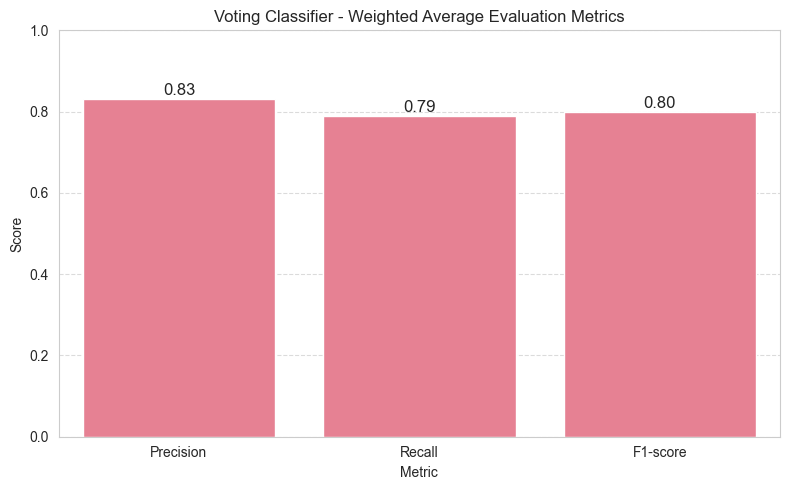

In [684]:
# Weighted average metric values from the image
metrics = ["Precision", "Recall", "F1-score"]
values = [0.83, 0.79, 0.80]

# Set up the plot
plt.figure(figsize=(8, 5))
sns.barplot(x=metrics, y=values)

# Annotate the bars with values
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.2f}", ha="center", fontsize=12)

# Add labels and title
plt.ylim(0, 1)
plt.title("Voting Classifier - Weighted Average Evaluation Metrics")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


In [685]:
best_model_name = model_results_df.loc[model_results_df["F1 Score"].idxmax(), "Model"]
best_model = best_models[best_model_name]
print(f"\nBest model based on ROC-AUC: {best_model_name}")


Best model based on ROC-AUC: KNN


In [686]:
if best_model_name in ["RandomForest", "DecisionTree", "XGBoost"]:
    # For tree-based models that have feature_importances_
    feature_importance = pd.DataFrame(
        {"Feature": X.columns, "Importance": best_model.feature_importances_}
    ).sort_values("Importance", ascending=False)

    print("\nFeature Importance:")
    print(feature_importance)

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=feature_importance)
    plt.title(f"Feature Importance ({best_model_name})")
    plt.tight_layout()
    plt.show()

elif best_model_name == "LogisticRegression":
    # For Logistic Regression, we use absolute coefficient values
    feature_importance = pd.DataFrame(
        {"Feature": X.columns, "Coefficient": best_model.coef_[0]}
    ).sort_values("Coefficient", key=abs, ascending=False)

    print("\nFeature Coefficients (absolute values):")
    print(feature_importance)

    plt.figure(figsize=(12, 8))
    sns.barplot(x="Coefficient", y="Feature", data=feature_importance)
    plt.title(f"Logistic Regression Coefficients ({best_model_name})")
    plt.tight_layout()
    plt.show()

elif best_model_name == "KNN":
    print("\nWarning: KNN models don't have inherent feature importance metrics")
    print("Consider using permutation importance or SHAP values instead")

elif best_model_name == "Voting":
    print("\nWarning: Voting classifiers don't have direct feature importance")
    print("You can examine feature importance from individual base estimators")

    # Example for accessing individual estimators in a VotingClassifier
    for name, estimator in best_model.named_estimators_.items():
        if hasattr(estimator, "feature_importances_"):
            print(f"\nFeature importance from {name}:")
            fi = pd.DataFrame(
                {"Feature": X.columns, "Importance": estimator.feature_importances_}
            ).sort_values("Importance", ascending=False)
            print(fi)


Consider using permutation importance or SHAP values instead


In [687]:
# 7. Final summary
print("=== CATEGORICAL DATA CONVERSION SUMMARY ===")
for col in categorical_cols:
    print(f"- {col}: Converted to numerical values")

print("\n")

print("\n=== STROKE PREDICTION MODEL SUMMARY ===")
print(f"Best model: {best_model_name}")
print(
    f"Best model PR-AUC: {model_results_df.loc[model_results_df['Model'] == best_model_name, 'PR-AUC'].values[0]:.4f}"
)
print(
    f"Best model F1 Score: {model_results_df.loc[model_results_df['Model'] == best_model_name, 'F1 Score'].values[0]:.4f}"
)
print(
    f"Best model Recall: {model_results_df.loc[model_results_df['Model'] == best_model_name, 'Recall'].values[0]:.4f}"
)
print(f"Best resampling method: {best_method}")

=== CATEGORICAL DATA CONVERSION SUMMARY ===
- gender: Converted to numerical values
- work_type: Converted to numerical values
- Residence_type: Converted to numerical values
- smoking_status: Converted to numerical values
- stroke: Converted to numerical values
- ever_married: Converted to numerical values



=== STROKE PREDICTION MODEL SUMMARY ===
Best model: KNN
Best model PR-AUC: 0.9221
Best model F1 Score: 0.8332
Best model Recall: 0.8374
Best resampling method: ClusterCentroids


In [688]:
import lime
import lime.lime_tabular

# LIME has one explainer for all the models
explainer = lime.lime_tabular.LimeTabularExplainer(
    X.values,
    feature_names=X.columns.values.tolist(),
    class_names=["stroke"],
    verbose=True,
    mode="classification",
)

In [689]:
import lime
import lime.lime_tabular
import webbrowser
from imblearn.pipeline import Pipeline

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X.values,
    feature_names=X.columns,
    class_names=["no stroke", "stroke"],
    mode="classification",
)

# Define models in a dictionary for easier management
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
}

# Create and fit pipelines
pipelines = {}
for name, model in models.items():
    pipeline = Pipeline([("scale", StandardScaler()), ("model", model)])
    pipeline.fit(X_train, y_train)
    pipelines[name] = pipeline

# Generate explanation for a specific instance
instance_index = 2890
model_to_explain = "RandomForest"  # Change this to explain different models

exp = explainer.explain_instance(
    X.values[instance_index], pipelines[model_to_explain].predict_proba, num_features=10
)

# Save and open explanation
exp.save_to_file("lime_explanation.html")
webbrowser.open("lime_explanation.html")

c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


True


============================ LIME ANALYSIS RESULTS =============================
Analyzing rows 700 to 719 using RandomForest



c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Dev v1.0\Early-Stage-Brain-Stroke-Detection\venv\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X d

+-----------+------------+--------------+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
| Row Index | Prediction | P(No Stroke) | P(Stroke) | Top 5 Features                                                                                                                                                          |
+-----------+------------+--------------+-----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|       700 |     Stroke |        0.000 |     1.000 | age > 60.00: 0.847 | heart_disease <= 0.00: -0.121 | hypertension <= 0.00: -0.041 | 77.48 < avg_glucose_level <= 93.36: -0.026 | smoking_status <= 1.00: -0.016         |
|       701 |     Stroke |        0.040 |     0.960 | age > 60.00: 0.848 | heart_disease <= 0.00: -0.122

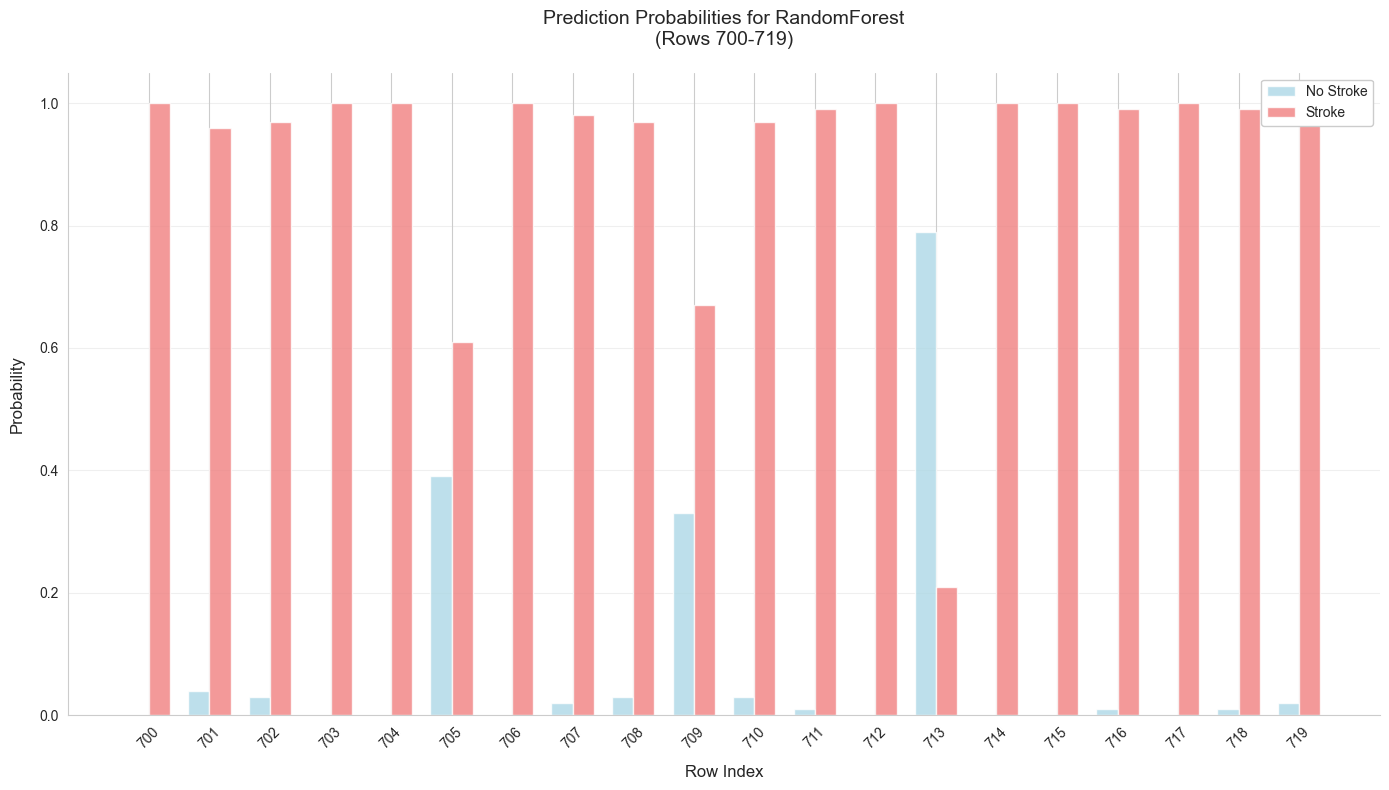


Results exported to:
- lime_results_summary.csv
- lime_feature_importance.csv


In [ ]:
import lime.lime_tabular
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from prettytable import PrettyTable
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Fix the feature names warning by ensuring X is a DataFrame with column names
X = pd.DataFrame(X, columns=X.columns)  # Ensure X maintains feature names

# Create LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X.values,
    feature_names=X.columns.tolist(),  # Explicitly convert to list
    class_names=["no stroke", "stroke"],
    mode="classification",
    verbose=False,
    random_state=42,
)

# Define and fit models with proper feature names handling
models = {
    "RandomForest": RandomForestClassifier(random_state=42),
    "LogisticRegression": LogisticRegression(random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
}

pipelines = {}
for name, model in models.items():
    pipeline = Pipeline([("scale", StandardScaler()), ("model", model)])
    pipeline.fit(X_train, y_train)
    pipelines[name] = pipeline

# Define parameters
start_index = 700
num_rows = 20
end_index = min(start_index + num_rows, len(X))
model_to_explain = "RandomForest"

# Create PrettyTable for results
lime_table = PrettyTable()
lime_table.field_names = [
    "Row Index",
    "Prediction",
    "P(No Stroke)",
    "P(Stroke)",
    "Top 5 Features",
]
lime_table.align = "r"
lime_table.align["Row Index"] = "r"
lime_table.align["Top 5 Features"] = "l"
lime_table.float_format = ".3"

# Collect LIME explanations
results = []
feature_importance_matrix = []

print(f"\n{' LIME ANALYSIS RESULTS ':=^80}")
print(f"Analyzing rows {start_index} to {end_index - 1} using {model_to_explain}\n")

for i in range(start_index, end_index):
    # Get LIME explanation
    exp = explainer.explain_instance(
        X.values[i],
        pipelines[model_to_explain].predict_proba,
        num_features=5,  # Show top 5 features for cleaner output
    )

    # Get prediction info
    pred_proba = pipelines[model_to_explain].predict_proba([X.values[i]])[0]
    prediction = (
        "Stroke"
        if pipelines[model_to_explain].predict([X.values[i]])[0]
        else "No Stroke"
    )

    exp_list = exp.as_list()
    feature_dict = dict(exp_list)

    # Format top features
    top_features = " | ".join([f"{feat}: {val:.3f}" for feat, val in exp.as_list()[:5]])

    # Add to PrettyTable
    lime_table.add_row(
        [i, prediction, f"{pred_proba[0]:.3f}", f"{pred_proba[1]:.3f}", top_features]
    )

    # Store for visualization
    results.append(
        {
            "Row_Index": i,
            "Prediction": prediction,
            "Prob_No_Stroke": pred_proba[0],
            "Prob_Stroke": pred_proba[1],
            "Top_Features": ", ".join(
                [f"{feat}: {val:.3f}" for feat, val in exp_list[:7]]
            ),
        }
    )

# Print the table
print(lime_table)
print("\n" + "=" * 80)
print("Key:")
print("- P(No Stroke): Probability of no stroke prediction")
print("- P(Stroke): Probability of stroke prediction")
print("- Top 5 Features: Most influential features with their weights")
print("=" * 80)

# Create single visualization
plt.figure(figsize=(14, 8))
results_df = pd.DataFrame(results)

# Prediction probabilities plot
x_pos = np.arange(len(results_df))
width = 0.35

plt.bar(
    x_pos - width / 2,
    results_df["Prob_No_Stroke"],
    width,
    label="No Stroke",
    alpha=0.8,
    color="lightblue",
    edgecolor="white",
)

plt.bar(
    x_pos + width / 2,
    results_df["Prob_Stroke"],
    width,
    label="Stroke",
    alpha=0.8,
    color="lightcoral",
    edgecolor="white",
)

# Customize plot
plt.xlabel("Row Index", fontsize=12, labelpad=10)
plt.ylabel("Probability", fontsize=12, labelpad=10)
plt.title(
    f"Prediction Probabilities for {model_to_explain}\n(Rows {start_index}-{end_index - 1})",
    fontsize=14,
    pad=20,
)
plt.xticks(x_pos, results_df["Row_Index"], rotation=45)
plt.legend(frameon=True, framealpha=1)
plt.grid(axis="y", alpha=0.3)
sns.despine()

plt.tight_layout()
plt.show()

# Export results
results_df.to_csv("lime_results_summary.csv", index=False)
pd.DataFrame(feature_importance_matrix, columns=X.columns).to_csv(
    "lime_feature_importance.csv", index=False
)

print("\nResults exported to:")
print("- lime_results_summary.csv")
print("- lime_feature_importance.csv")

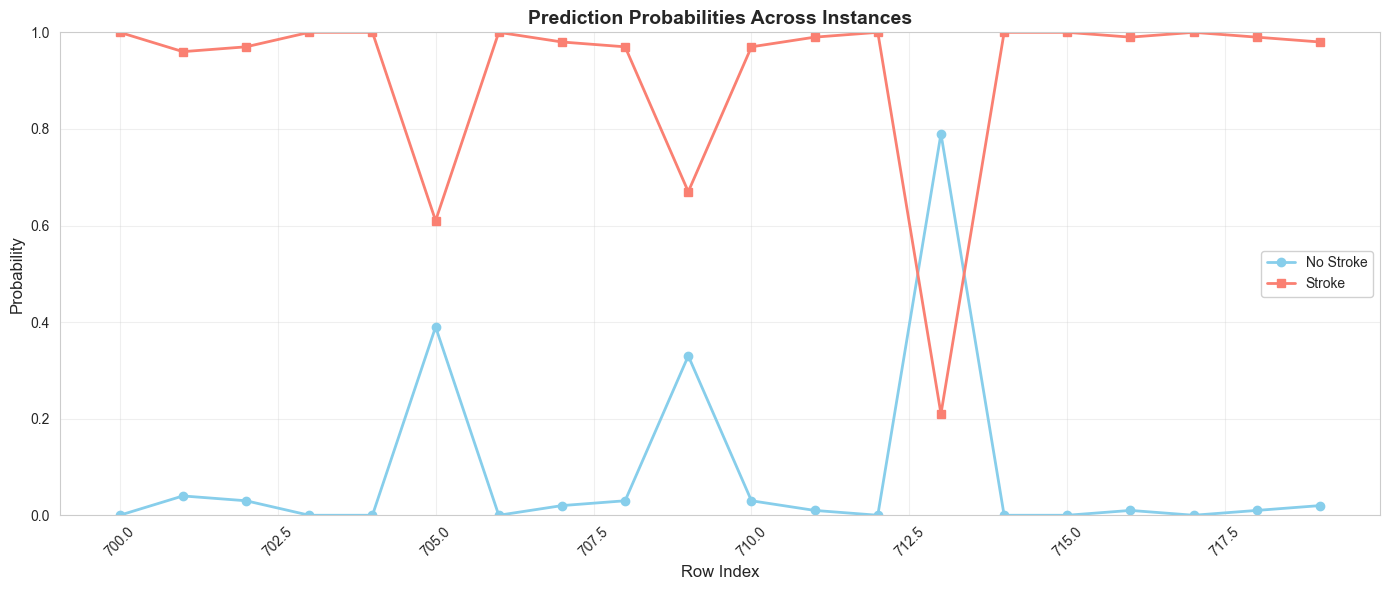

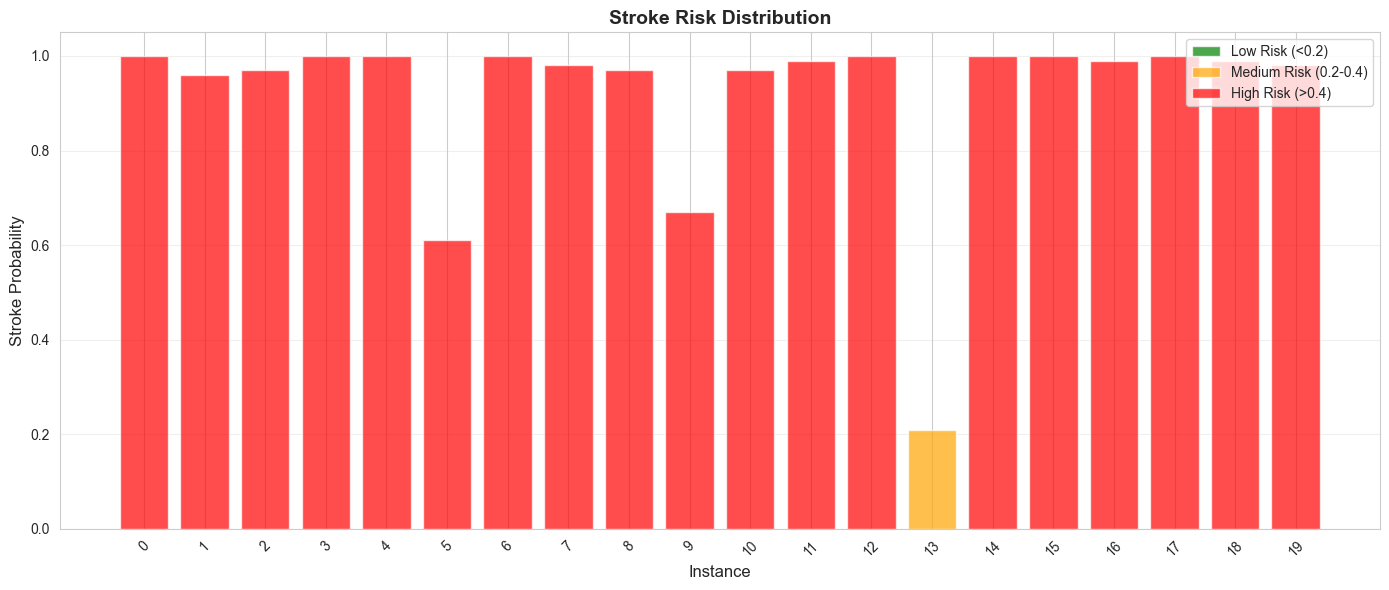

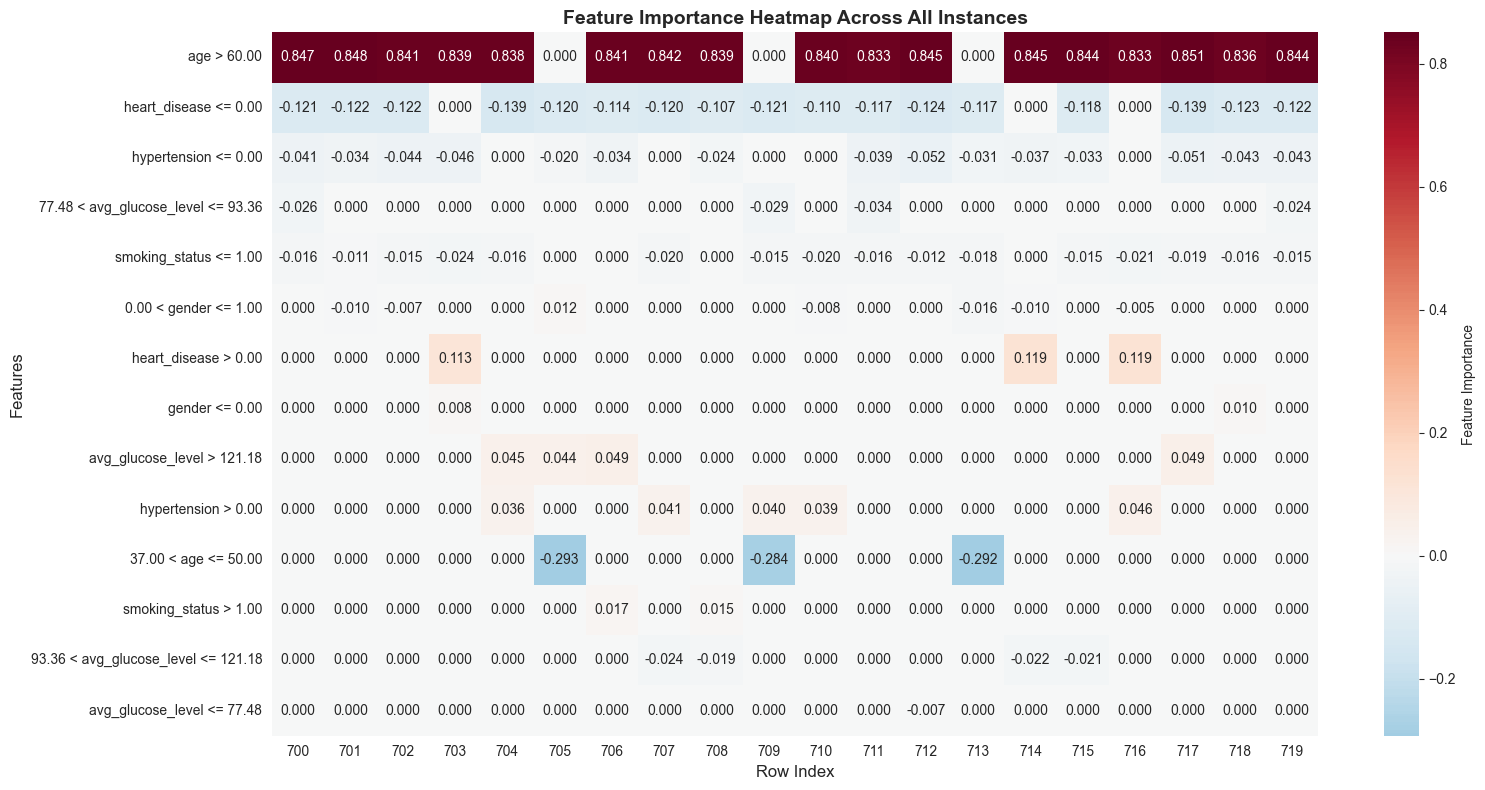

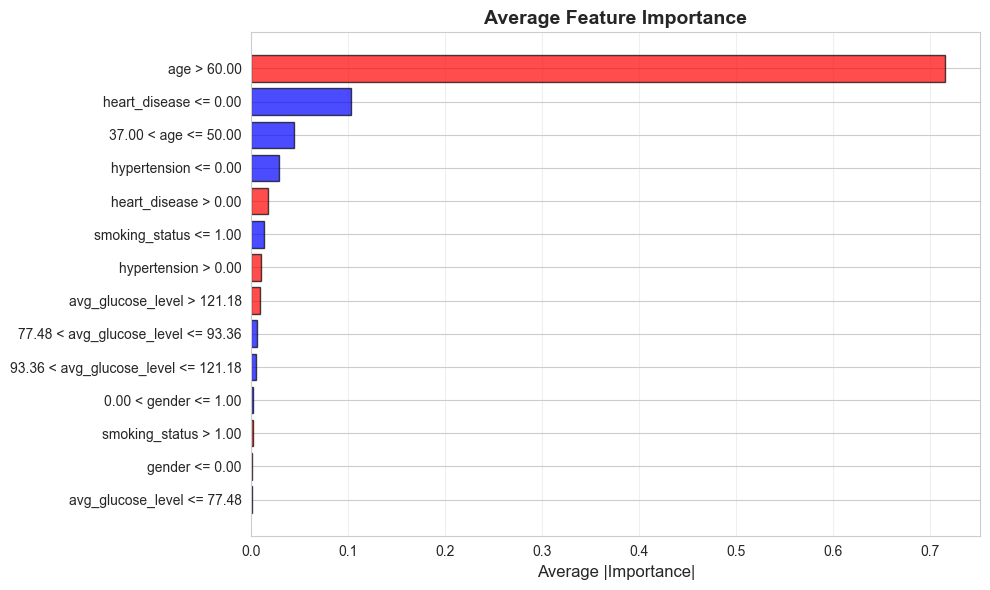

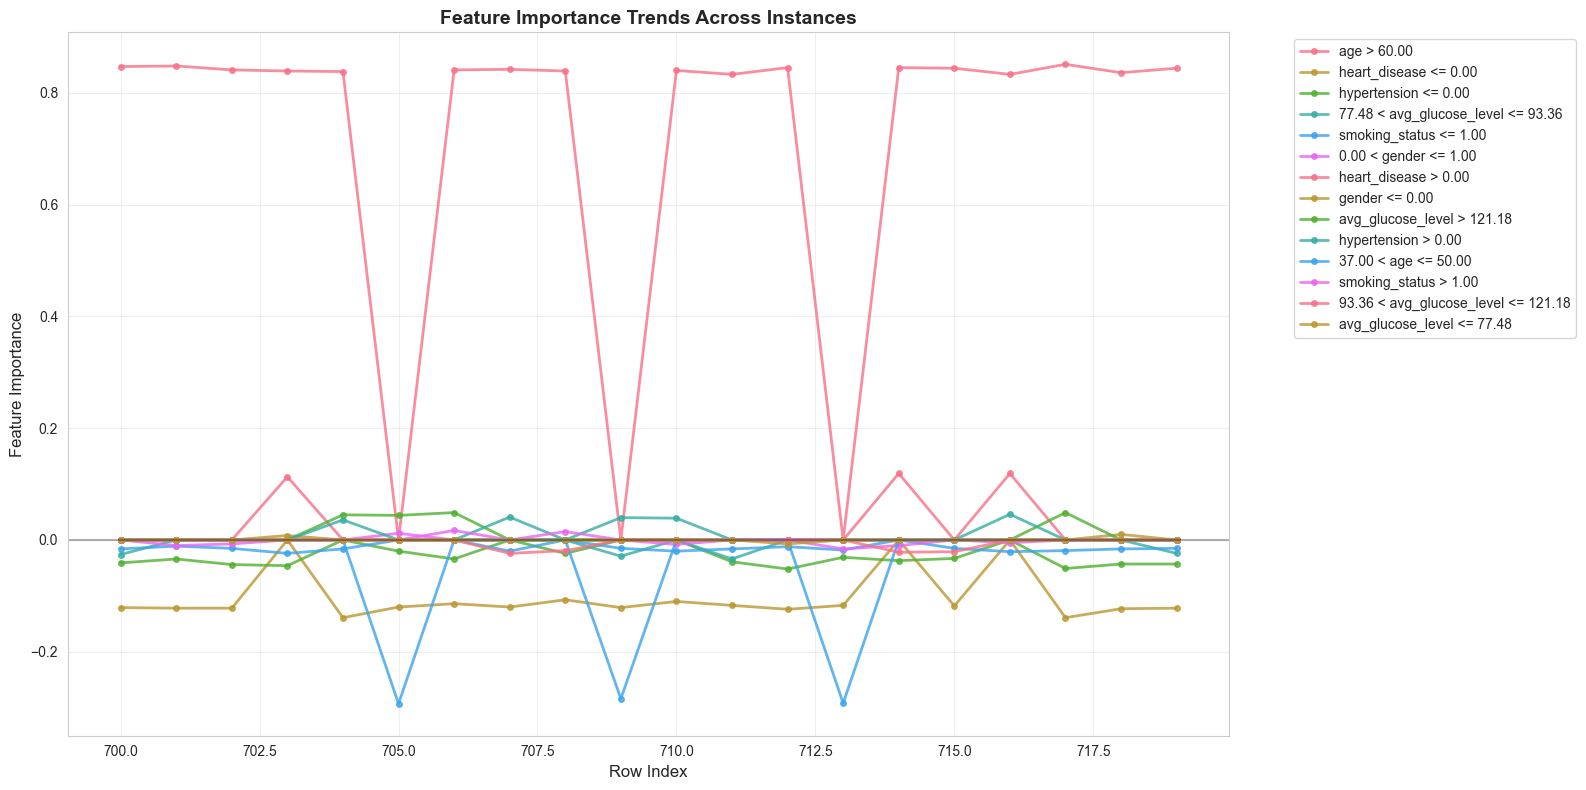

In [ ]:
import re
from collections import defaultdict
from matplotlib.patches import Patch

# Read and process data (unchanged)
df = pd.read_csv("lime_results_summary.csv")


def extract_feature_importance(features_text):
    features_text = features_text.strip('"')
    features = features_text.split(", ")
    feature_dict = {}
    for feature in features:
        match = re.search(r"(.+?):\s*([-+]?\d*\.?\d+)", feature)
        if match:
            feature_name = match.group(1).strip()
            importance = float(match.group(2))
            feature_dict[feature_name] = importance
    return feature_dict


all_features = defaultdict(list)
for idx, row in df.iterrows():
    feature_dict = extract_feature_importance(row["Top_Features"])
    for feature, importance in feature_dict.items():
        all_features[feature].append(importance)

feature_names = list(all_features.keys())
feature_matrix = []
for idx, row in df.iterrows():
    feature_dict = extract_feature_importance(row["Top_Features"])
    feature_row = [feature_dict.get(feature, 0) for feature in feature_names]
    feature_matrix.append(feature_row)

feature_df = pd.DataFrame(feature_matrix, columns=feature_names, index=df["Row_Index"])

# 1. Prediction Probabilities Line Plot (Independent Figure)
plt.figure(figsize=(14, 6))
plt.plot(
    df["Row_Index"],
    df["Prob_No_Stroke"],
    marker="o",
    linewidth=2,
    markersize=6,
    label="No Stroke",
    color="skyblue",
)
plt.plot(
    df["Row_Index"],
    df["Prob_Stroke"],
    marker="s",
    linewidth=2,
    markersize=6,
    label="Stroke",
    color="salmon",
)
plt.xlabel("Row Index", fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.title("Prediction Probabilities Across Instances", fontsize=14, fontweight="bold")
plt.legend(frameon=True, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Risk Distribution (Independent Figure)
plt.figure(figsize=(14, 6))
colors = [
    "green" if x < 0.2 else "orange" if x < 0.4 else "red" for x in df["Prob_Stroke"]
]
bars = plt.bar(
    range(len(df)), df["Prob_Stroke"], color=colors, alpha=0.7, edgecolor="white"
)
plt.xlabel("Instance", fontsize=12)
plt.ylabel("Stroke Probability", fontsize=12)
plt.title("Stroke Risk Distribution", fontsize=14, fontweight="bold")
plt.xticks(range(0, len(df)), rotation=45)

legend_elements = [
    Patch(facecolor="green", alpha=0.7, label="Low Risk (<0.2)"),
    Patch(facecolor="orange", alpha=0.7, label="Medium Risk (0.2-0.4)"),
    Patch(facecolor="red", alpha=0.7, label="High Risk (>0.4)"),
]
plt.legend(handles=legend_elements, loc="upper right")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# 3. Feature Importance Heatmap (Independent Figure)
plt.figure(figsize=(16, 8))
sns.heatmap(
    feature_df.T,
    annot=True,
    cmap="RdBu_r",
    center=0,
    fmt=".3f",
    xticklabels=df["Row_Index"],
    yticklabels=feature_names,
    cbar_kws={"label": "Feature Importance"},
)
plt.title(
    "Feature Importance Heatmap Across All Instances", fontsize=14, fontweight="bold"
)
plt.xlabel("Row Index", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

# 4. Average Feature Importance (Independent Figure)
plt.figure(figsize=(10, 6))
avg_importance = feature_df.mean().abs().sort_values(ascending=True)
colors = ["red" if x > 0 else "blue" for x in feature_df.mean()[avg_importance.index]]
plt.barh(
    range(len(avg_importance)),
    avg_importance.values,
    color=colors,
    alpha=0.7,
    edgecolor="black",
)
plt.yticks(range(len(avg_importance)), avg_importance.index, fontsize=10)
plt.xlabel("Average |Importance|", fontsize=12)
plt.title("Average Feature Importance", fontsize=14, fontweight="bold")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Feature Importance Trends (Independent Figure)
plt.figure(figsize=(16, 8))
for feature in feature_names:
    if feature in feature_df.columns:
        plt.plot(
            df["Row_Index"],
            feature_df[feature],
            marker="o",
            linewidth=2,
            markersize=4,
            label=feature,
            alpha=0.8,
        )
plt.xlabel("Row Index", fontsize=12)
plt.ylabel("Feature Importance", fontsize=12)
plt.title("Feature Importance Trends Across Instances", fontsize=14, fontweight="bold")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, alpha=0.3)
plt.axhline(y=0, color="black", linestyle="-", alpha=0.3)
plt.tight_layout()
plt.show()

# [Keep all your existing text output and CSV export code here]

In [692]:
# Export enhanced results
enhanced_df = df.copy()
enhanced_df["Risk_Category"] = pd.cut(
    df["Prob_Stroke"], bins=[0, 0.2, 0.4, 1.0], labels=["Low", "Medium", "High"]
)
enhanced_df.to_csv("enhanced_lime_results.csv", index=False)
feature_df.to_csv("feature_importance_matrix.csv")

print("\nFiles saved:")
print("- enhanced_lime_results.csv")
print("- feature_importance_matrix.csv")


Files saved:
- enhanced_lime_results.csv
- feature_importance_matrix.csv
